<h2>Runs the ti_melt model for a set of drainageIDs and years</h2>


In [ ]:
%pylab notebook
import datetime as dt
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as md
#from nose.tools import set_trace
from charistools.hypsometry import Hypsometry
from charistools.meltModels import TriSurfTempIndexMelt
from charistools.meltModels import ImshowTriSurfMelt
from charistools.meltModels import PlotTriSurfInput
from charistools.meltModels import PlotTriSurfMelt
from charistools.modelEnv import ModelEnv
from charistools.timeSeries import TimeSeries
import pandas as pd
import re
import os

In [ ]:
configFile = '/projects/brodzik/charis_ti_melt/calibration_modelEnv_config.ini'
myEnv = ModelEnv(tileConfigFile=configFile)

In [4]:
%cat $configFile
#myEnv.tileConfig

# Data processing configuration for MODIS-tile data
# used by CHARIS melt modeling
#
model_top_dir = /work/charis/ti_model/

# Input raster (MODIS tiles) data filename patterns   
[input]

    # Model forcing data that varies by time (annual, daily)
    [[forcing]]

	# MODSCAG gap-filled snow-cover
	[[[modscag_gf]]]
	dir = %MODEL_TOP_DIR%/snow_cover/MODSCAG_GF/v09/%TILEID%
	pattern = MODSCAG_GF_Snow.v0.9.%TILEID%_%YYYY%.h5
	id = MODSCAG_GF_Snow.v0.9

	# MODSCAG grain size
	[[[grsize_scag]]]
	dir = %MODEL_TOP_DIR%/grain_size/MODSCAG_GF/v09/%TILEID%
	pattern = MODSCAG_GF_GrainSize.v0.9.%TILEID%_%YYYY%.h5
	id = MODSCAG_GF_GrainSize.v0.9

	[[[threshold]]]
	dir = %MODEL_TOP_DIR%/snow_ice_partition/Landsat/Hunza/v3.2
	pattern = p149r035_MODSCAG_GS_threshold.csv
	id = p149r035_MODSCAG_GS
	
	# Downscaled temperature data
	[[[temperature]]]
	dir = %MODEL_TOP_DIR%/temperature/ERA-Interim/v3/%TILEID%
	pattern = ERA_Interim_downscale_uncorrected_tsurf.v0.3.%TILEID%_%YYYY%.h5
	id = ERA_Interim_down

In [ ]:
# Generate a list of all OBJECTID basins
%cd /Users/brodzik/projects/CHARIS/derived_hypsometries/MODSCAG_GF_v09_fromFile_MERRA_less_ET/
majorBasinIDs = ['AM', 'BR','GA_v01', 'IN_v01', 'SY_v01']
drainageIDs = []
for id in majorBasinIDs:
    ids = glob.glob("%s_OBJECTID*" % id)
    ids.sort()
    drainageIDs = drainageIDs + ids
    print("There are %d sub-basins for the %s major basin" % (len(ids), id))

len(drainageIDs)
drainageIDs

In [ ]:
#drainageIDs[62:]
drainageIDs = drainageIDs[62:]
drainageIDs

In [21]:
#names = ['Astore', 'DrasNala', 'Gilgit', 'Hunza', 'Kharmong', 'Shigar', 'Shyok', 'Tarbela', 'Zanskar']
#names = ['10']
#names = ['Tarbela']
#drainageIDs = ["IN_OBJECTID%s" % name for name in names]
drainageIDs = ["IN_Hunza_at_DainyorBridge", "AM_Vakhsh_at_Komsomolabad", "SY_Naryn_at_NarynTown"]
#drainageIDs = ["IN_Hunza_at_DainyorBridge"]
#drainageIDs = ["GA_Karnali_at_Benighat", "GA_Narayani_at_Devghat", "GA_SaptaKosi_at_Chatara"]

In [22]:
ablation_method = 'grsize_scag'
threshold = 'fromFile'
nstrikes = 3

years = np.arange(14) + 2001
#years = np.arange(1) + 2006

#years = np.arange(7) + 2001
DDF_annotation = True
show_rainfall = True
rainfall_col = 'diff_km3'
show_runoff = True

closePlot = True

In [23]:
drainageIDs, years

(['IN_Hunza_at_DainyorBridge',
  'AM_Vakhsh_at_Komsomolabad',
  'SY_Naryn_at_NarynTown'],
 array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014]))

In [24]:
def run_model(drainageID, year=2001, nstrikes=3, ablation_method='grsize_scag', threshold=205, 
              model_str="8.67_8.67_10.0_17.0", label='best_model'):
    input = myEnv.model_inputs(drainageID=drainageID,
                               year=year,
                               modice_nstrikes=nstrikes,
                               ablation_method=ablation_method,
                               threshold=threshold)

    (min_snow_ddf, max_snow_ddf, min_ice_ddf, max_ice_ddf) = model_str.split("_")
    min_snow_ddf = float(min_snow_ddf)
    max_snow_ddf = float(max_snow_ddf)
    min_ice_ddf = float(min_ice_ddf)
    max_ice_ddf = float(max_ice_ddf)
    
    (SOLmelt, SOImelt, EGImelt) = TriSurfTempIndexMelt(
        input['snow_on_land_by_elevation_filename'],
        input['snow_on_ice_by_elevation_filename'],
        input['exposed_glacier_ice_by_elevation_filename'],
        input['temperature_by_elevation_filename'],
        min_snow_ddf=min_snow_ddf,
        max_snow_ddf=max_snow_ddf,
        min_ice_ddf=min_ice_ddf,
        max_ice_ddf=max_ice_ddf)
    
    SOLmeltfile = myEnv.hypsometry_filename(
        type='snow_on_land_melt_by_elevation',
        drainageID=drainageID,
        year=year,
        modice_nstrikes=nstrikes,
        ablation_method=ablation_method,
        threshold=threshold)
    SOImeltfile = myEnv.hypsometry_filename(
        type='snow_on_ice_melt_by_elevation',
        drainageID=drainageID,
        year=year,
        modice_nstrikes=nstrikes,
        ablation_method=ablation_method,
        threshold=threshold)
    EGImeltfile = myEnv.hypsometry_filename(
        type='exposed_glacier_ice_melt_by_elevation',
        drainageID=drainageID,
        year=year,
        modice_nstrikes=nstrikes,
        ablation_method=ablation_method,
        threshold=threshold)
    SOLmeltfile = SOLmeltfile.replace('_by_elev.', '_by_elev.' + label + '.')
    SOImeltfile = SOImeltfile.replace('_by_elev.', '_by_elev.' + label + '.')
    EGImeltfile = EGImeltfile.replace('_by_elev.', '_by_elev.' + label + '.')

    columns = [float(i) for i in SOLmelt.data.columns]
    SOLmelt.data.columns = columns
    SOLmelt.data = SOLmelt.data[sort(columns)]

    # Temporary fix for SOLmelt.data NaNs
    SOLmelt.data = SOLmelt.data.fillna(value=0.)

    columns = [float(i) for i in SOImelt.data.columns]
    SOImelt.data.columns = columns
    SOImelt.data = SOImelt.data[sort(columns)]

    columns = [float(i) for i in EGImelt.data.columns]
    EGImelt.data.columns = columns
    EGImelt.data = EGImelt.data[sort(columns)]

    SOLmelt.write(filename=SOLmeltfile, decimal_places=6)
    SOImelt.write(filename=SOImeltfile, decimal_places=6)
    EGImelt.write(filename=EGImeltfile, decimal_places=6)
    
    print("%s : %d : model=%s" % (drainageID, year, model_str))
    
    baseFilename = SOImeltfile
    p = re.compile(r'snow_on_ice.+')
    baseFilename = p.sub('', baseFilename)
    
    return(baseFilename, input, model_str, SOLmelt, SOImelt, EGImelt)

In [25]:
def add_isotherm(ax, x, y, color):
    orig_ylim = ax.get_ylim()
    ax.plot(x, y, c=color)
    ax.set_ylim(orig_ylim)

In [26]:
def show_melt_hyps(drainageID, year, baseFilename, temperatureFilename,
                   SOLmelt, SOImelt, EGImelt, label='best_model', closePlot=True):
    
    year_str = str(year)
    fig, axes = plt.subplots(4,1, figsize=(8,10))
    
    # If SOLmelt is non-empty, but SOImelt and SGImelt are empty,
    # then make a copy of the dimensions of SOLmelt that is filled with zeroes
    if not SOLmelt.data.empty and SOImelt.data.empty and EGImelt.data.empty:
        SOImelt.data = SOLmelt.data.copy()
        SOImelt.data[:] = 0.
        EGImelt.data = SOLmelt.data.copy()
        EGImelt.data[:] = 0.
        
    ImshowTriSurfMelt(axes[:3], SOLmelt, SOImelt, EGImelt)
    
    # Fetch the temperature data hypsometry
    temperatureHyps = Hypsometry(temperatureFilename)
    temperatureHyps.data.replace(to_replace='--', value=0.0, inplace=True)
    axes[3] = temperatureHyps.imshow(ax=axes[3], title='Temperature',
                                     vmin=-45, vmax=45, cmap='RdGy_r'
                                    )
    for ax in axes:
        ax.set_title(drainageID + " (" + year_str + ") " + ax.get_title())
        
    # Add a zero-degree isotherm line to each of the melt plots
    # Find elevation of zero-degree isotherm
    # Default is the highest elevation
    zero_isotherm_elevations = np.full(len(temperatureHyps.data.index),
                                       float(temperatureHyps.data.columns[-1]))
    for i, d in enumerate(temperatureHyps.data.index):
        neg_temps = temperatureHyps.data.loc[d][temperatureHyps.data.loc[d] < 0]
        if len(neg_temps) > 0:
            zero_isotherm_elevations[i] = float(neg_temps.index[0])
    
                                       
        # zero_isotherm_elevations = [
        # float(temperatureHyps.data.loc[d][temperatureHyps.data.loc[d] < 0].index[0]) 
        # for d in temperatureHyps.data.index]
    zero_isotherm_x = temperatureHyps.data.index
    isotherm_color = (0.8, 0.8, 0.8)
    add_isotherm(axes[0], zero_isotherm_x, zero_isotherm_elevations, isotherm_color)
    add_isotherm(axes[1], zero_isotherm_x, zero_isotherm_elevations, isotherm_color)
    add_isotherm(axes[2], zero_isotherm_x, zero_isotherm_elevations, isotherm_color)
    add_isotherm(axes[3], zero_isotherm_x, zero_isotherm_elevations, isotherm_color)
    
    #import pdb; pdb.set_trace()
    
    fig.tight_layout()
    outfile = baseFilename + label + '.melt_hyps.png'
    fig.savefig(outfile)
    print("Wrote melt_hyps to %s" % outfile)
    if (closePlot):
        plt.close('all')

In [27]:
def show_melt_tseries(drainageID, year, baseFilename, input, model_str,
                      SOLmelt, SOImelt, EGImelt,
                      label='best_model',
                      DDF_annotation=True, show_rainfall=False, rainfall_col=None, 
                      show_runoff=False,
                      closePlot=True):
    year_str = str(year)
    (min_snow_ddf, max_snow_ddf, min_ice_ddf, max_ice_ddf) = model_str.split("_")
    min_snow_ddf = float(min_snow_ddf)
    max_snow_ddf = float(max_snow_ddf)
    min_ice_ddf = float(min_ice_ddf)
    max_ice_ddf = float(max_ice_ddf)
    
    melt_by_doy = (SOLmelt.data_by_doy() +
                   SOImelt.data_by_doy() +
                   EGImelt.data_by_doy())
    total_melt = melt_by_doy.sum()
    print("total melt = %.2f" % total_melt)
    melt_by_month = melt_by_doy.groupby([pd.TimeGrouper('M')]).sum().to_frame(name='melt')

    yyyymm_index = pd.to_datetime(melt_by_month.index.map(lambda x: x.strftime('%Y-%m-15')))
    df = pd.DataFrame(data=melt_by_month.values, index=yyyymm_index, columns=['melt'])
    df['SOLmelt'] = SOLmelt.data_by_doy().groupby([pd.TimeGrouper('M')]).sum().values
    df['SOImelt'] = SOImelt.data_by_doy().groupby([pd.TimeGrouper('M')]).sum().values
    df['EGImelt'] = EGImelt.data_by_doy().groupby([pd.TimeGrouper('M')]).sum().values
    #print(df)
    
    
    fig, ax = plt.subplots(3,1,figsize=(9,9))
    left_ax, right_ax = PlotTriSurfInput(
        ax[0], 
        input['snow_on_land_by_elevation_hyps'],
        input['snow_on_ice_by_elevation_hyps'],
        input['exposed_glacier_ice_by_elevation_hyps'],
        input['temperature_by_elevation_hyps'],
        temperature_color=(0.7, 0.7, 0.7),
        title="Inputs for %s (%d)" % (drainageID, year))
    
    h, l = left_ax.get_legend_handles_labels()                                       
    h1, l1 = right_ax.get_legend_handles_labels()                                    
    left_ax.legend(h+h1, l+l1, framealpha=0.5, loc='upper right') 
    #left_ax.legend(framealpha=0.5)
    ax[1] = PlotTriSurfMelt(
        ax[1], 
        SOLmelt, 
        SOImelt, 
        EGImelt, 
        title="Modelled melt for %s (%d)" % (drainageID, year))
    ax[1].legend(framealpha=0.5, loc='upper right')
    if DDF_annotation:
        ax[1].text(ax[1].get_xlim()[0] + (0.03 * (ax[1].get_xlim()[1] - ax[1].get_xlim()[0])), 
                   ax[1].get_ylim()[1] * 0.7,
                   'snow DDF = %.2f - %.2f $mm/C/day$\nice DDF = %.2f - %.2f $mm/C/day$' % 
                   (min_snow_ddf, max_snow_ddf, min_ice_ddf, max_ice_ddf),
                   style='italic',
                   bbox={'facecolor':'gray', 'alpha':0.1, 'pad':10})
    
    # Get the line colors used by PlotTriSurfMelt
    lines = ax[1].get_lines()
    SOIcolor = lines[1].get_color()
    EGIcolor = lines[2].get_color()
    SOLcolor = lines[3].get_color()

    title = "Melt"
    right_bar_list = ['EGImelt', 'SOImelt', 'SOLmelt']
    right_bar_colors = [ EGIcolor, SOIcolor, SOLcolor ]
    right_bar_title = "melt"
    right_bar_sum = df["melt"].sum()
    ylim = np.amax(df["melt"])
    ylim_min = 0.
    
    # Fetch rainfall and/or runoff, if requested
    have_et = False
    if show_rainfall:
        
        rainfallFile = myEnv.calibration_filename(type="rainfall", drainageID=drainageID)
        rainfall = TimeSeries(rainfallFile)
        monthly_rainfall = rainfall.data['rainfall'][year_str + '-01-01':year_str + '-12-01']
        monthly_et = rainfall.data['et_km3'][year_str + '-01-01':year_str + '-12-01']
        
        rainfall_label = "rainfall"
        et_label = "ET"
            
        if 0 < len(monthly_rainfall.index):
            df[rainfall_label] = monthly_rainfall.values
        else:
            df[rainfall_label] = np.nan
            
        if 0 < len(monthly_et.index):
            df[et_label] = -1 * monthly_et.values
            have_et = True
        else:
            df[et_label] = np.nan
            
        
            
        rainfallcolor = 'c'
        right_bar_list = [rainfall_label] + right_bar_list
        right_bar_colors = [ rainfallcolor ] + right_bar_colors
        # The following will ignore any NaNs and just return
        # the operation using the non-NaN values:
        ylim = np.amax(df[["melt", rainfall_label]].sum(axis=1))
        title = rainfall_label + " + Melt"
        right_bar_title = 'melt + ' + rainfall_label
        right_bar_sum = df[["melt", rainfall_label]].sum(axis=1).sum()
        
        
        if have_et:
            etcolor = (0.8, 0.8, 0.8)
            et_bar_list = ["ET"]
            et_bar_colors = [ etcolor ]
            ylim_min = df.ET.min()
            title = "%s - ET" % title
            right_bar_title = "%s - ET" % right_bar_title
            right_bar_sum = right_bar_sum + df[[et_label]].sum(axis=1).sum()
            
    monthly_annotation = '%s = %.2f $km^3$' % (right_bar_title, right_bar_sum)
    if show_runoff:
        runoffFile = myEnv.calibration_filename(type="runoff", drainageID=drainageID)
        runoff = TimeSeries(runoffFile)
        monthly_runoff = runoff.data['runoff'][year_str + '-01-01':year_str + '-12-01']
        if 0 < len(monthly_runoff.index) and np.amax(monthly_runoff.values) >= 0.:
            df["runoff"] = monthly_runoff.values
            max_runoff = np.amax(df["runoff"])
        else:
            df["runoff"] = np.nan
            max_runoff = 0
            
        
        runoffcolor = (0.4, 0.4, 0.4)
        ylim = np.amax([ylim, max_runoff])
        title = "Runoff vs. " + title
        df[["runoff"]].plot(ax=ax[2], kind="bar",
                            edgecolor=(0.9, 0.9, 0.9),
                            color=[runoffcolor])
        monthly_annotation = '%s = %.2f $km^3$\nrunoff = %.2f $km^3$' % (
            right_bar_title, right_bar_sum, df["runoff"].sum())
    
    df[right_bar_list].plot(ax=ax[2], 
                            stacked=True, kind="bar", 
                            position=0.,
                            edgecolor=(0.9, 0.9, 0.9),
                            color=right_bar_colors)
    if have_et:
        df[et_bar_list].plot(ax=ax[2],
                             kind="bar",
                             position=0.0,
                             edgecolor=(0.9, 0.9, 0.9),
                             color=et_bar_colors)
        ax[2].axhline(c=(0.7, 0.7, 0.7))
    ax[2].set_title("Monthly " + title)
    ax[2].set_ylabel('Volume (' + r'$km^3$' + ')') 
    ax[2].xaxis.set_major_formatter(plt.NullFormatter())
    for container in ax[2].containers:
        plt.setp(container, width=0.25)
    ax[2].set_ylim([1.1 * ylim_min, 1.1 * ylim])
    ax[2].text(ax[2].get_xlim()[0] + (0.03 * (ax[2].get_xlim()[1] - ax[2].get_xlim()[0])),
               ax[2].get_ylim()[1] * 0.7,
               monthly_annotation,
               style='italic',
               bbox={'facecolor':'gray', 'alpha':0.1, 'pad':10})
    handles, labels = ax[2].get_legend_handles_labels()
    ax[2].legend(reversed(handles), reversed(labels), loc='upper right')
    
    fig.tight_layout()
    outfile = baseFilename + label + '.melt_tseries.png'
    fig.savefig(outfile)
    print("Wrote melt_tseries to %s" % outfile)
    if (closePlot):
        plt.close('all')

In [28]:
drainageIDs, years

(['IN_Hunza_at_DainyorBridge',
  'AM_Vakhsh_at_Komsomolabad',
  'SY_Naryn_at_NarynTown'],
 array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014]))

drainageID=IN_Hunza_at_DainyorBridge, majorID=IN, model=9.77_11.21_26.08_32.22, label=best_Hunza_SA_model
IN_Hunza_at_DainyorBridge : 2001 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


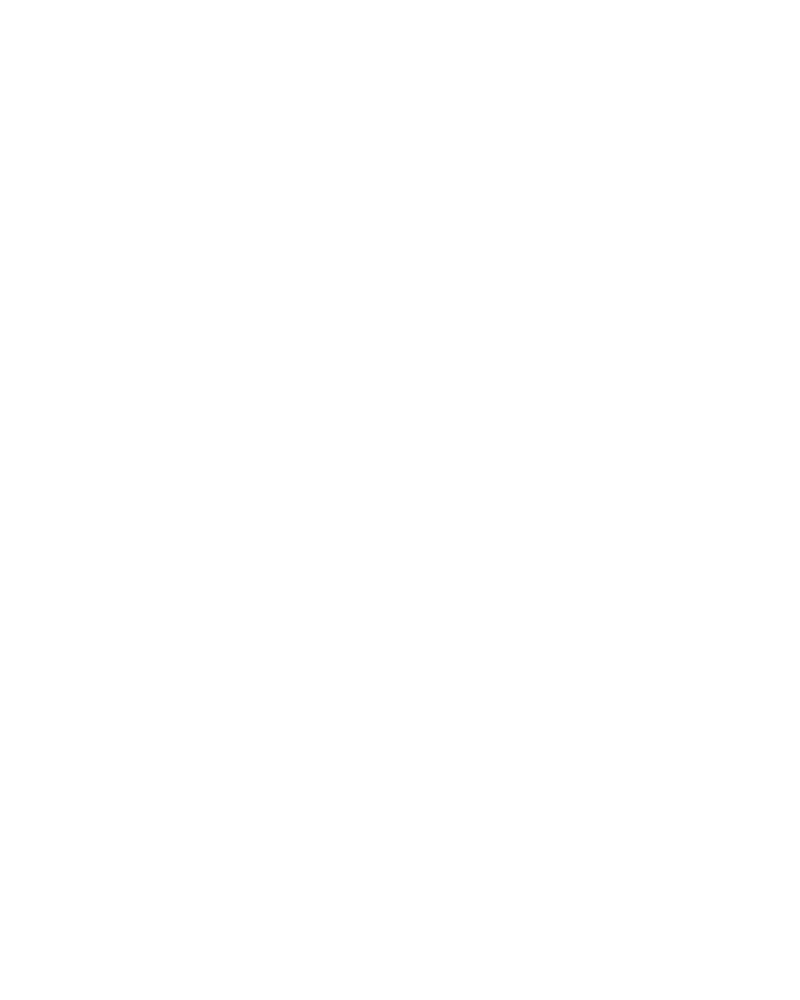

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 9.01


<IPython.core.display.Javascript object>


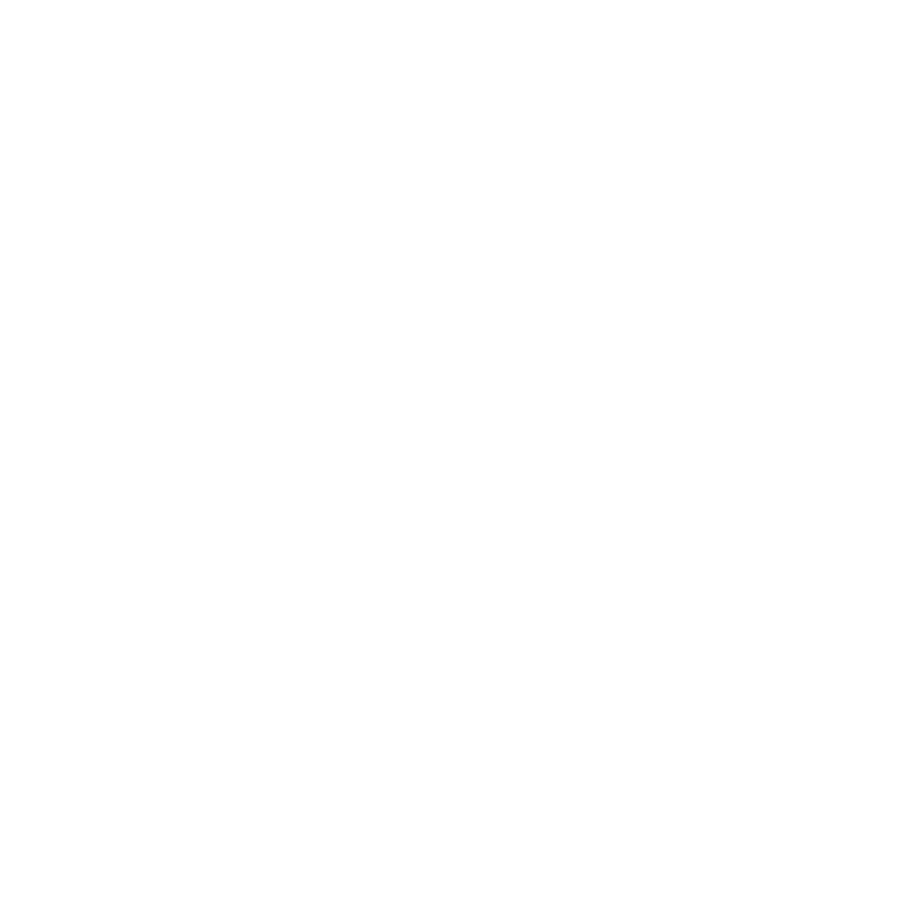

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2001.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2002 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


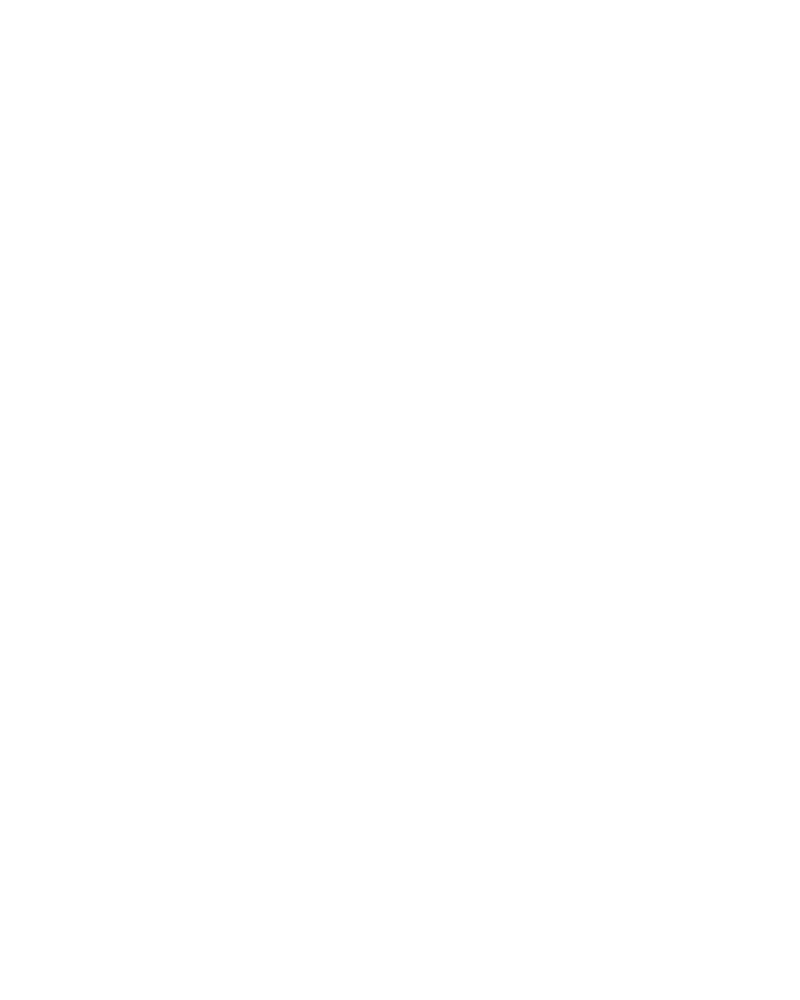

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2002.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 9.46


<IPython.core.display.Javascript object>


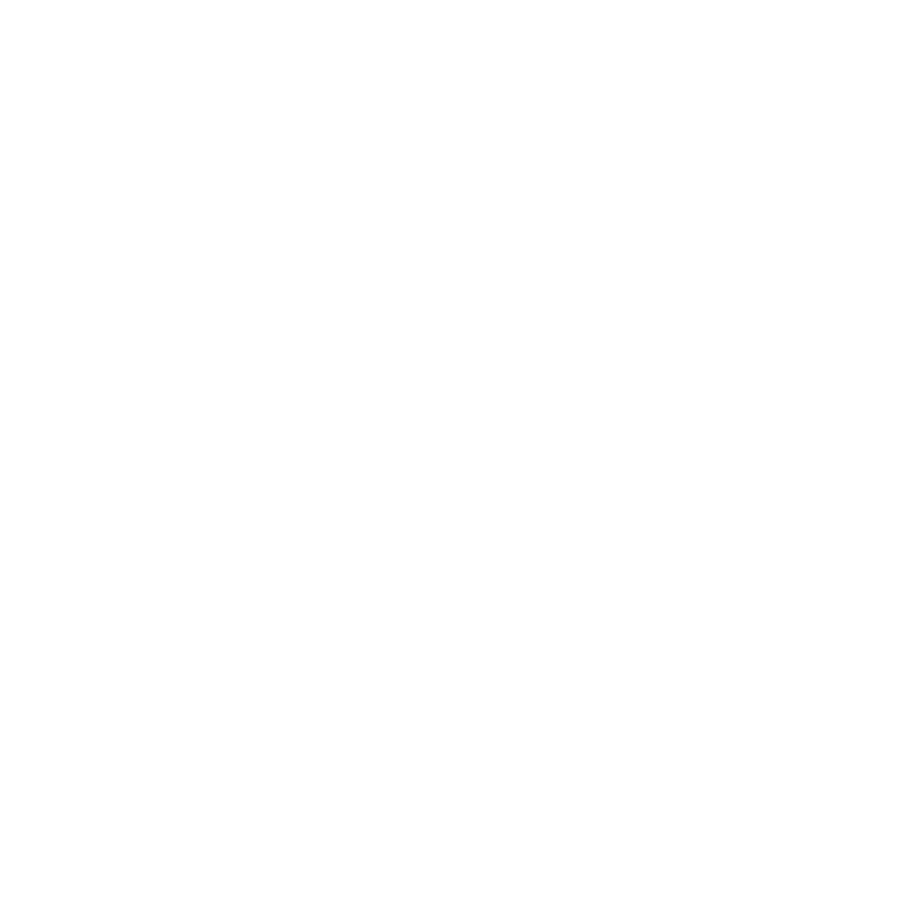

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2002.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2003 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


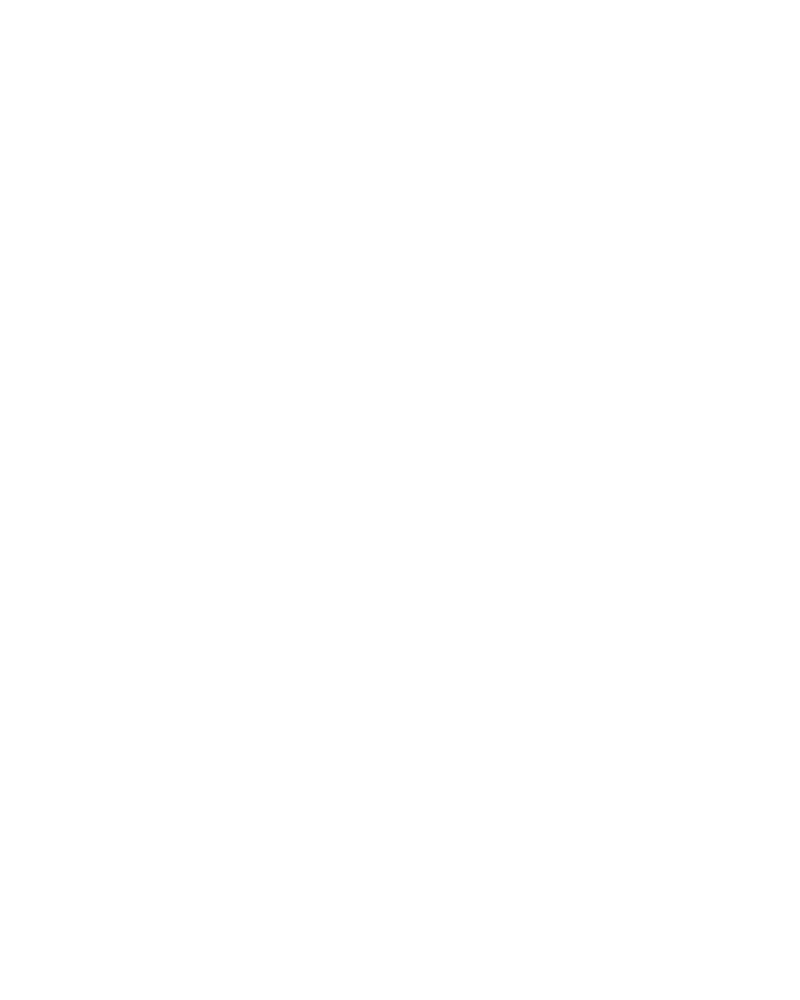

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2003.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 10.55


<IPython.core.display.Javascript object>


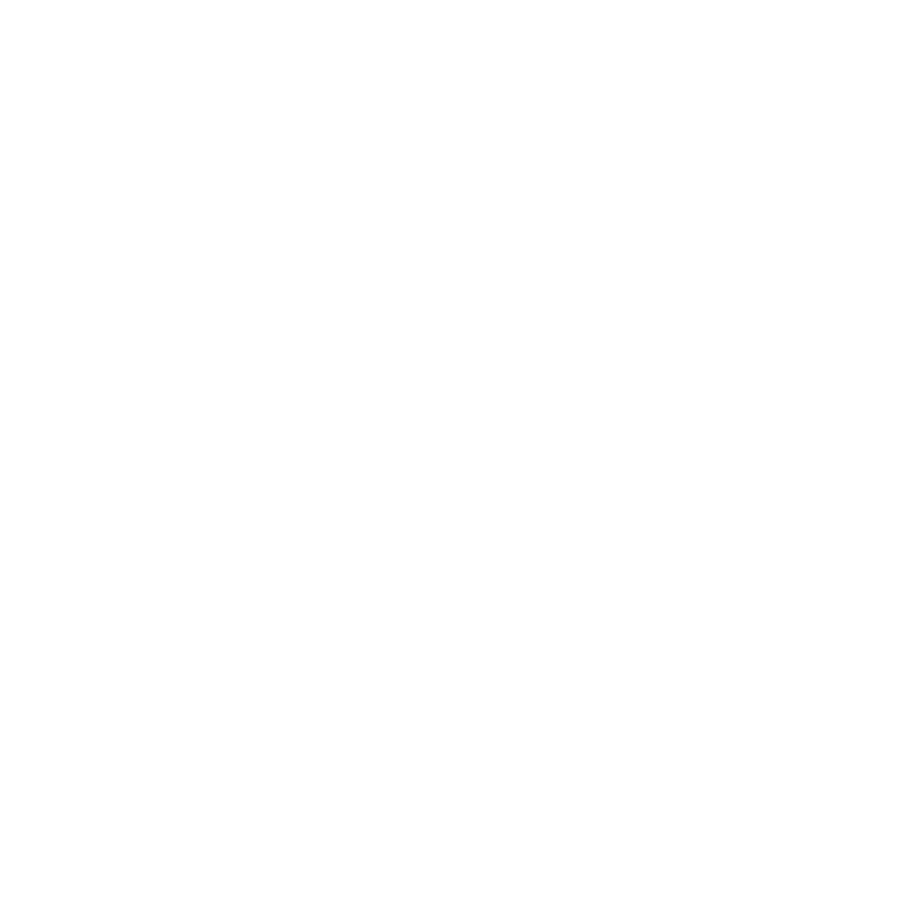

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2003.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2004 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


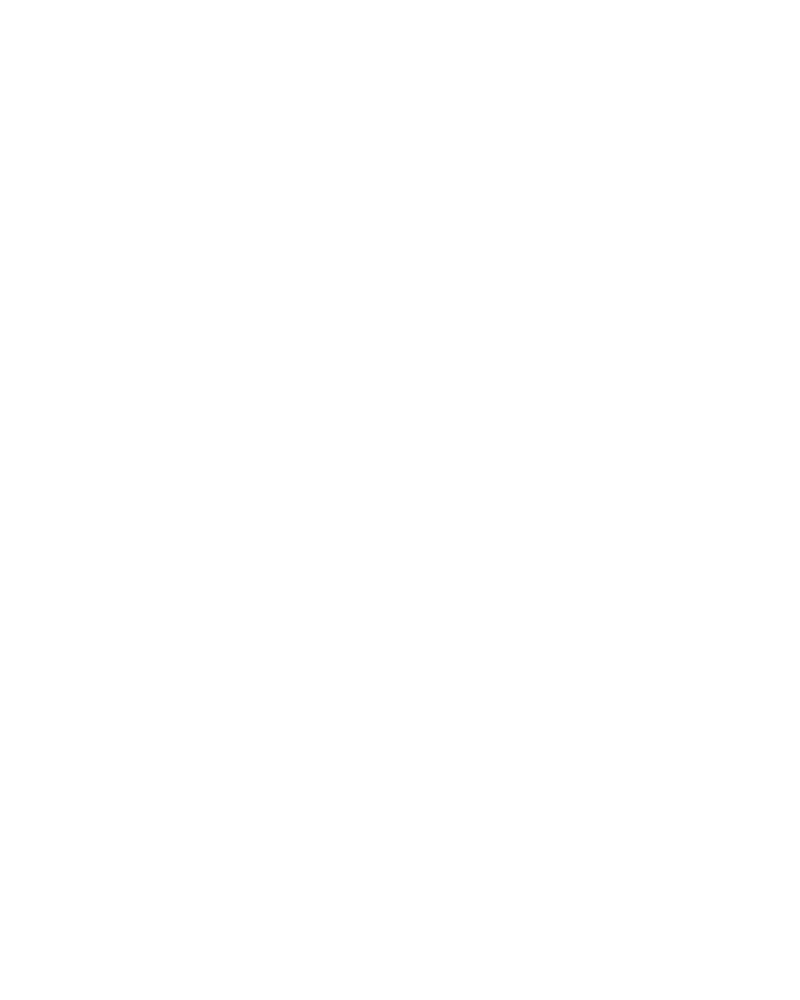

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2004.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 11.63


<IPython.core.display.Javascript object>


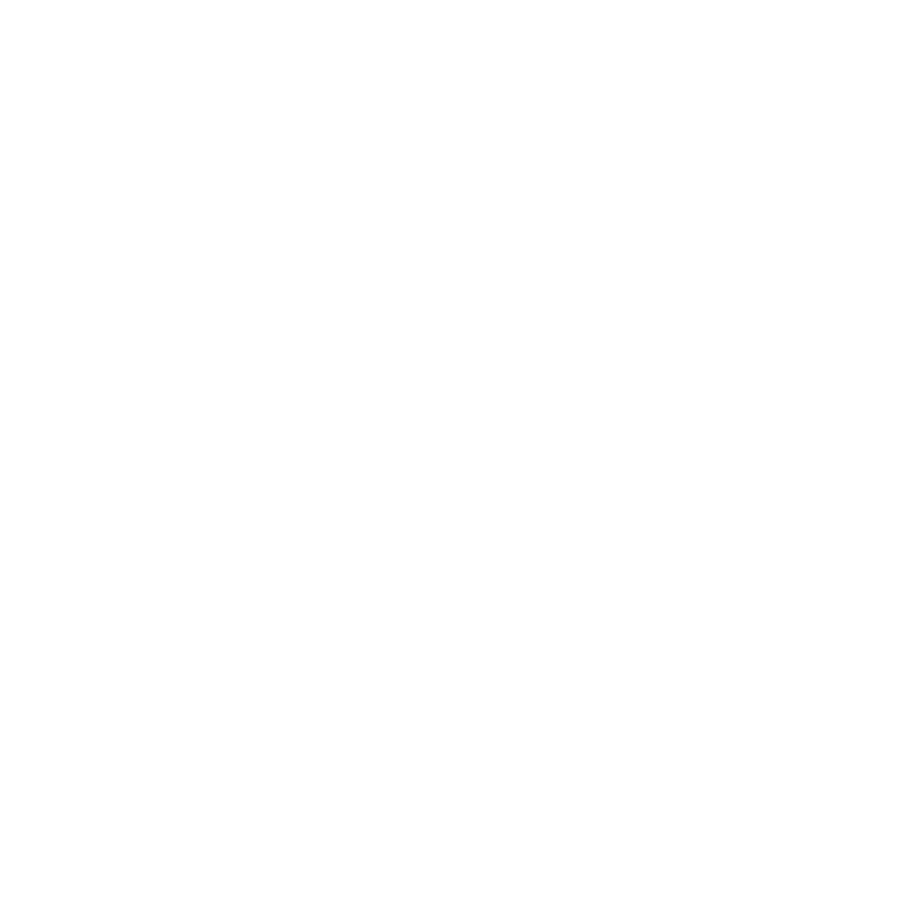

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2004.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2005 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


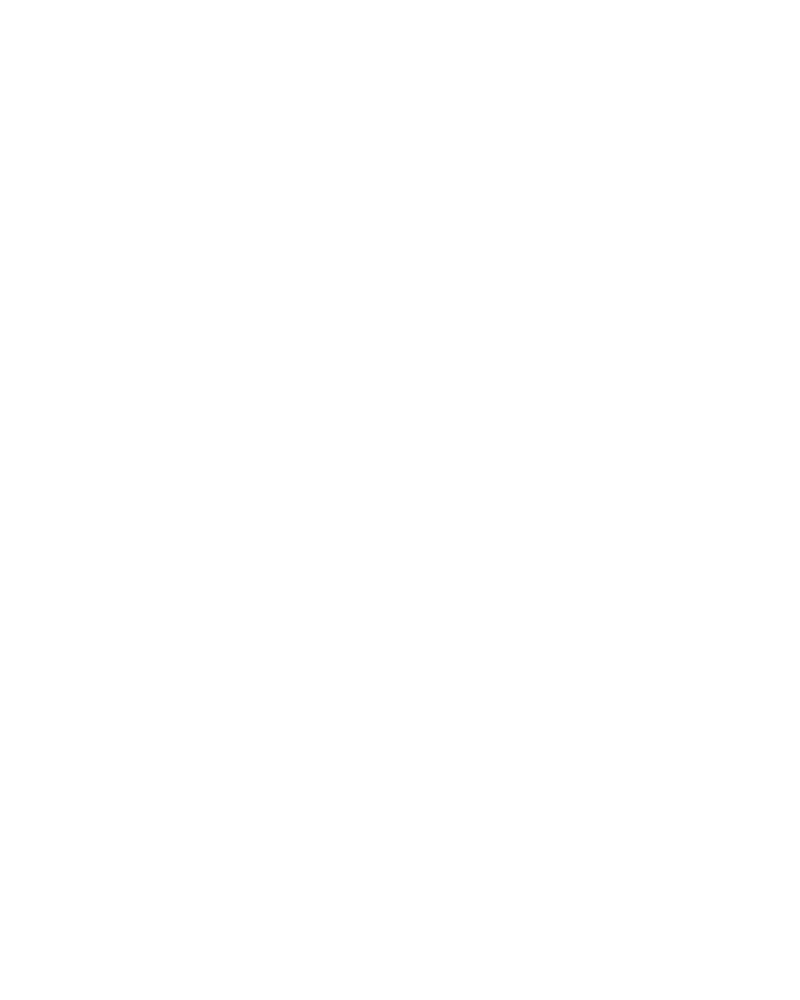

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2005.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 12.07


<IPython.core.display.Javascript object>


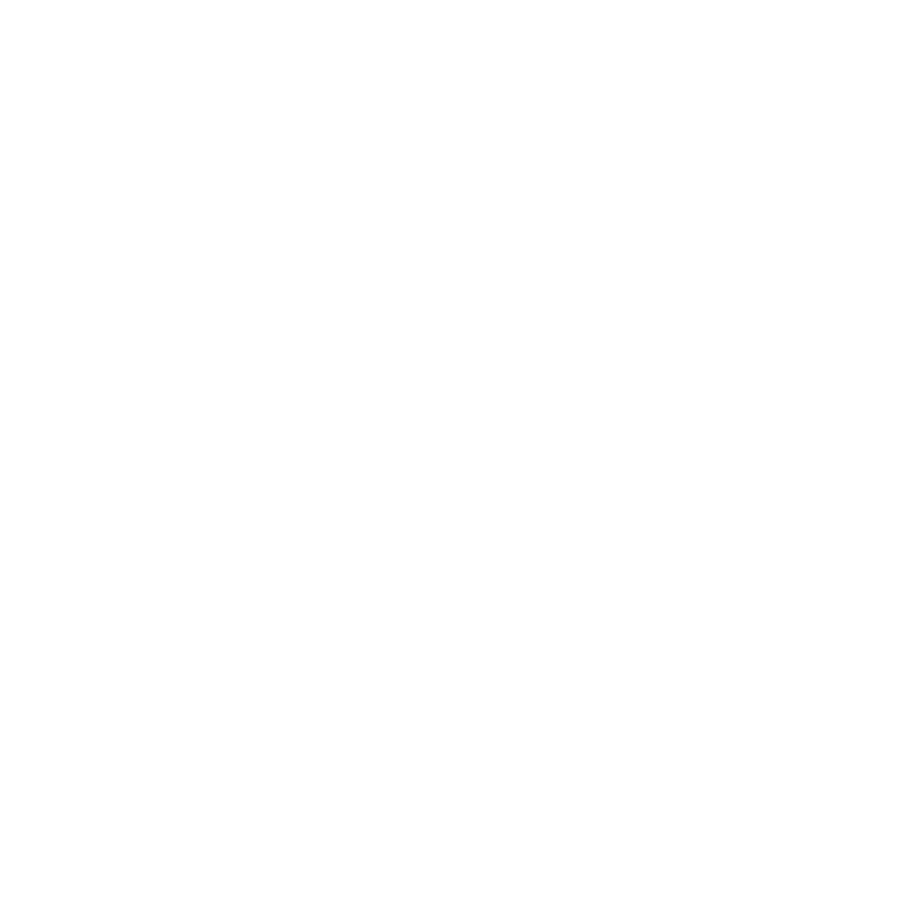

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2005.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2006 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


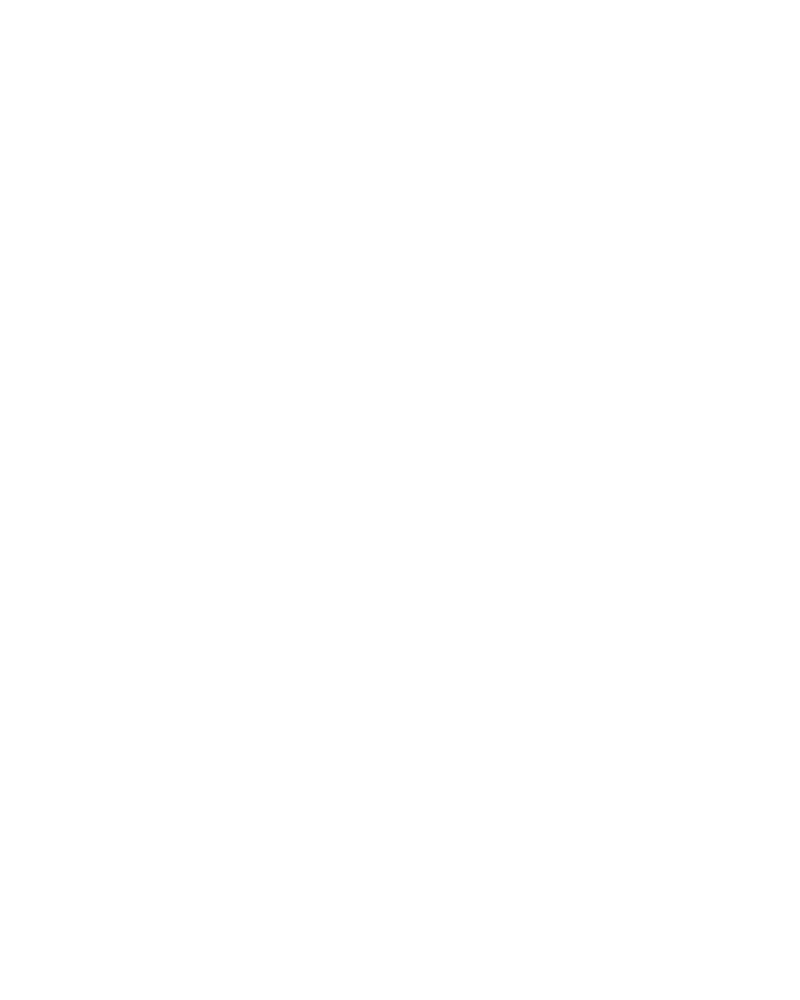

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2006.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 11.83


<IPython.core.display.Javascript object>


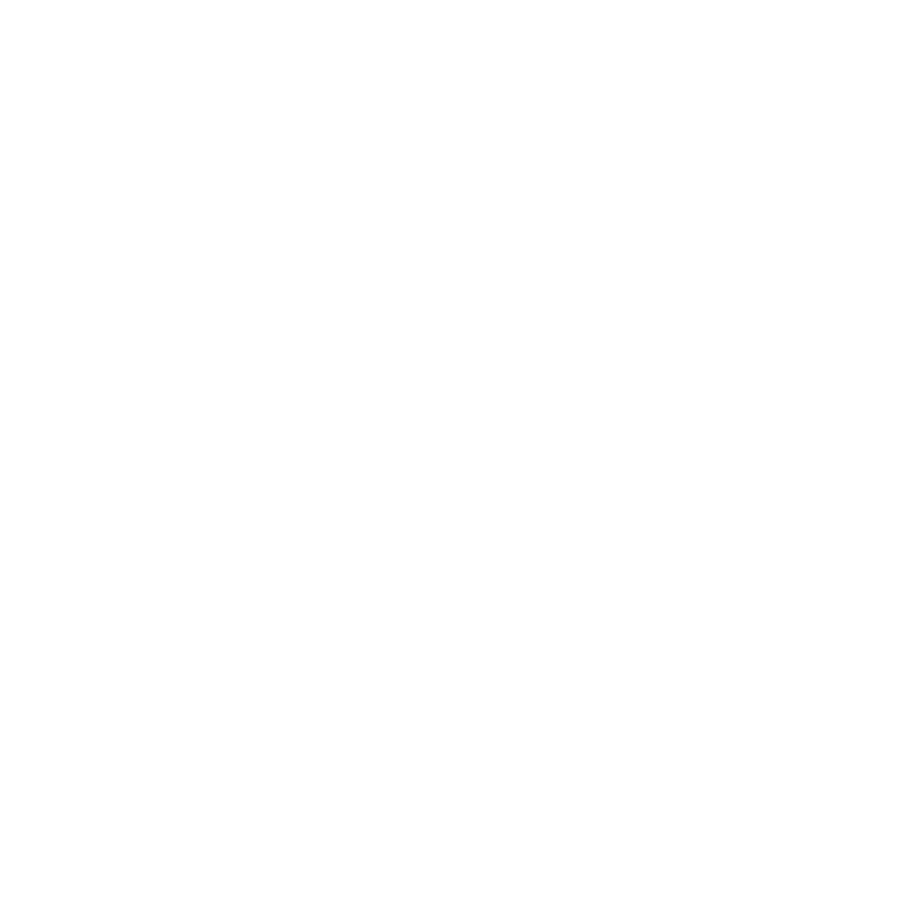

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2006.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2007 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


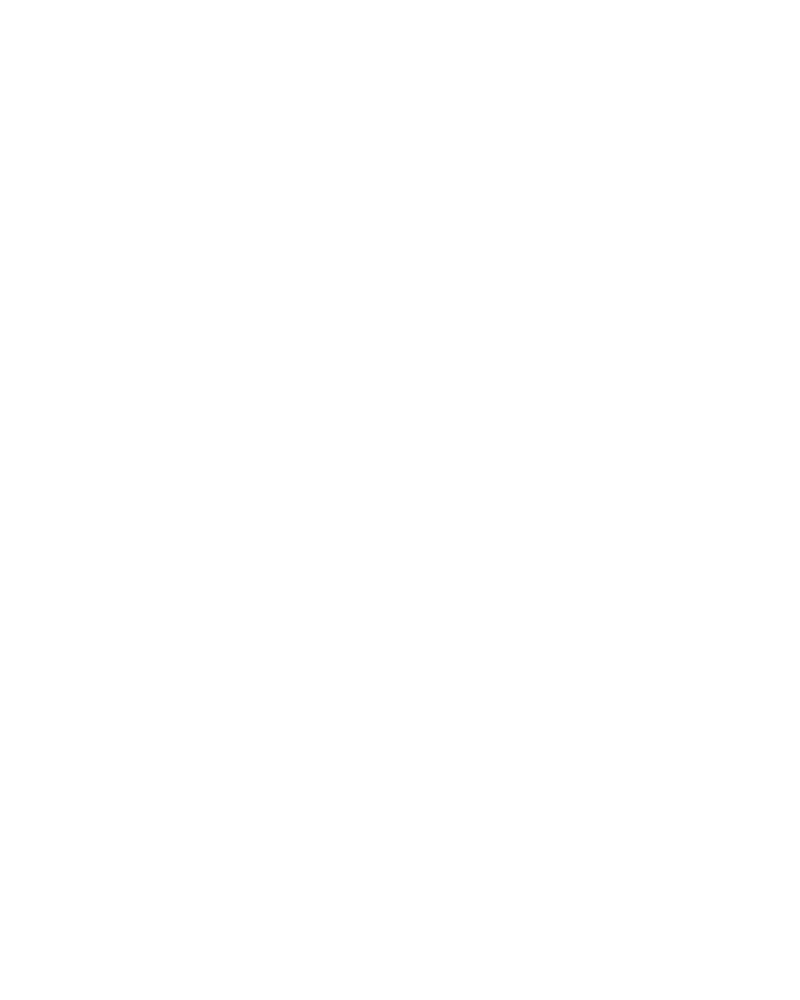

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2007.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 10.23


<IPython.core.display.Javascript object>


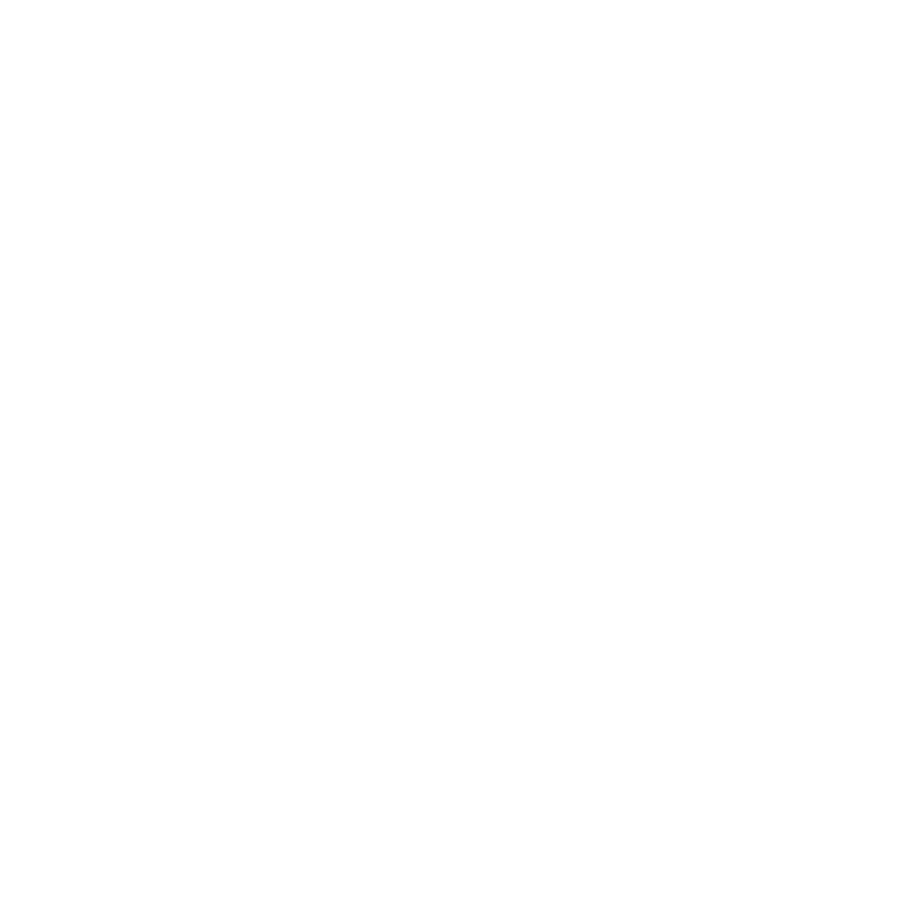

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2007.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2008 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


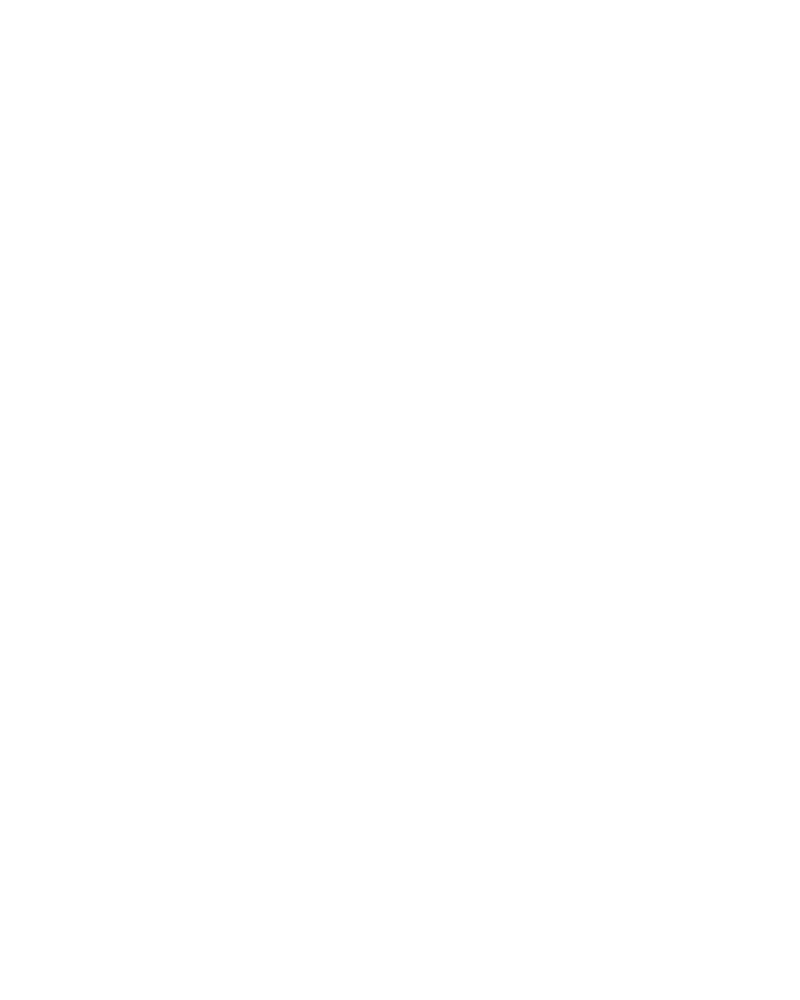

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 9.22


<IPython.core.display.Javascript object>


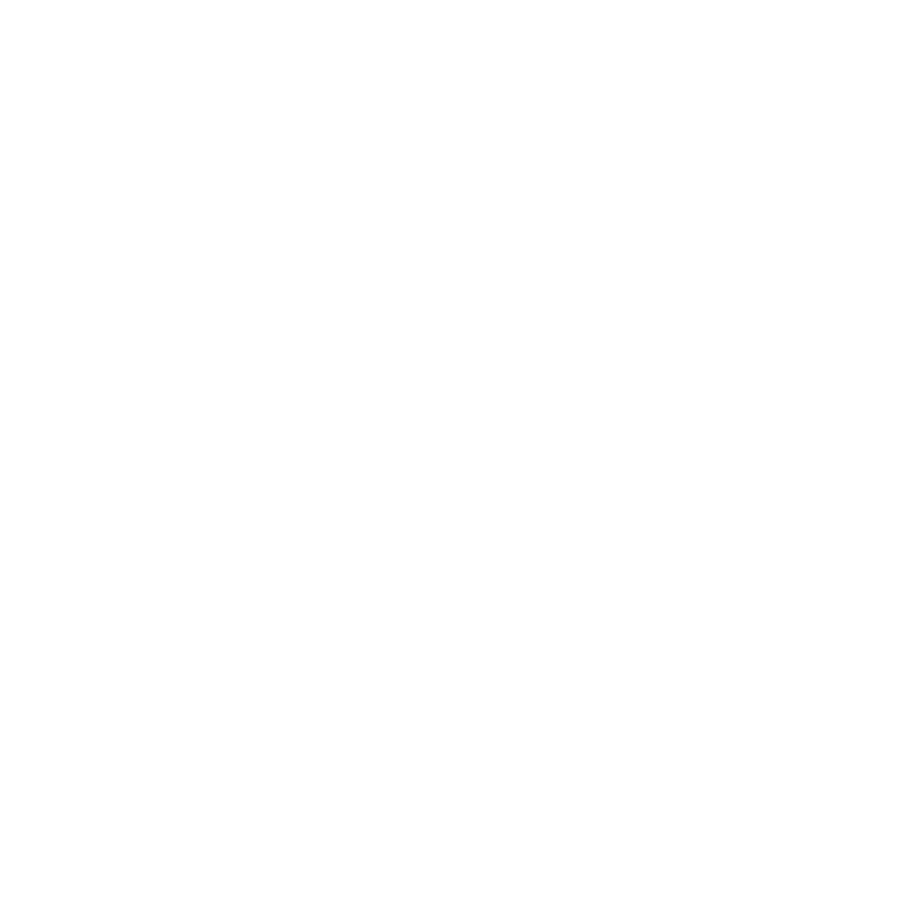

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2008.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2009 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


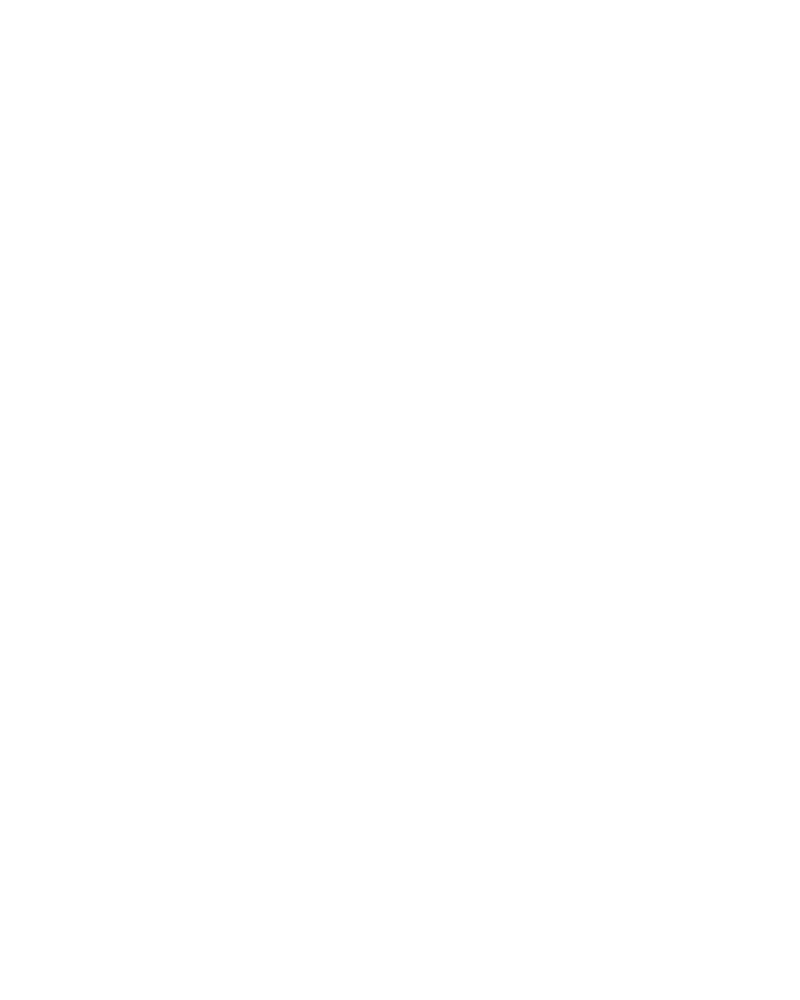

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 9.24


<IPython.core.display.Javascript object>


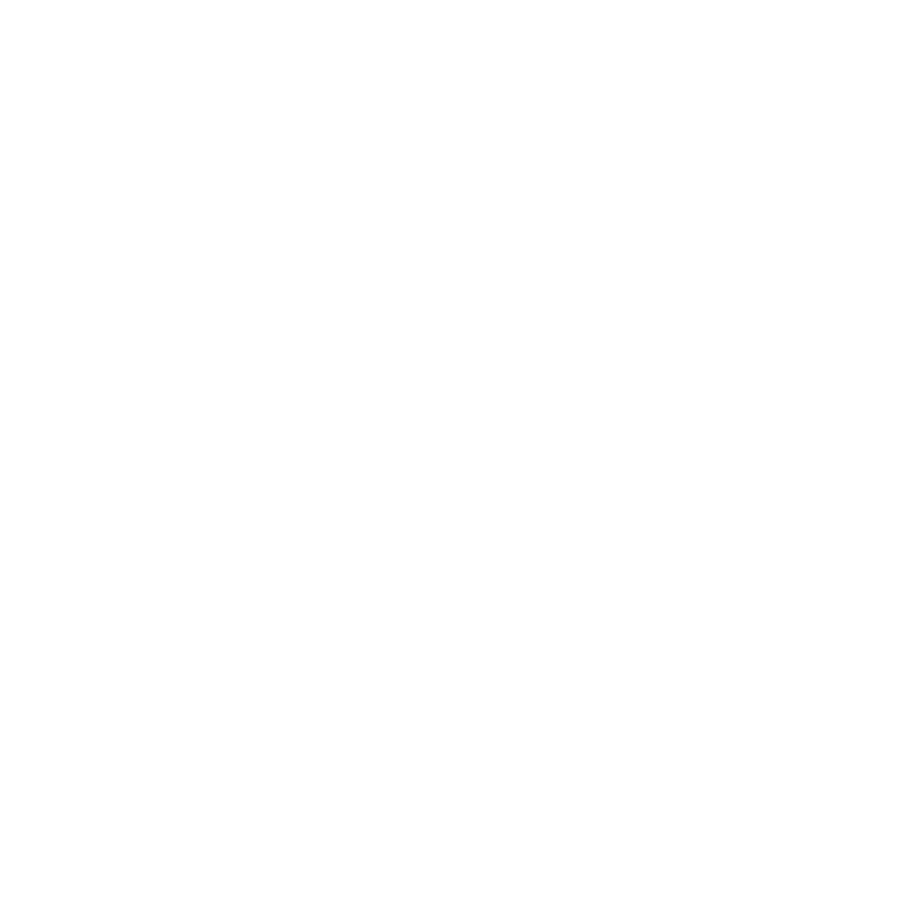

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2009.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2010 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


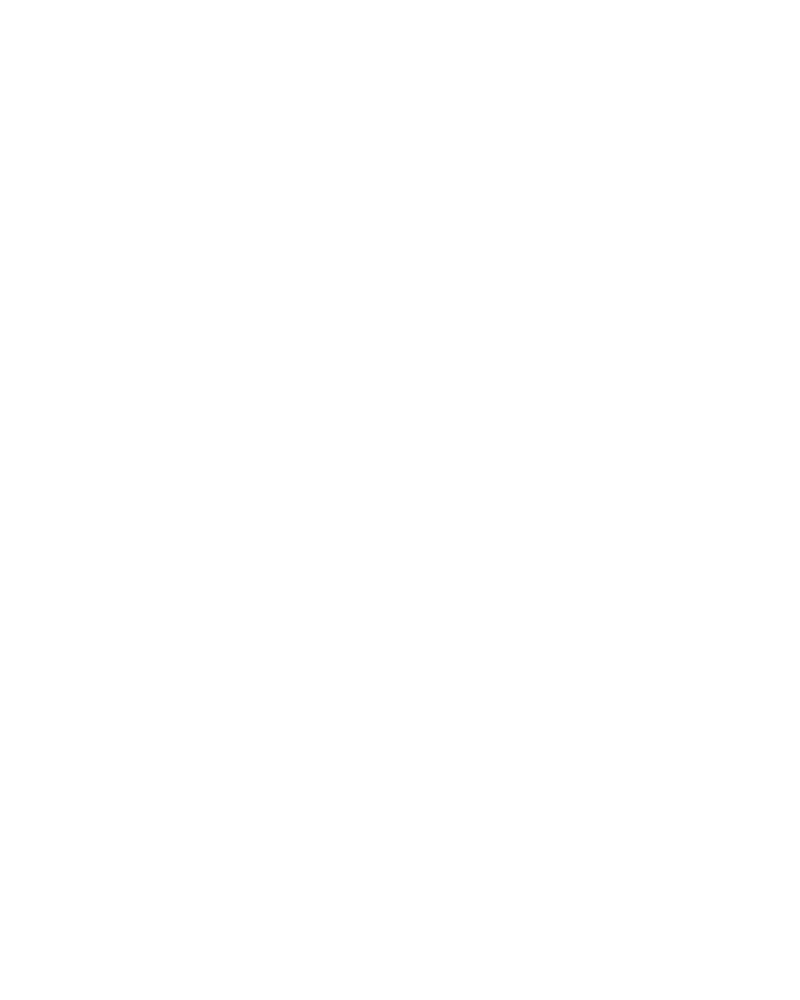

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 13.72


<IPython.core.display.Javascript object>


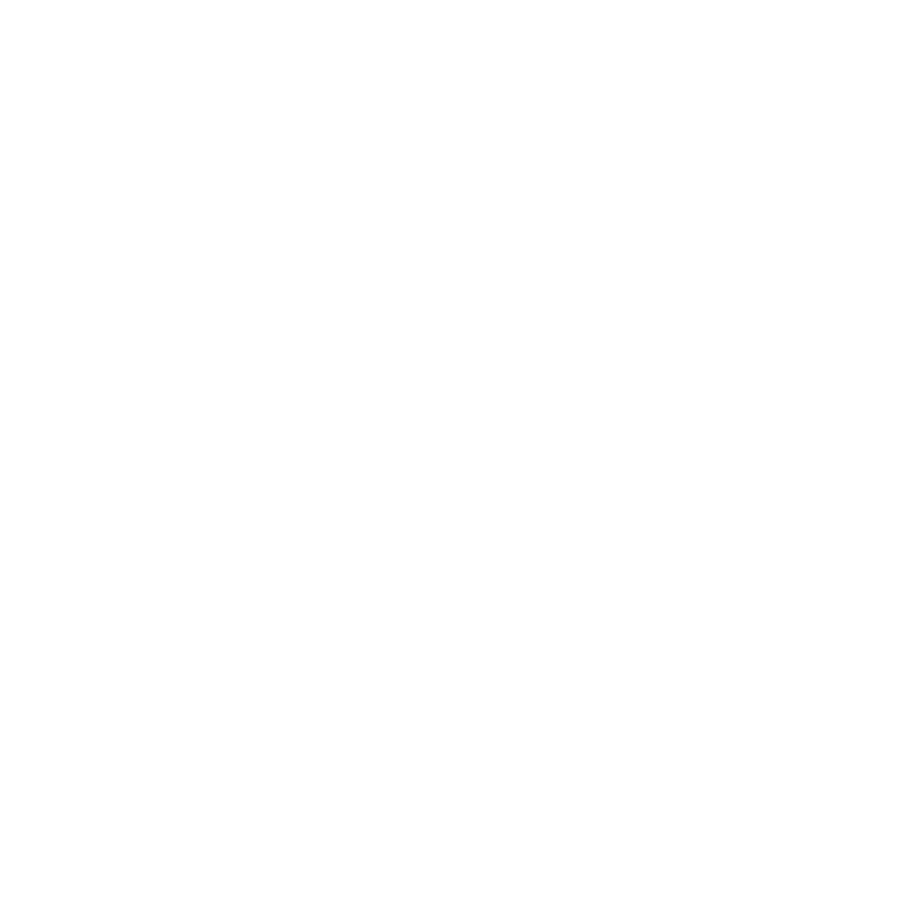

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2010.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2011 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


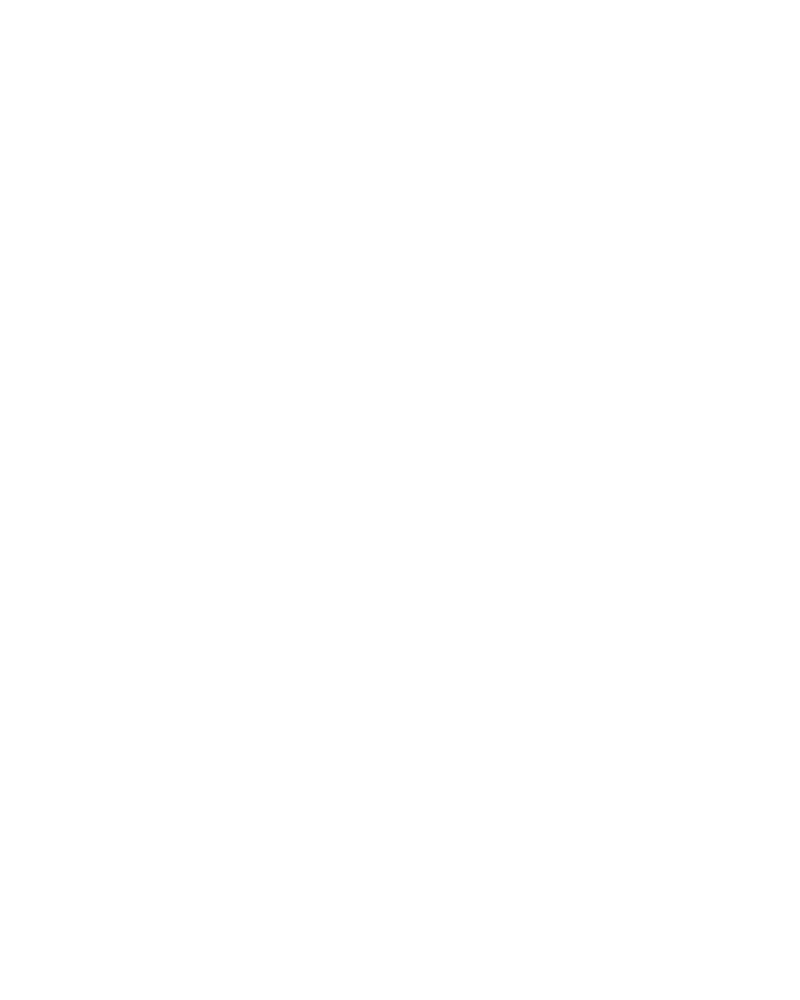

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 9.88


<IPython.core.display.Javascript object>


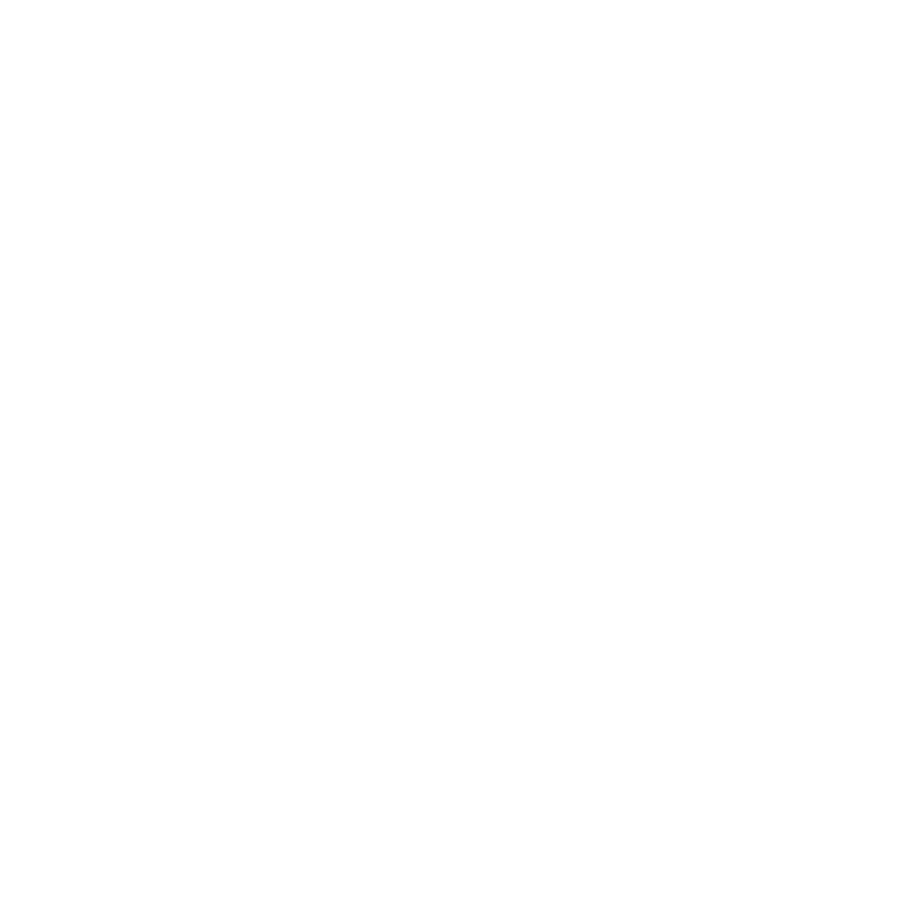

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2011.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2012 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


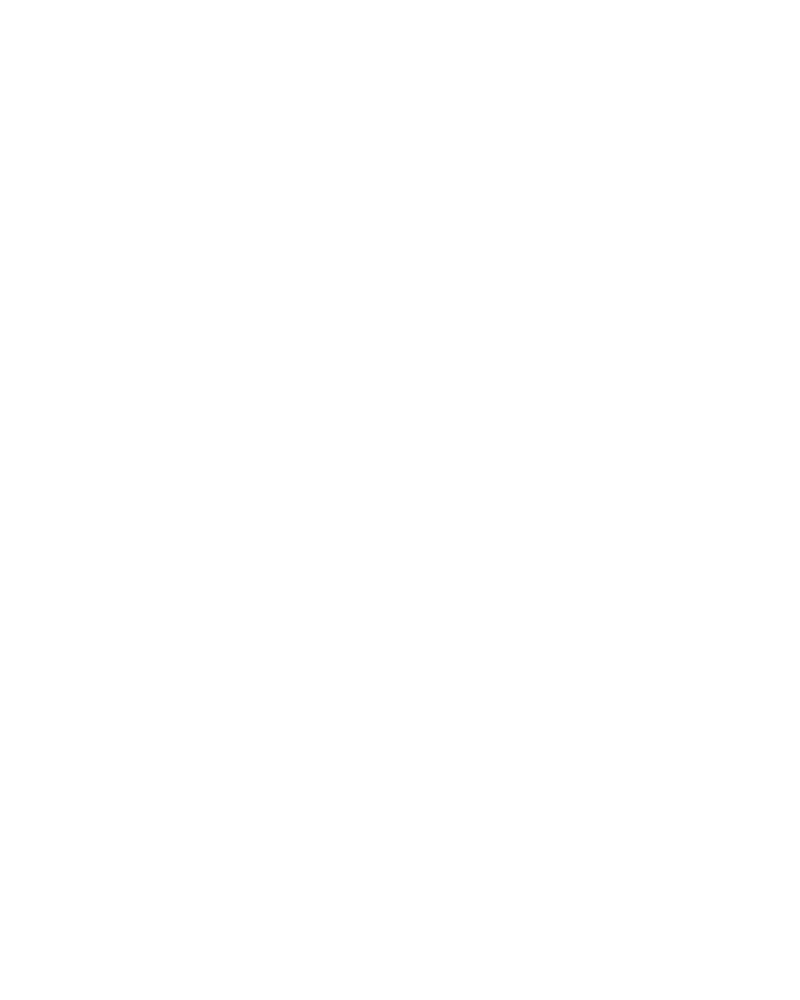

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 10.00


<IPython.core.display.Javascript object>


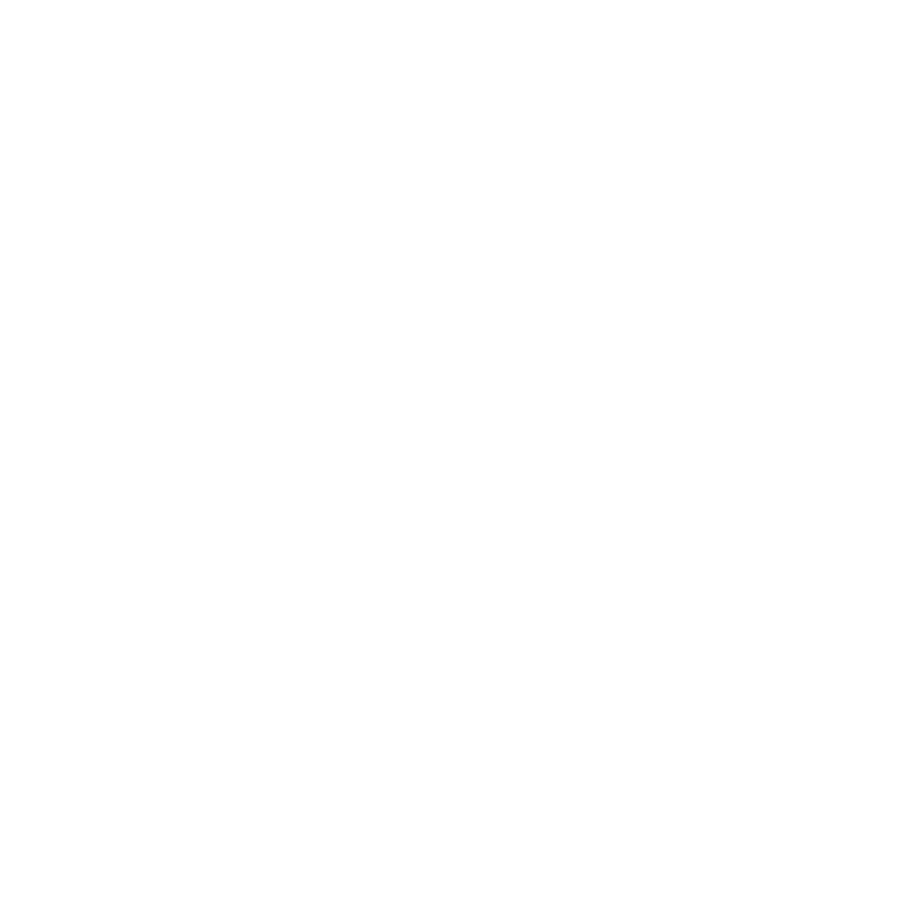

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2012.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2013 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


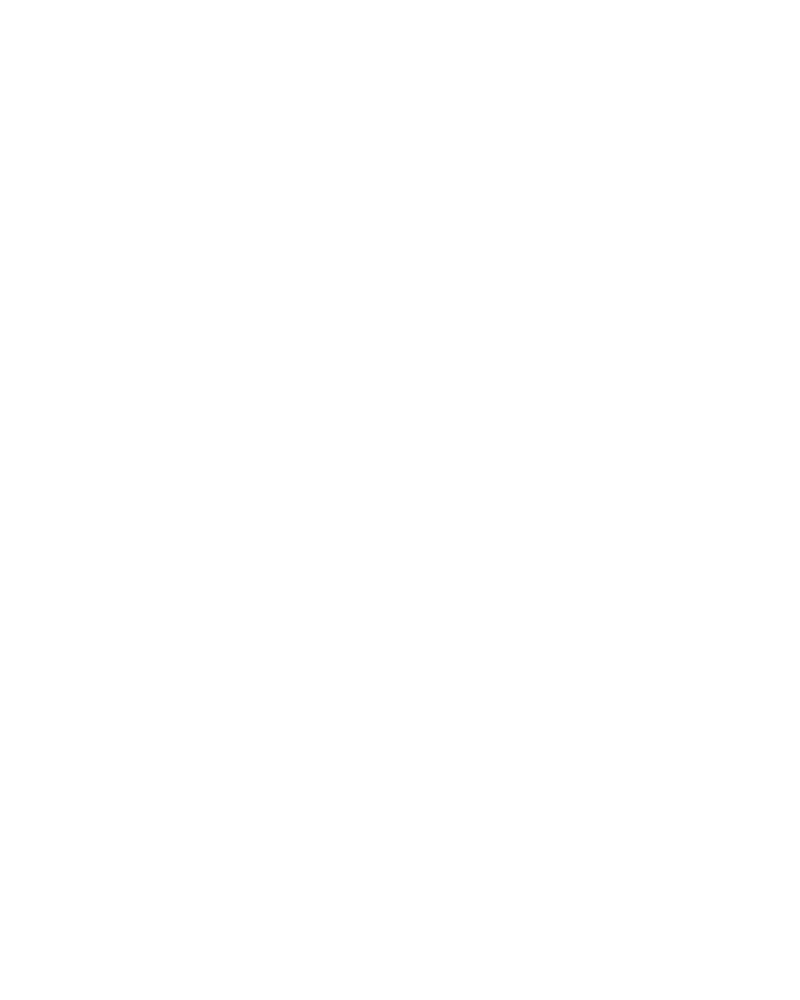

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 11.65


<IPython.core.display.Javascript object>


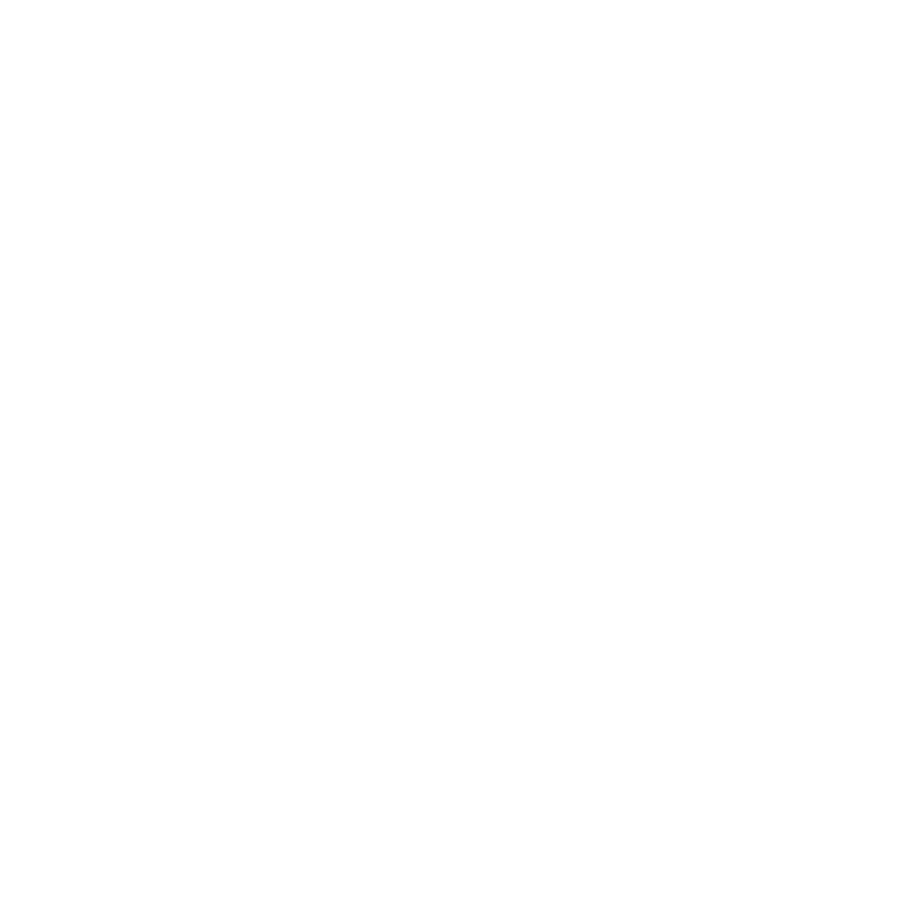

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2013.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
IN_Hunza_at_DainyorBridge : 2014 : model=9.77_11.21_26.08_32.22


<IPython.core.display.Javascript object>


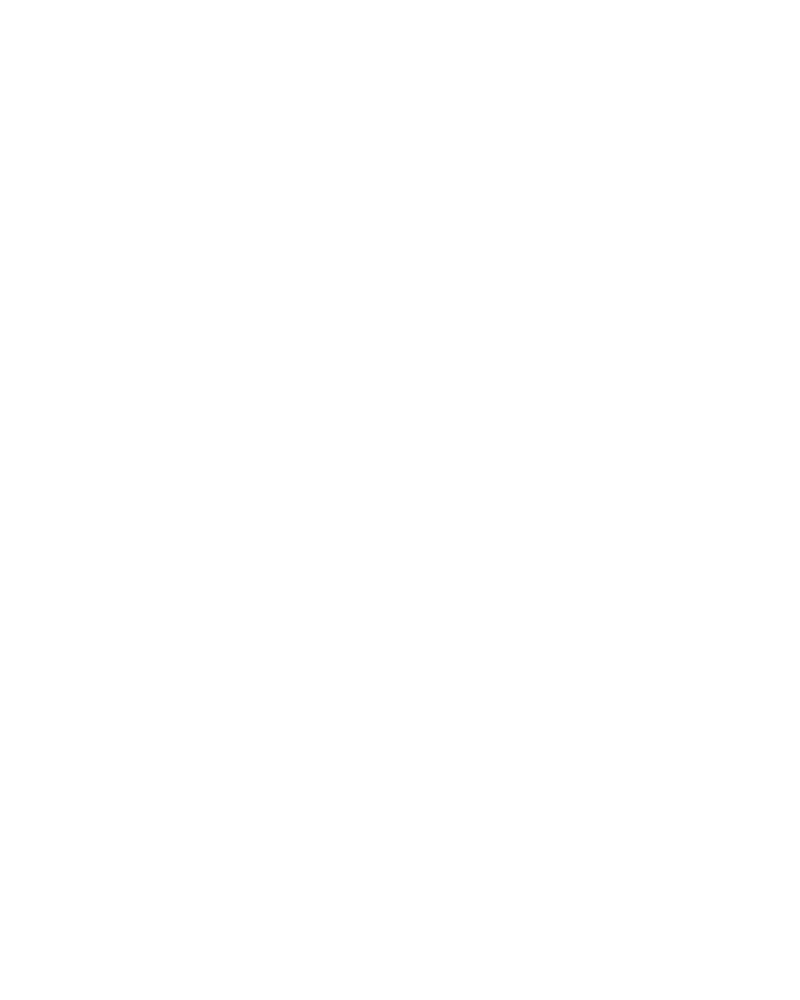

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_hyps.png
total melt = 9.32


<IPython.core.display.Javascript object>


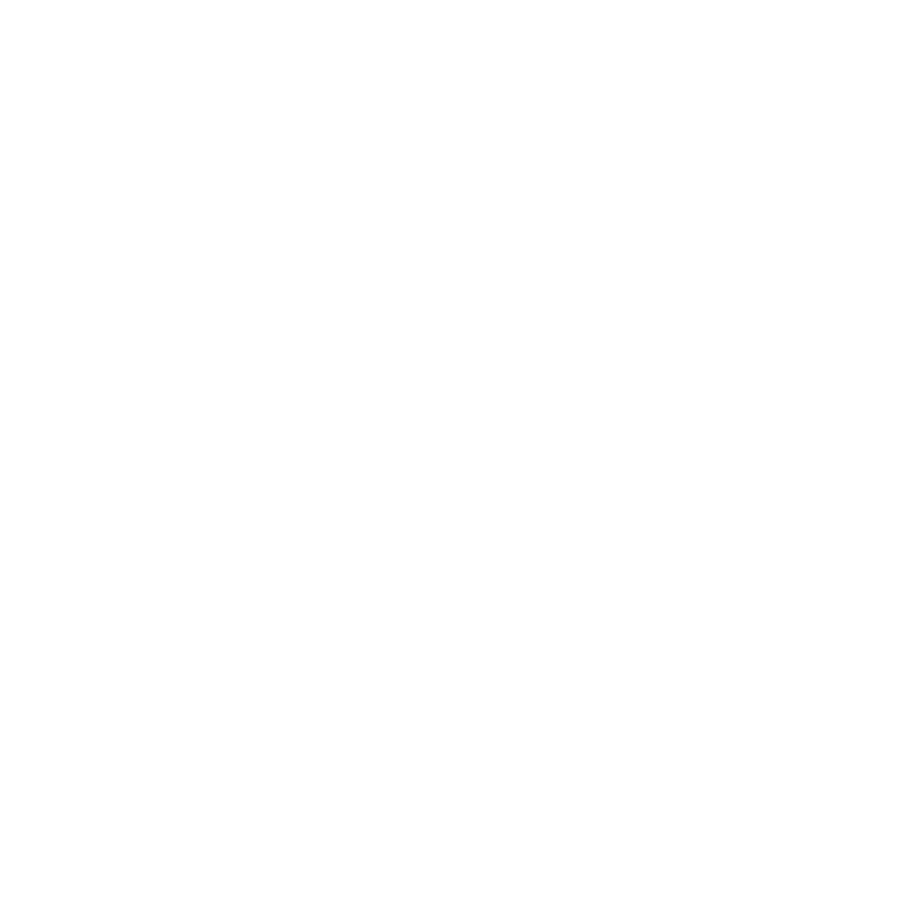

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/IN_Hunza_at_DainyorBridge/IN_Hunza_at_DainyorBridge.2014.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Hunza_SA_model.melt_tseries.png
drainageID=AM_Vakhsh_at_Komsomolabad, majorID=AM, model=2.88_4.43_37.07_56.48, label=best_Vakhsh_SA_model
AM_Vakhsh_at_Komsomolabad : 2001 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


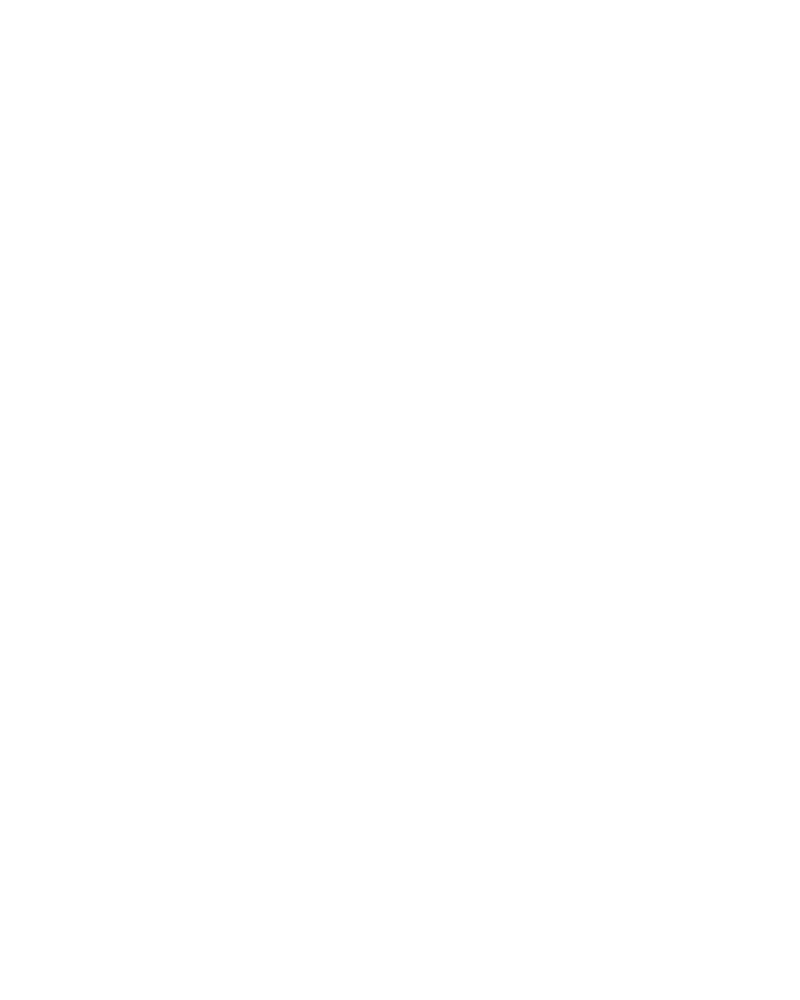

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 16.26


<IPython.core.display.Javascript object>


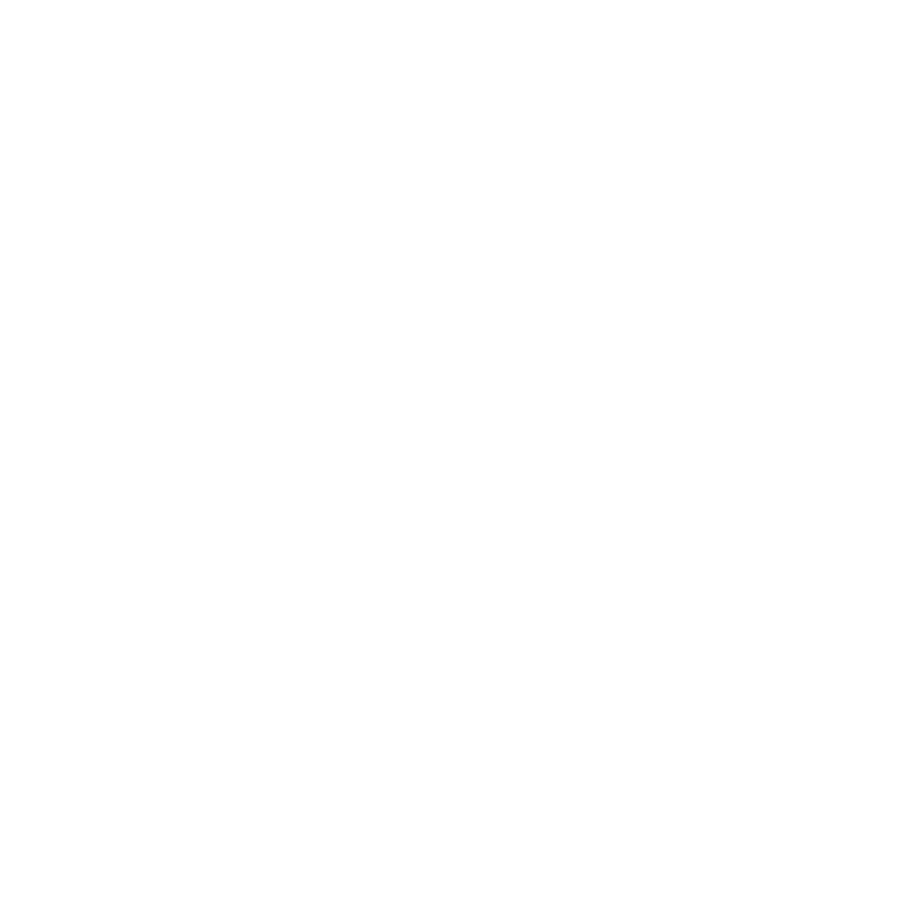

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2001.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2002 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


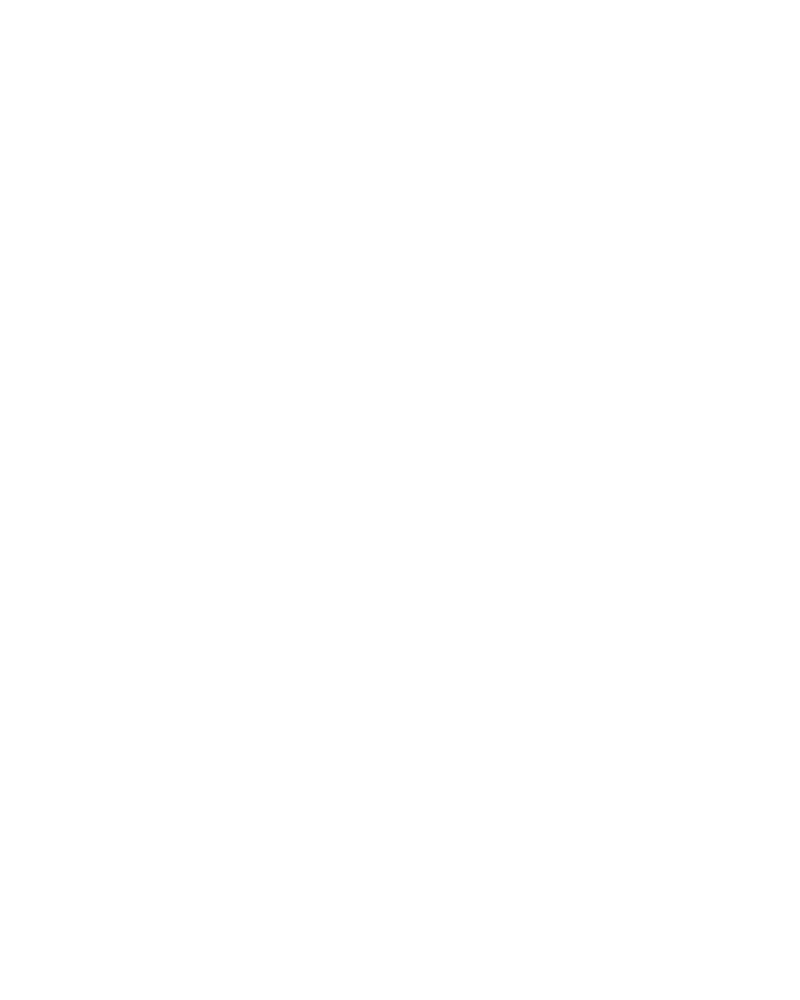

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2002.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 20.85


<IPython.core.display.Javascript object>


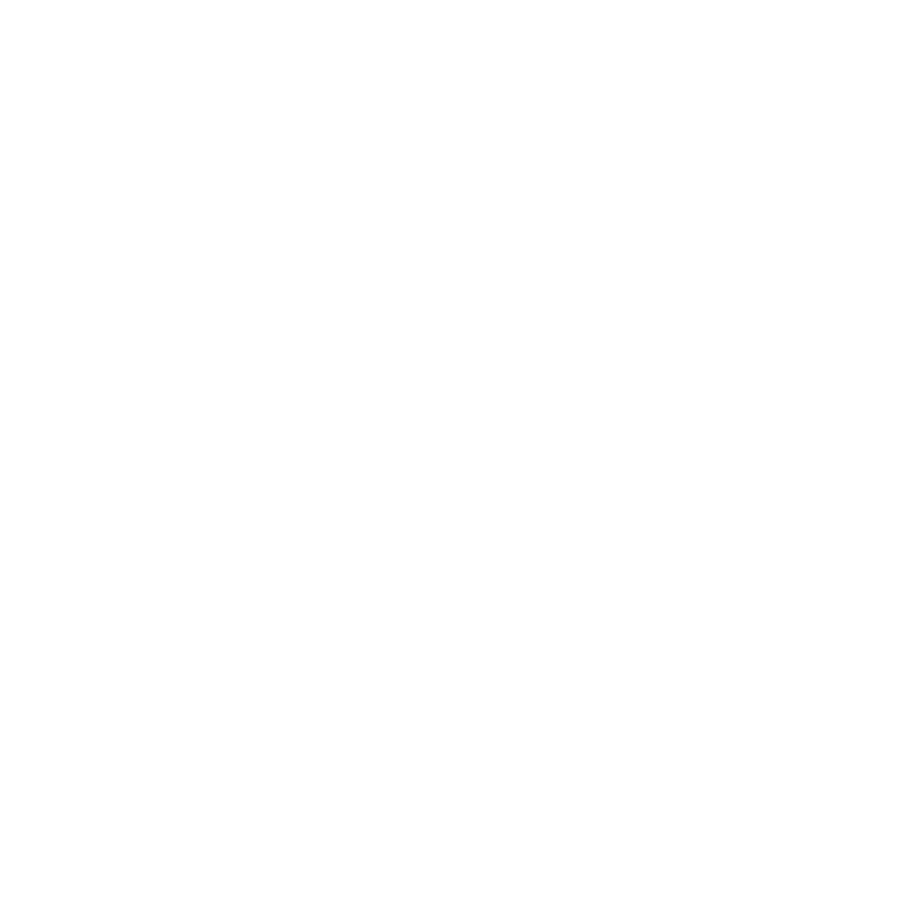

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2002.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2003 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


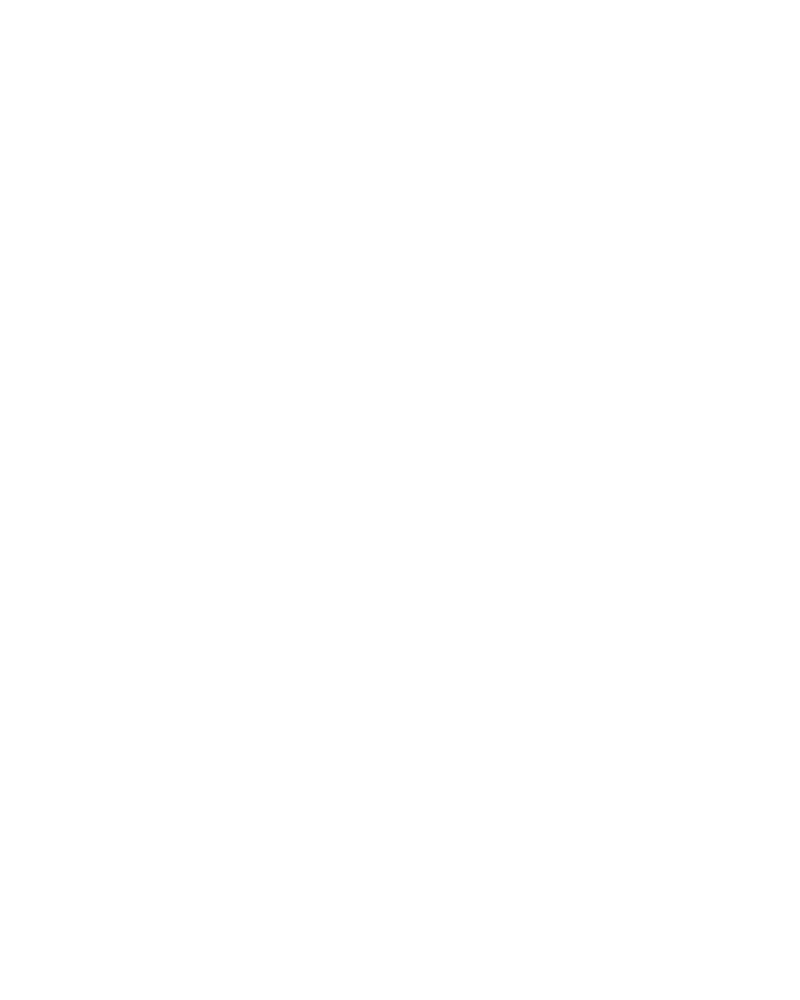

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2003.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 17.04


<IPython.core.display.Javascript object>


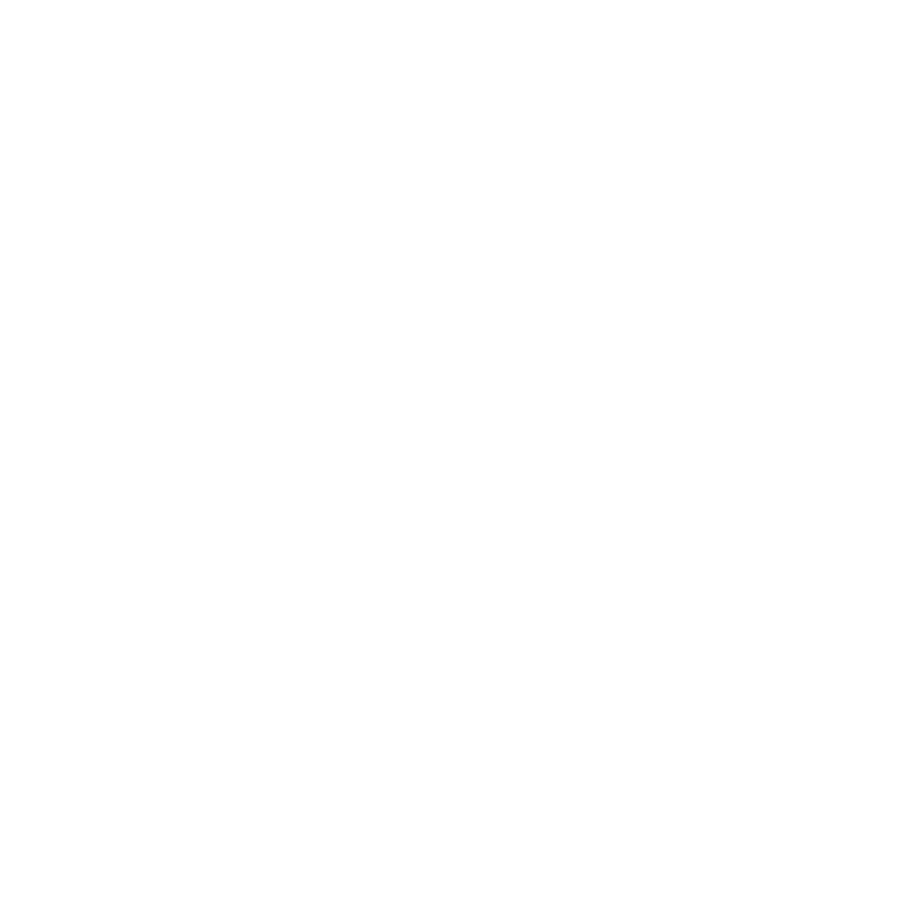

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2003.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2004 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


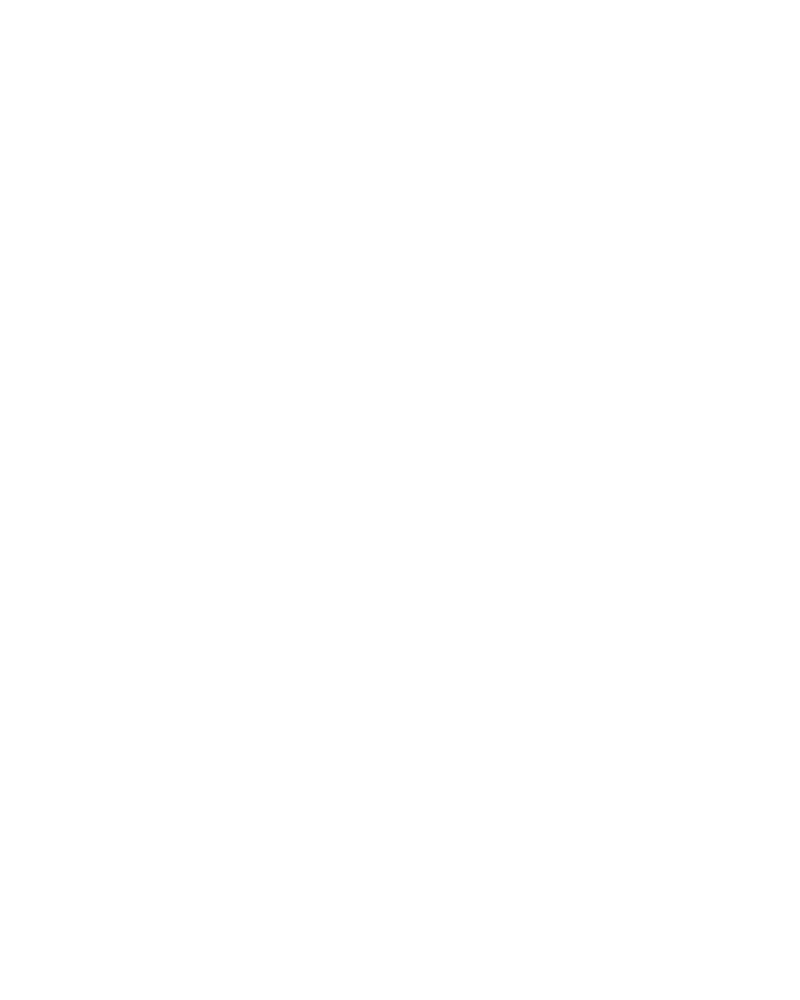

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2004.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 20.82


<IPython.core.display.Javascript object>


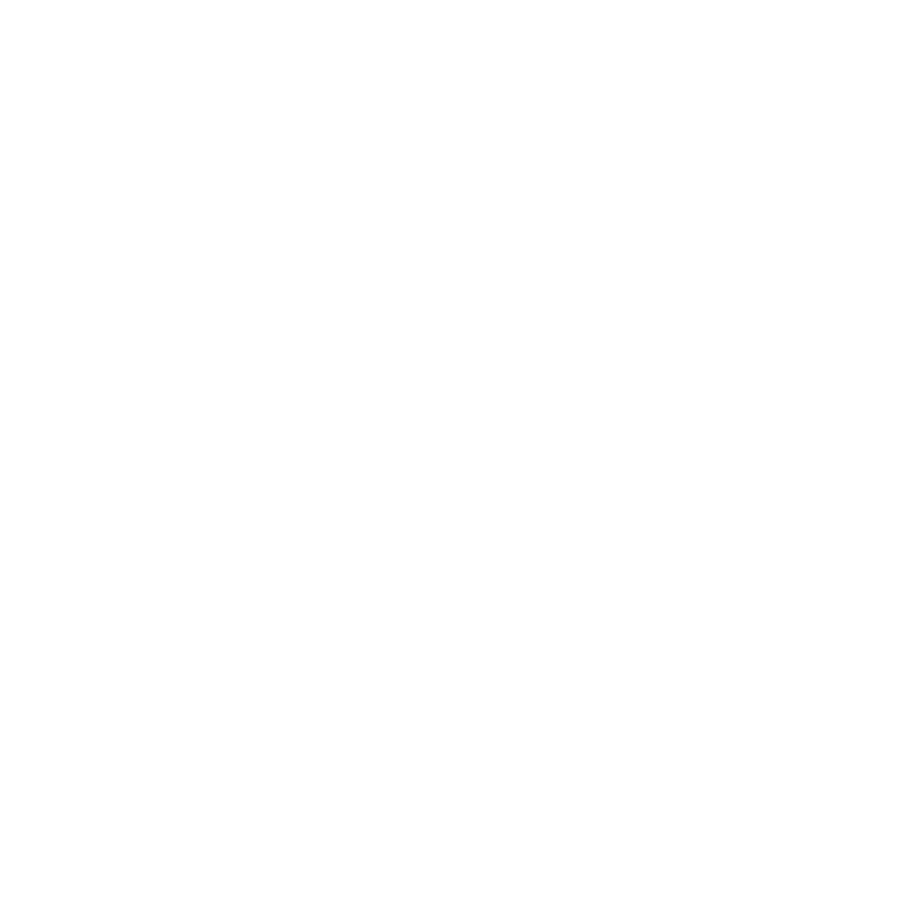

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2004.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2005 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


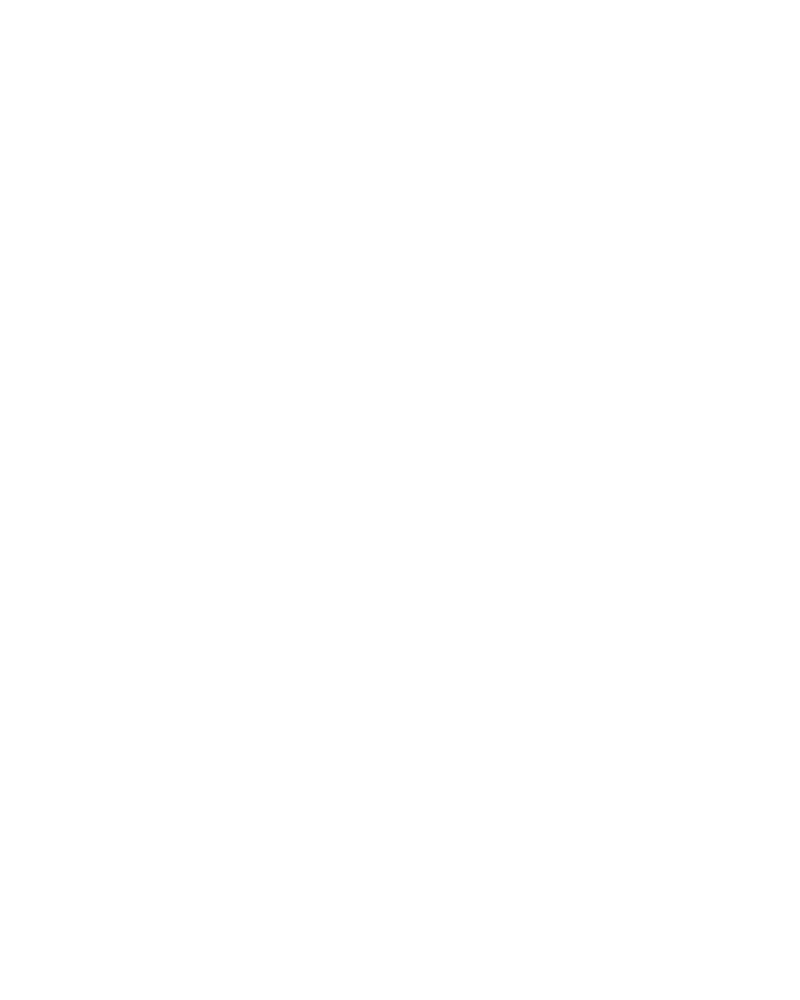

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2005.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 19.64


<IPython.core.display.Javascript object>


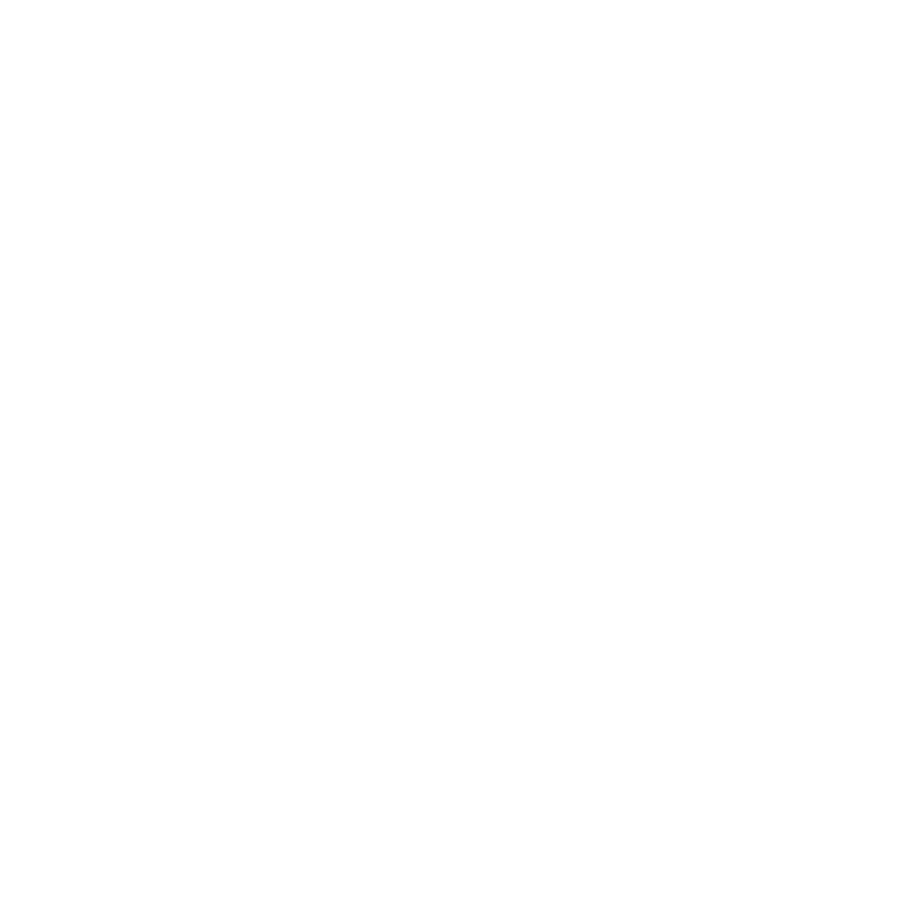

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2005.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2006 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


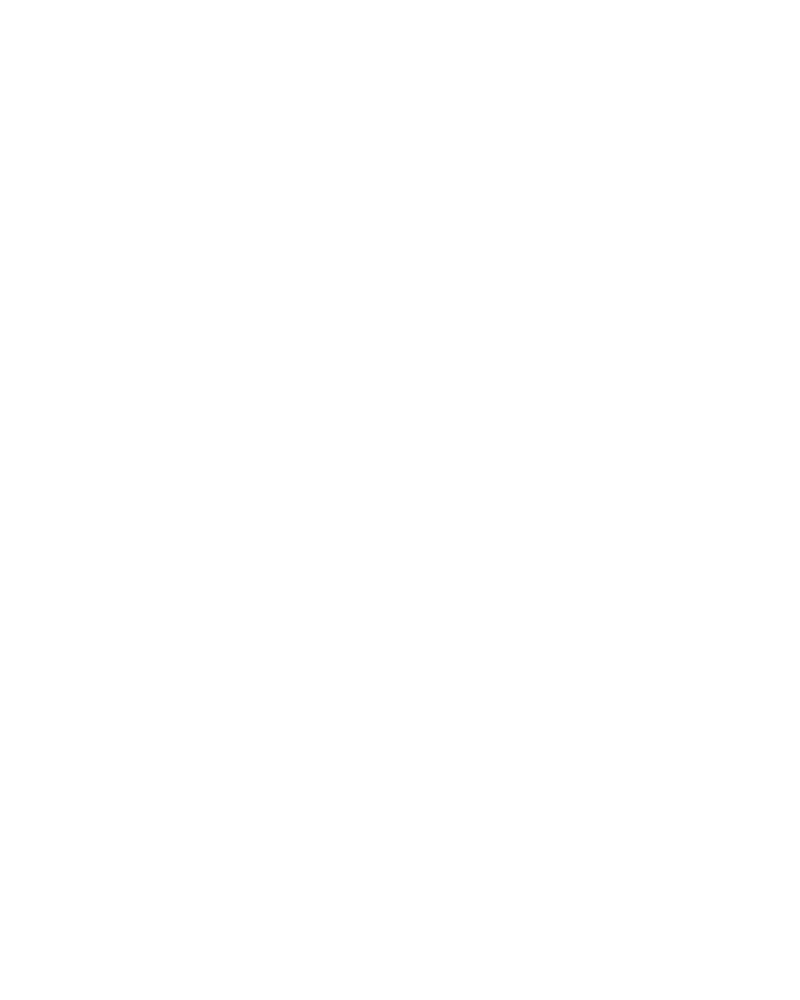

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2006.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 19.49


<IPython.core.display.Javascript object>


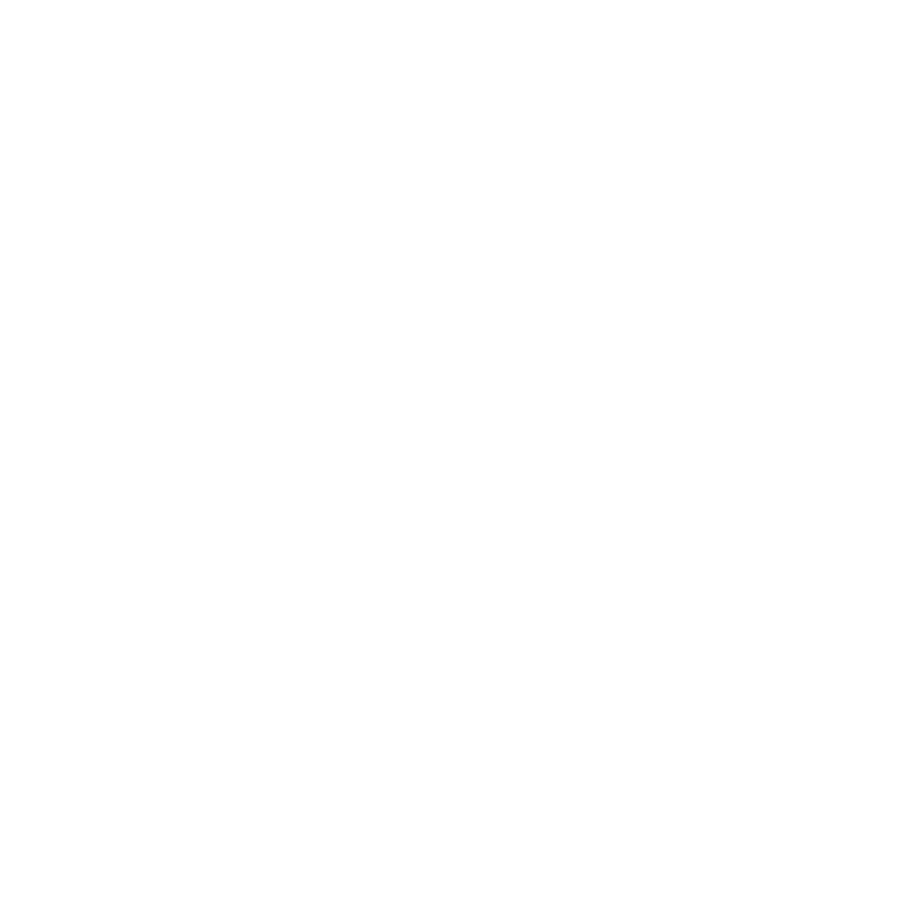

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2006.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2007 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


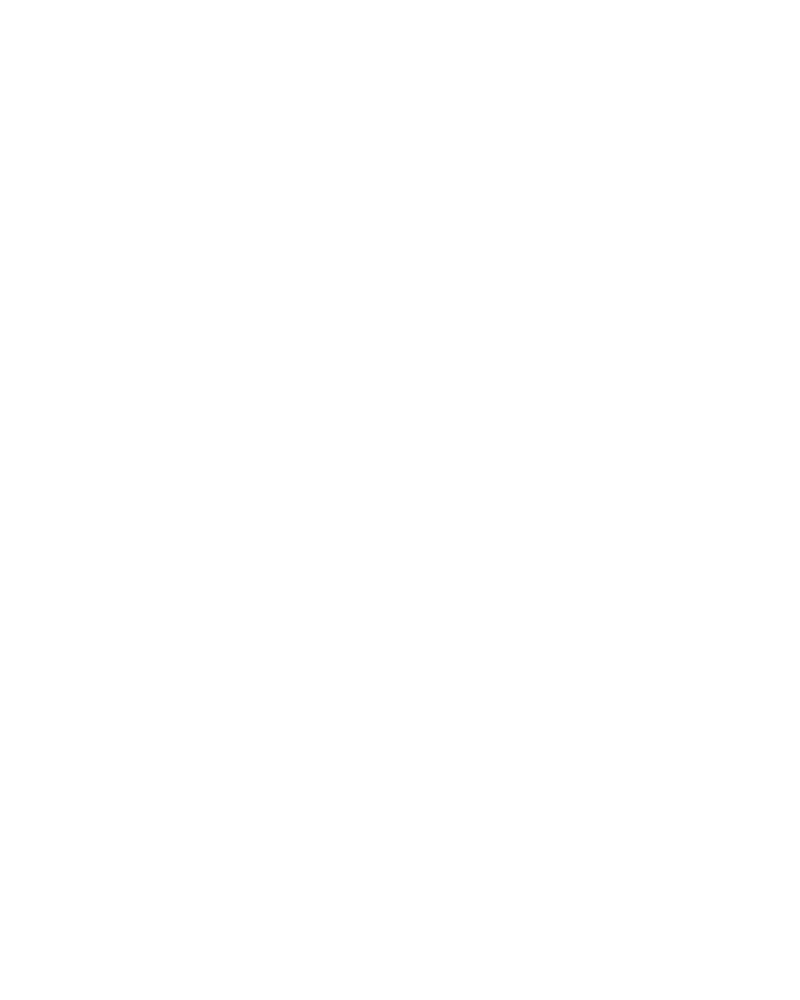

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2007.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 19.07


<IPython.core.display.Javascript object>


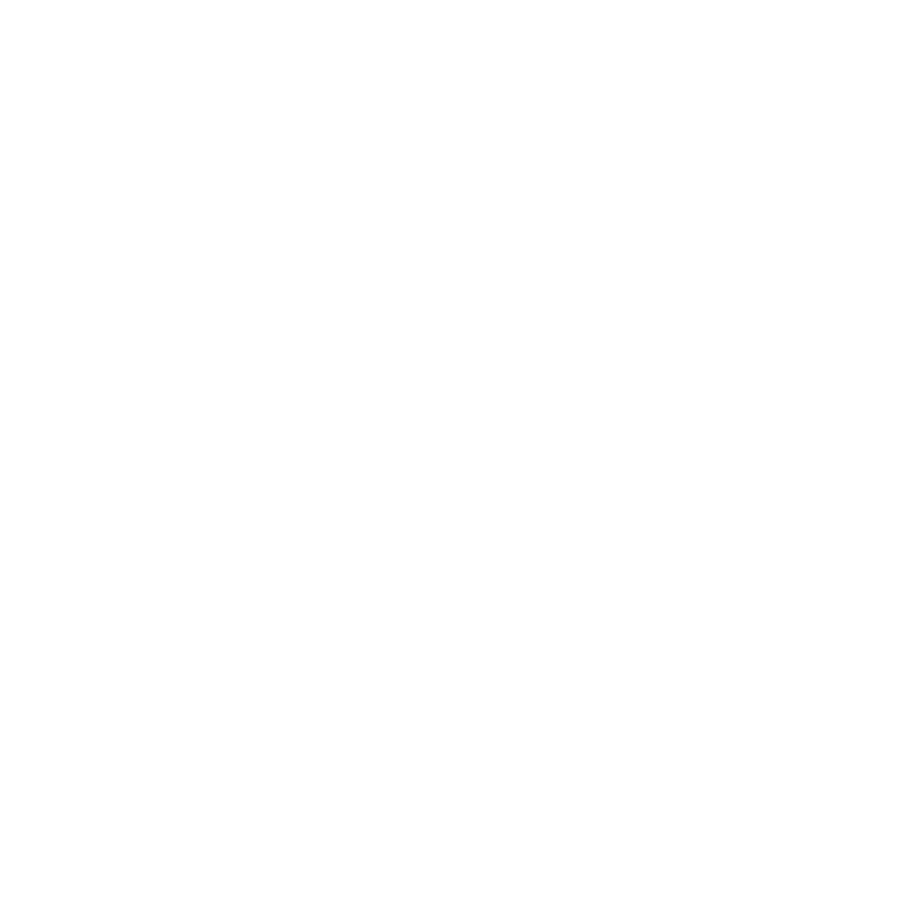

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2007.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2008 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


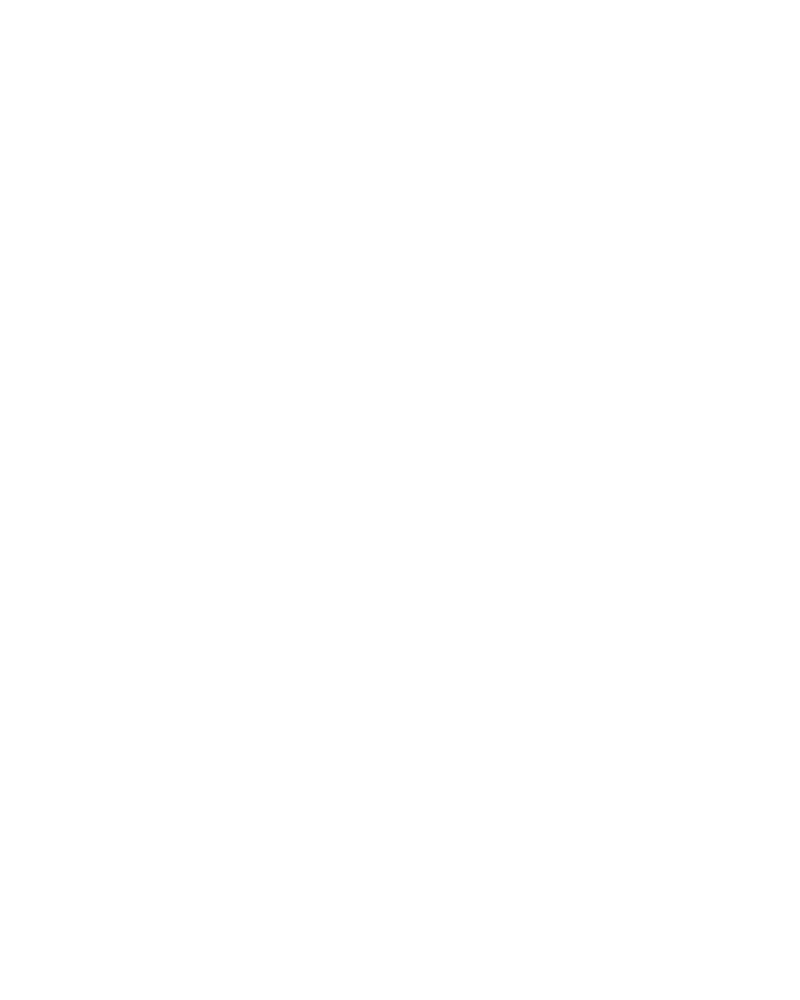

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 13.22


<IPython.core.display.Javascript object>


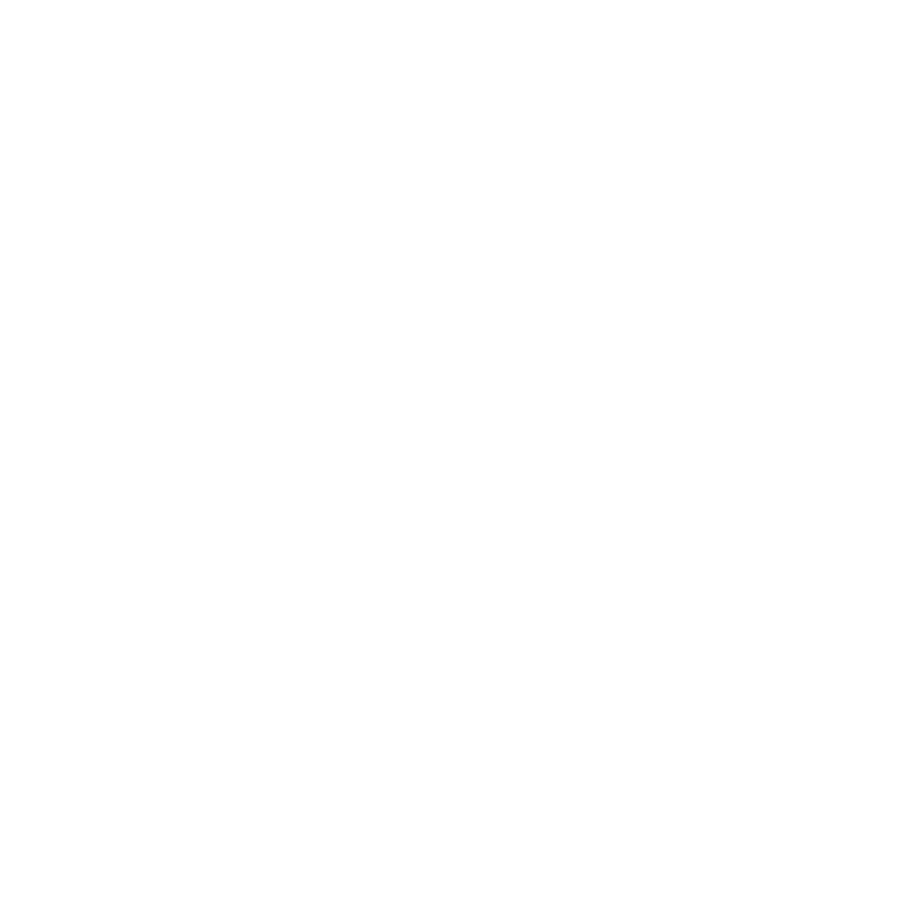

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2008.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2009 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


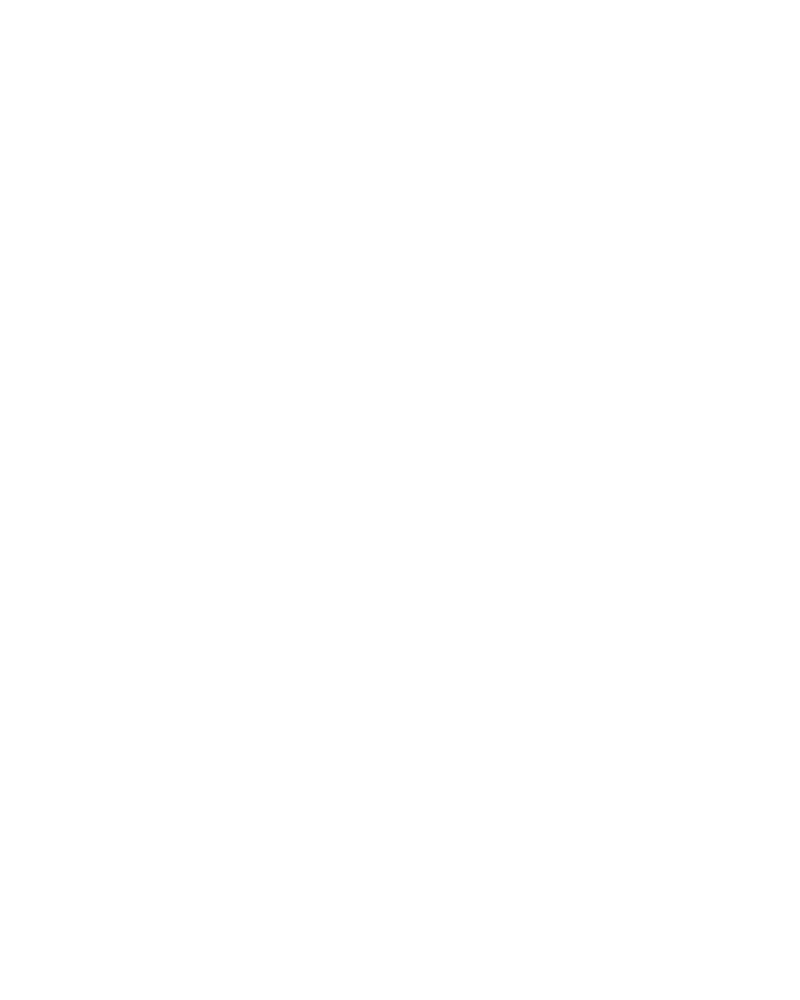

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 16.84


<IPython.core.display.Javascript object>


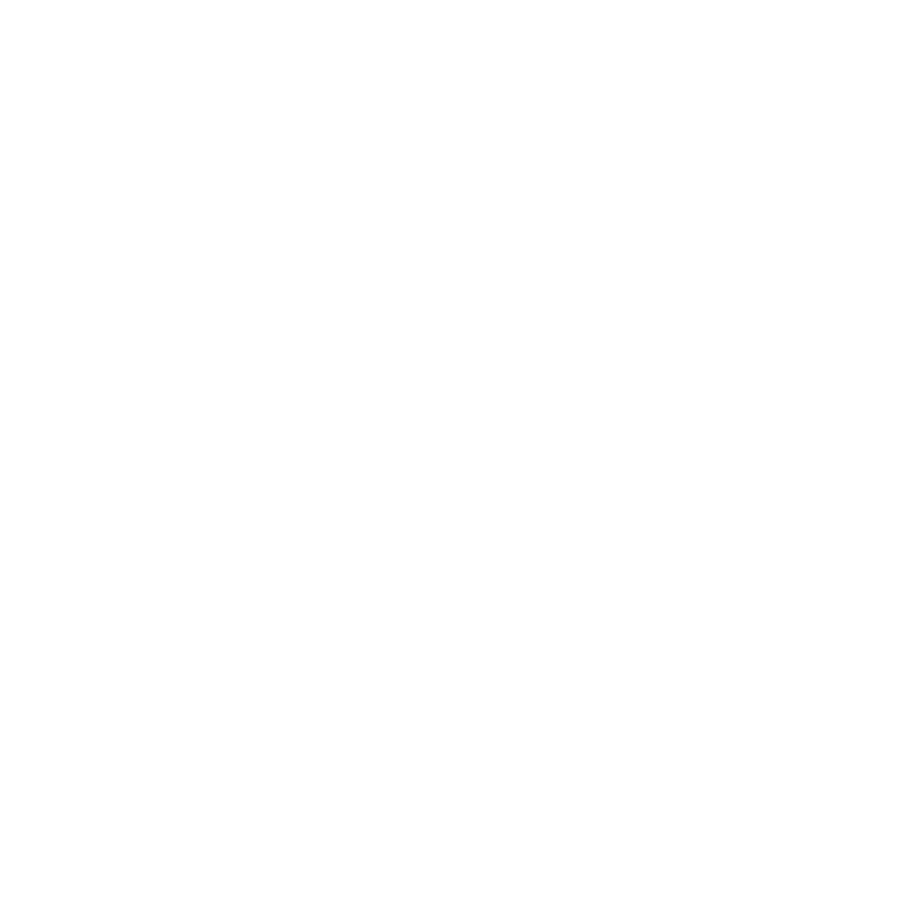

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2009.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2010 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


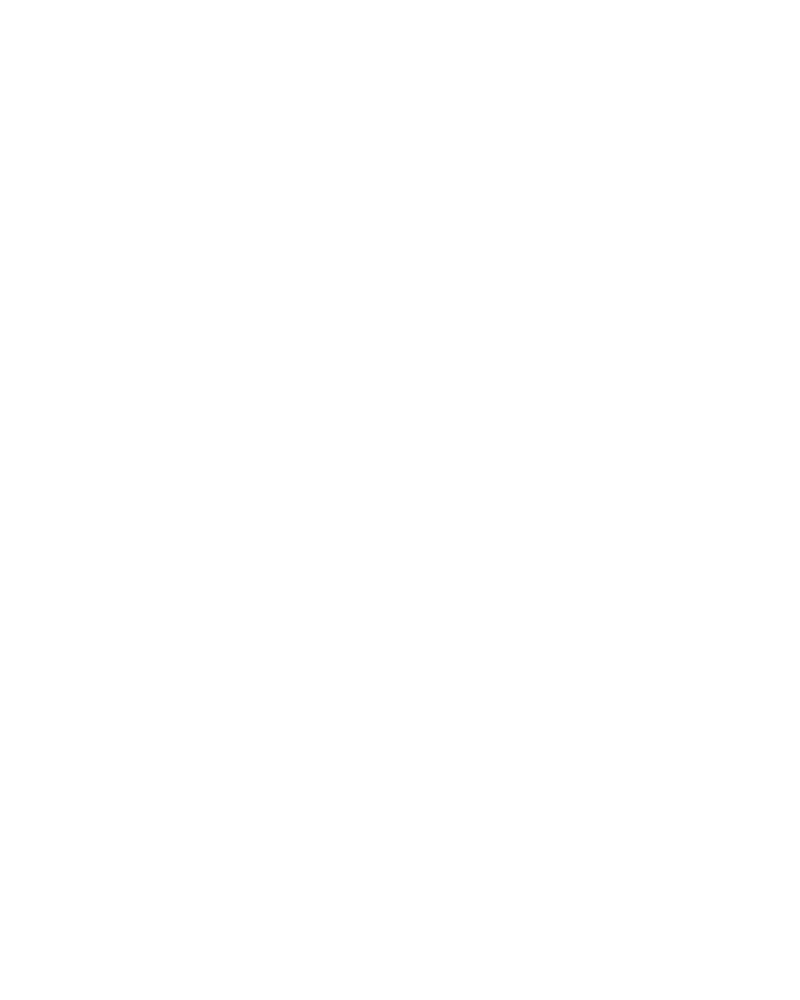

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 21.07


<IPython.core.display.Javascript object>


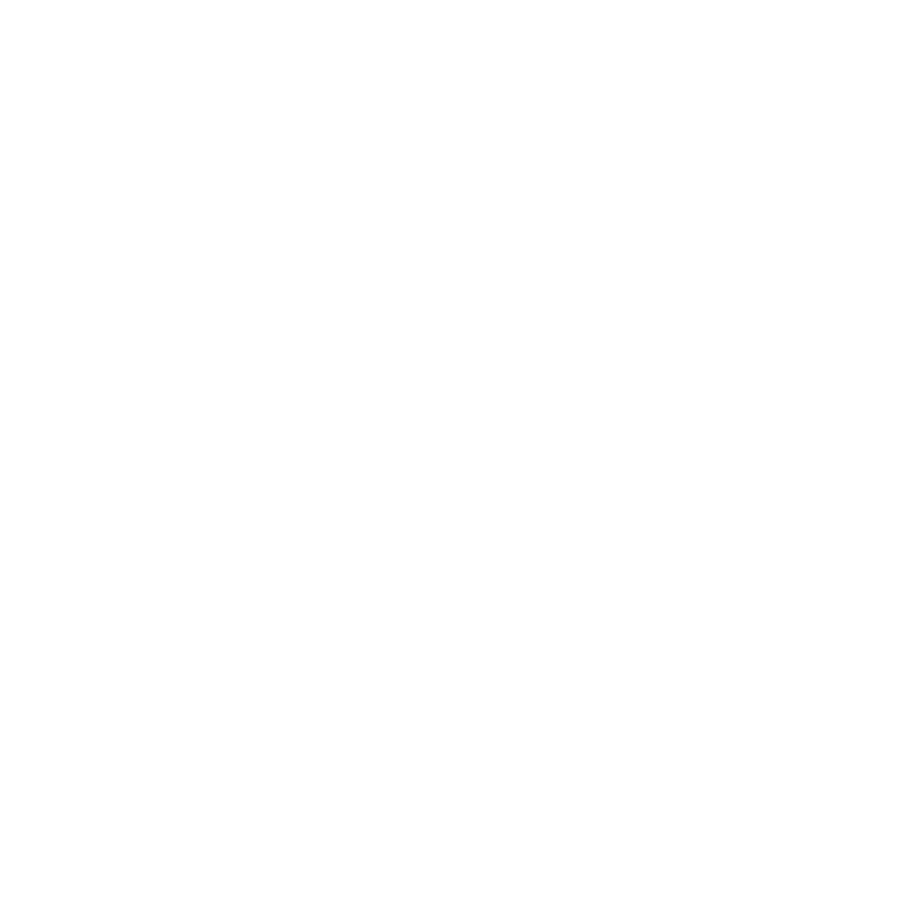

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2010.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2011 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


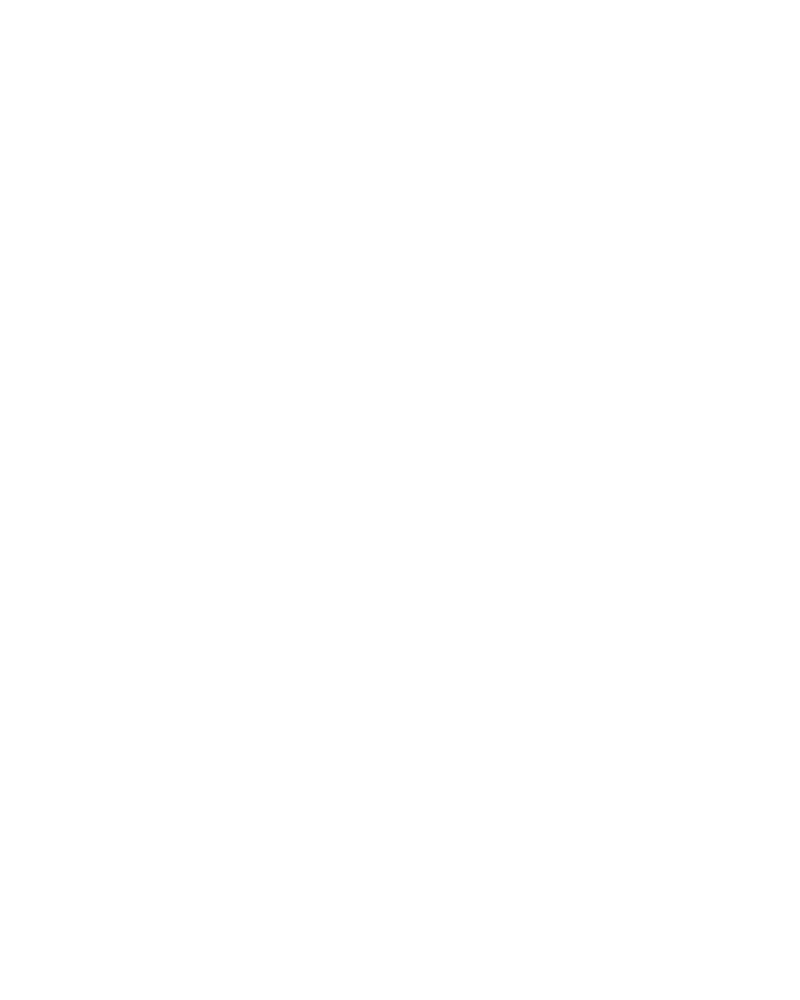

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 15.69


<IPython.core.display.Javascript object>


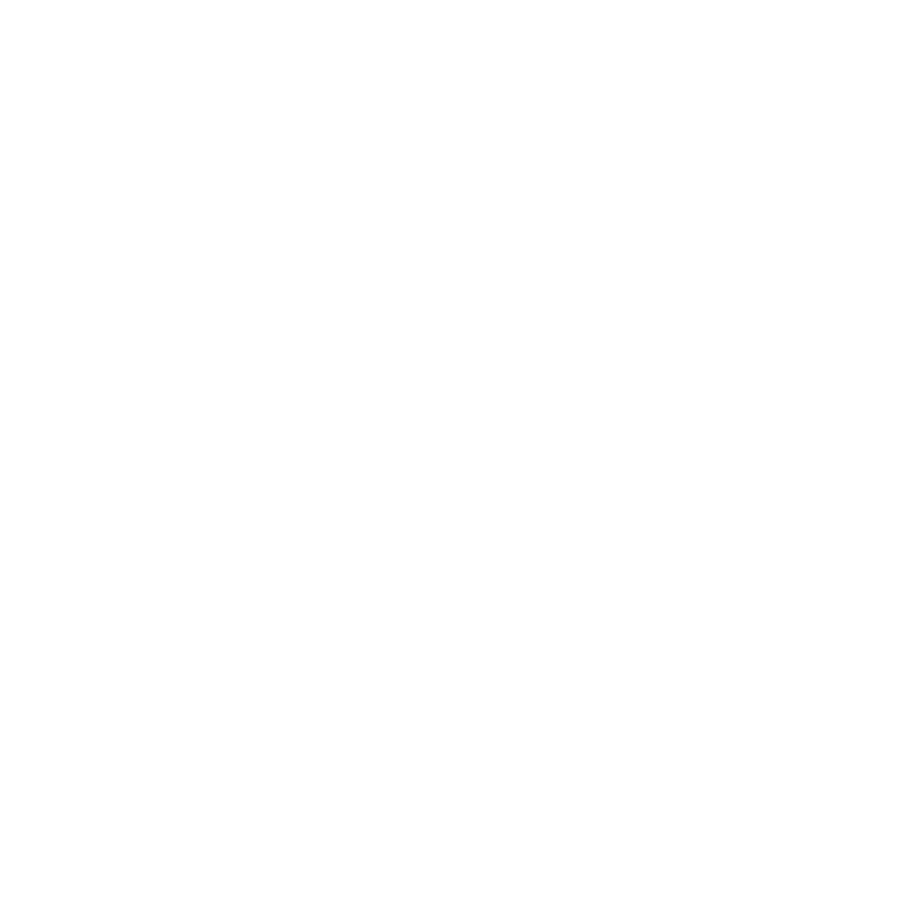

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2011.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2012 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


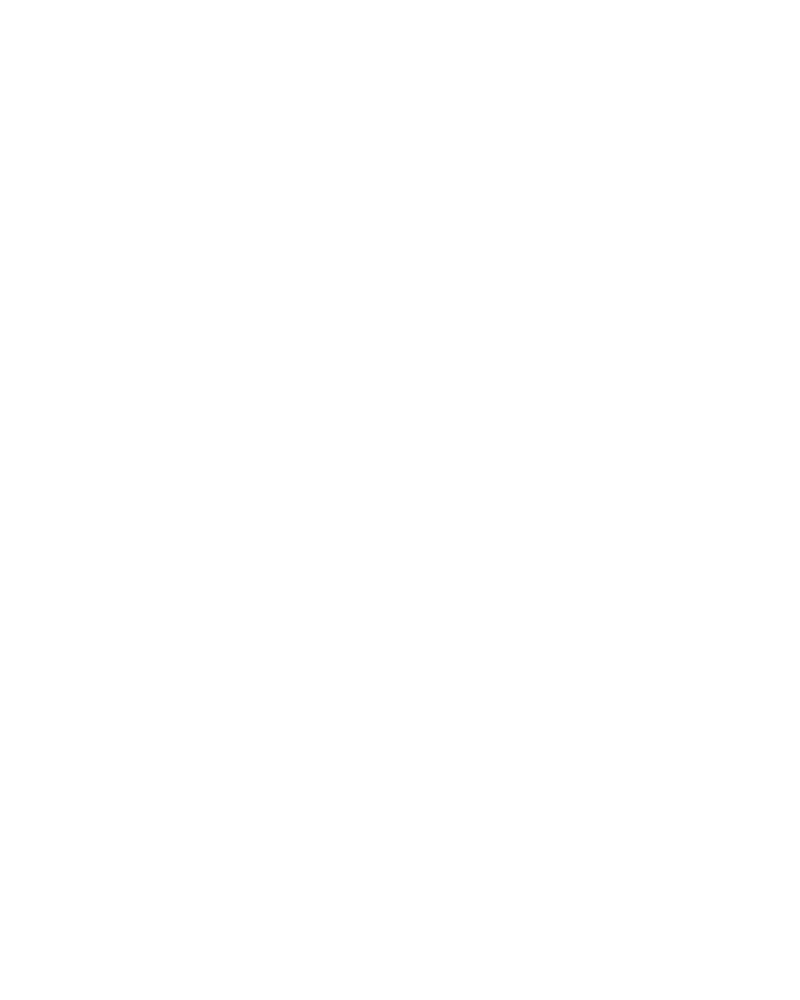

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 13.38


<IPython.core.display.Javascript object>


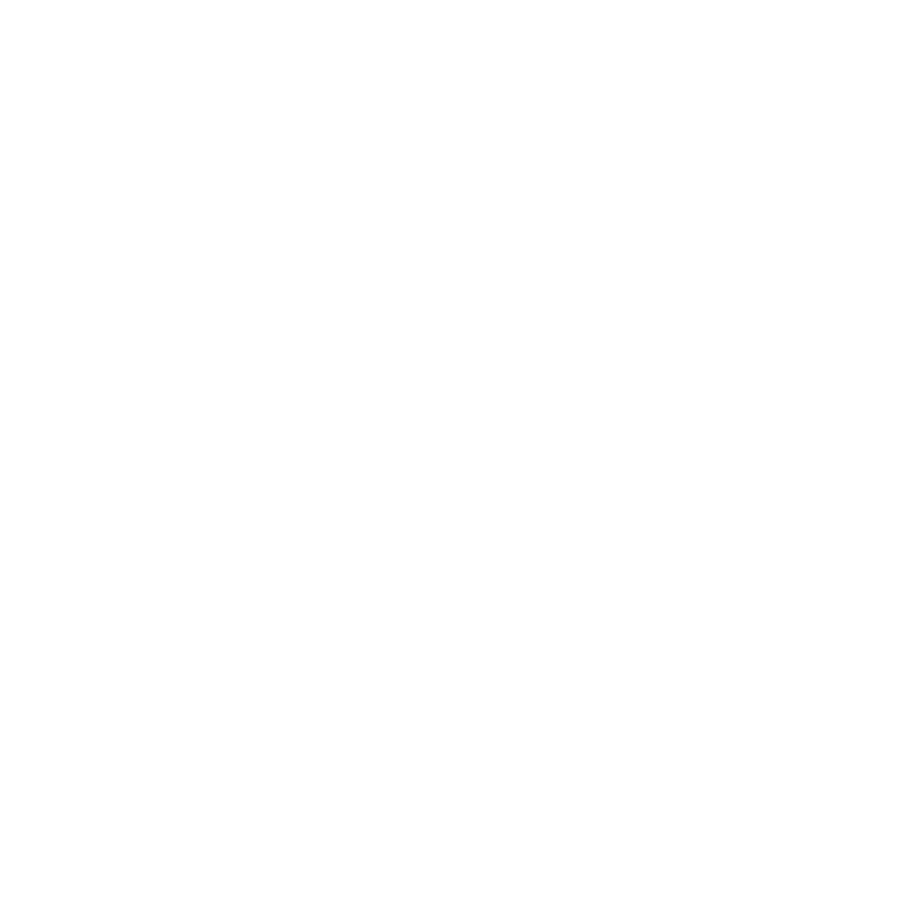

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2012.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2013 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


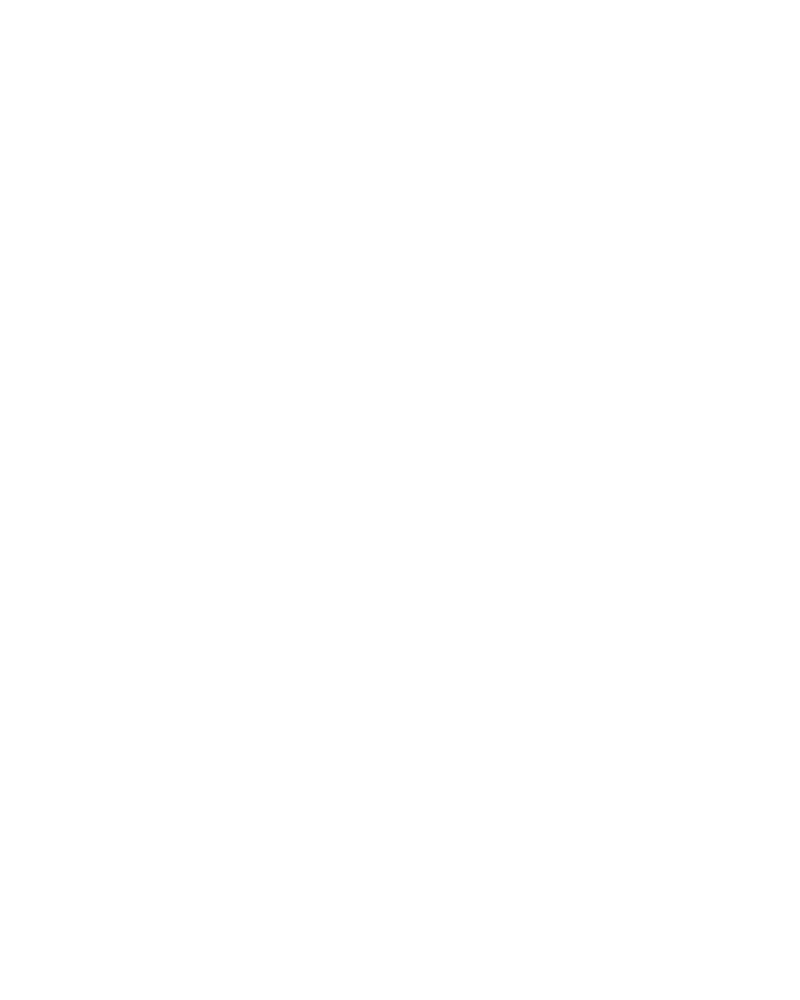

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 18.68


<IPython.core.display.Javascript object>


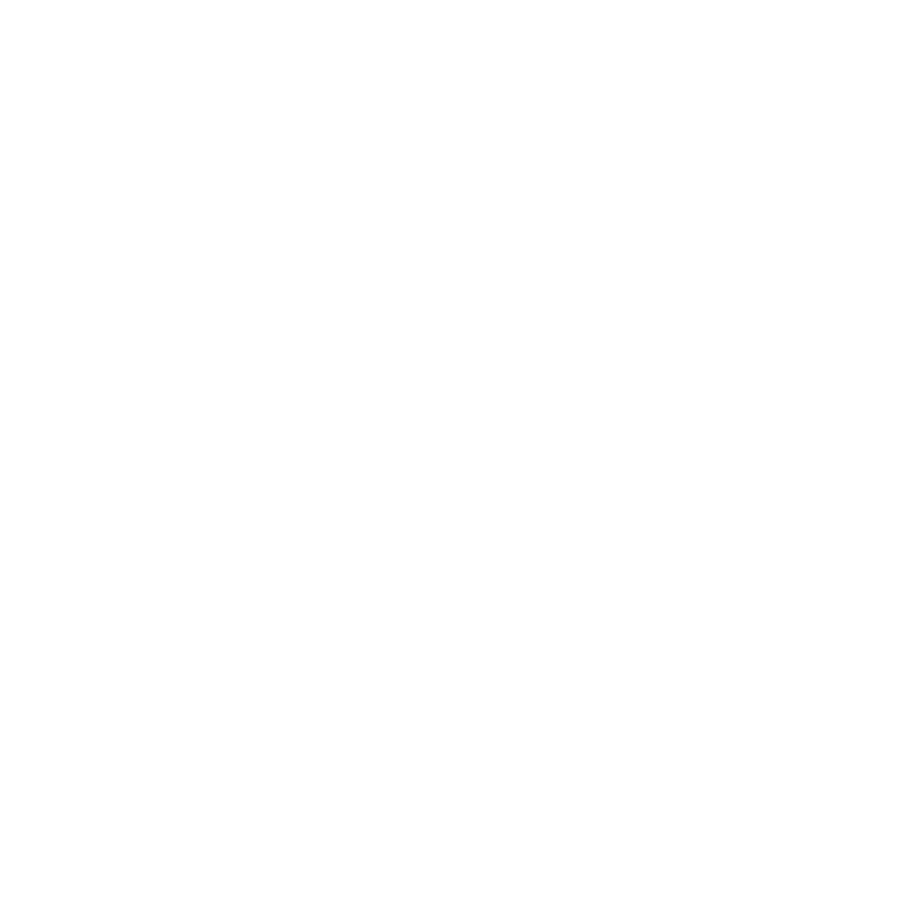

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2013.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
AM_Vakhsh_at_Komsomolabad : 2014 : model=2.88_4.43_37.07_56.48


<IPython.core.display.Javascript object>


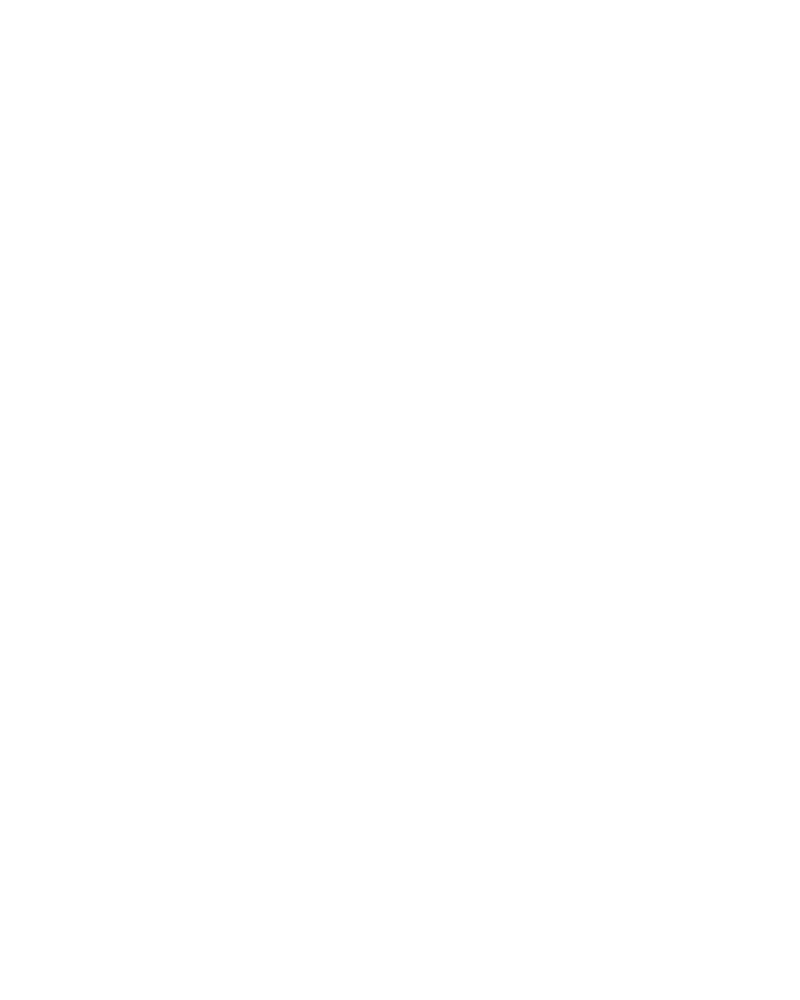

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_hyps.png
total melt = 13.92


<IPython.core.display.Javascript object>


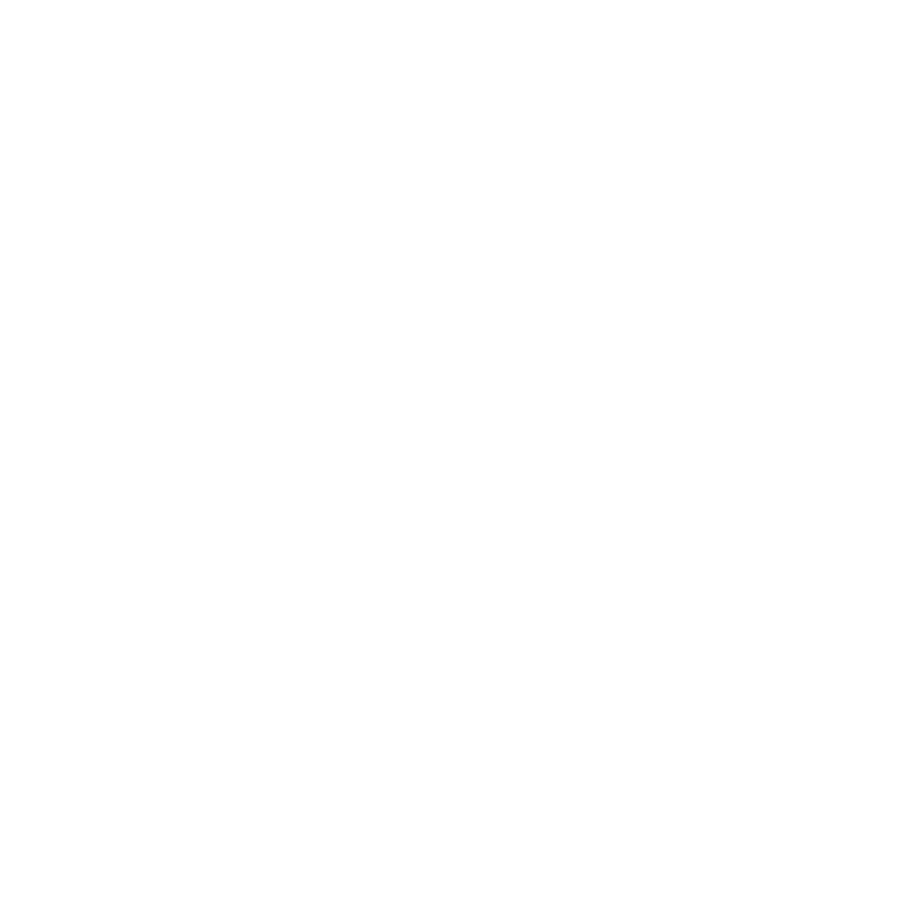

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/AM_Vakhsh_at_Komsomolabad/AM_Vakhsh_at_Komsomolabad.2014.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Vakhsh_SA_model.melt_tseries.png
drainageID=SY_Naryn_at_NarynTown, majorID=SY, model=4.95_5.46_36.73_51.79, label=best_Naryn_SA_model
SY_Naryn_at_NarynTown : 2001 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


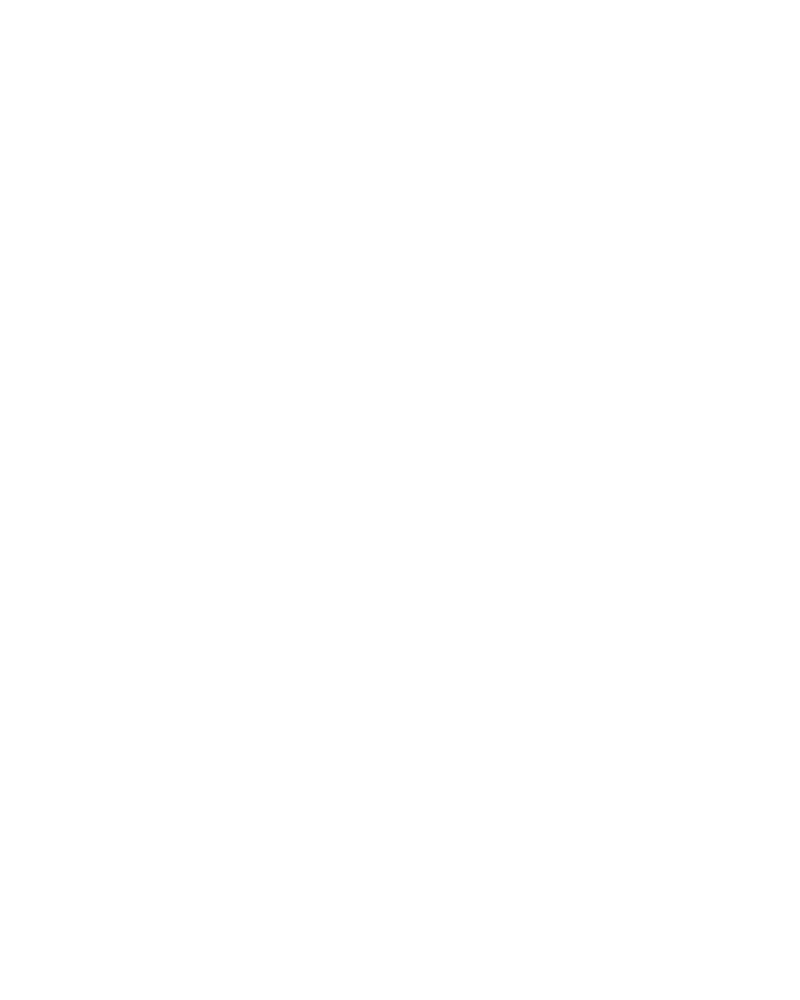

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 5.07


<IPython.core.display.Javascript object>


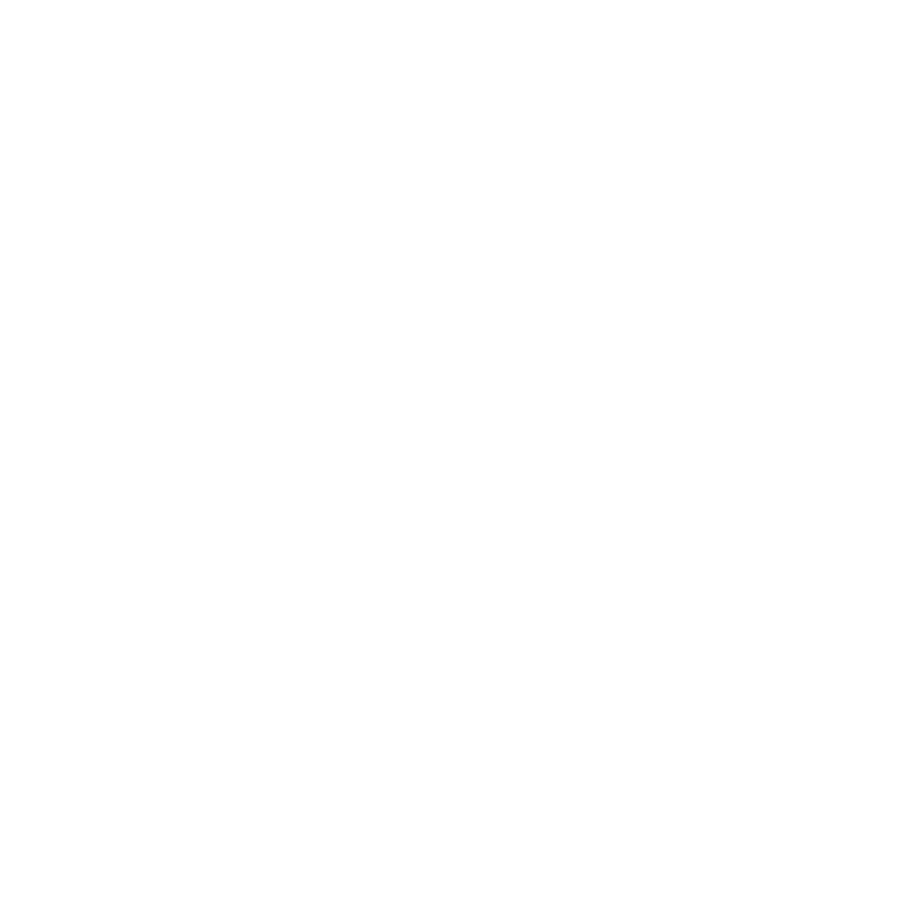

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2001.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2002 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


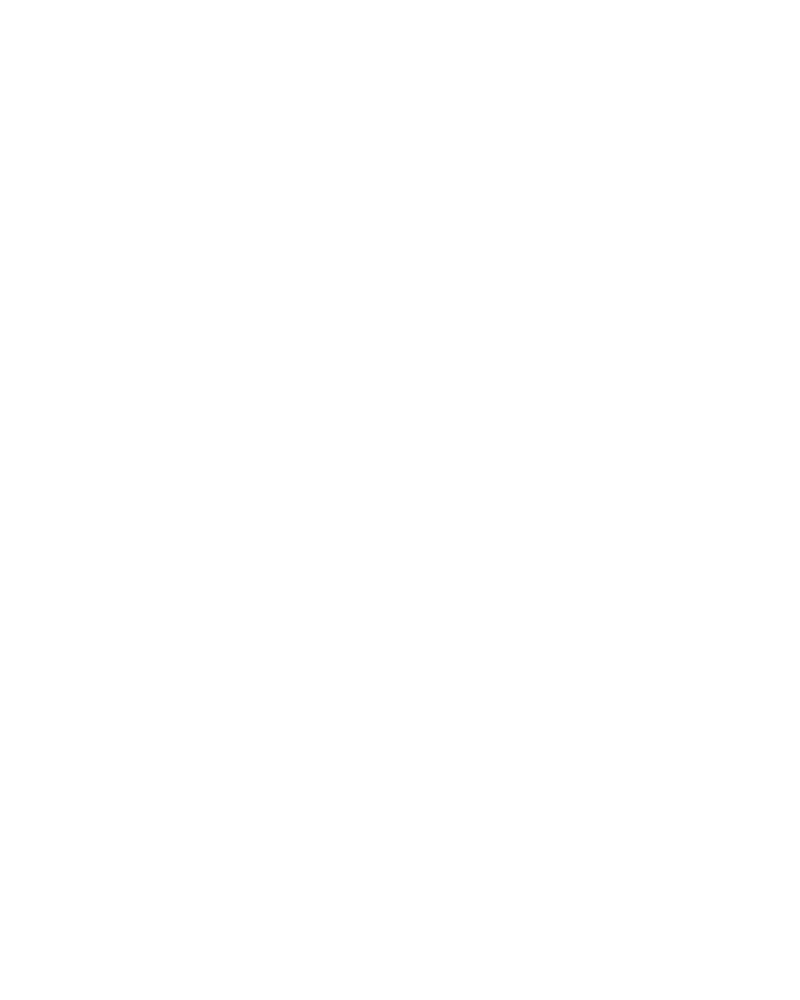

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 5.09


<IPython.core.display.Javascript object>


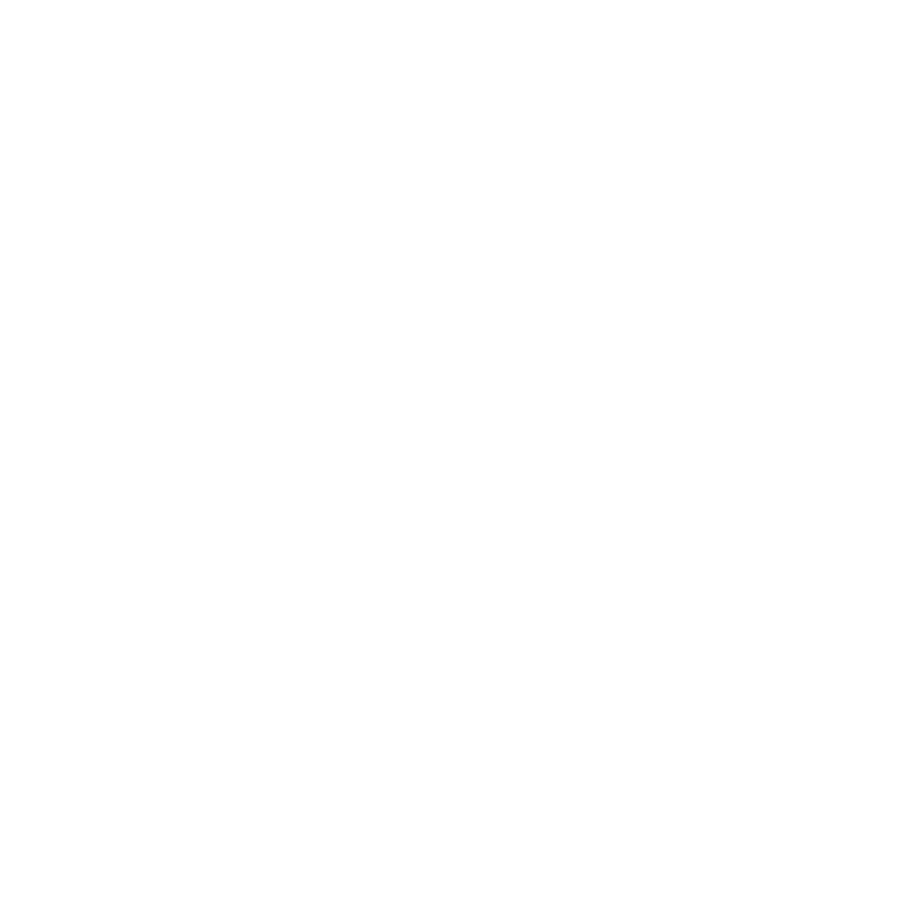

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2002.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2003 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


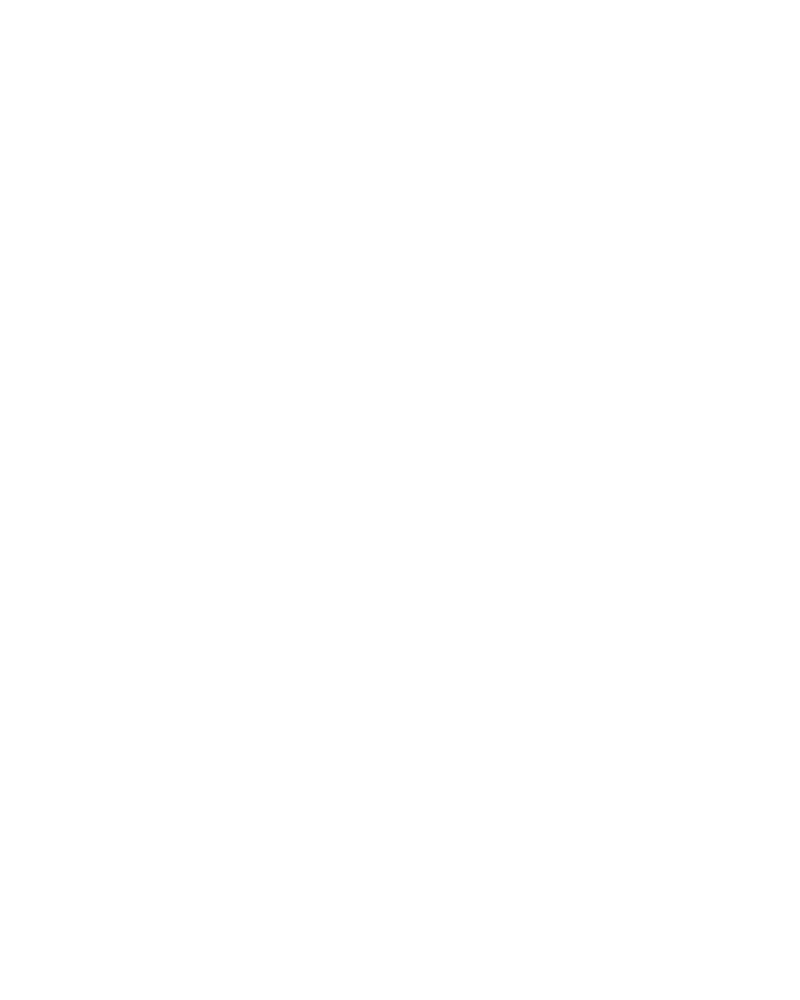

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2003.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 5.38


<IPython.core.display.Javascript object>


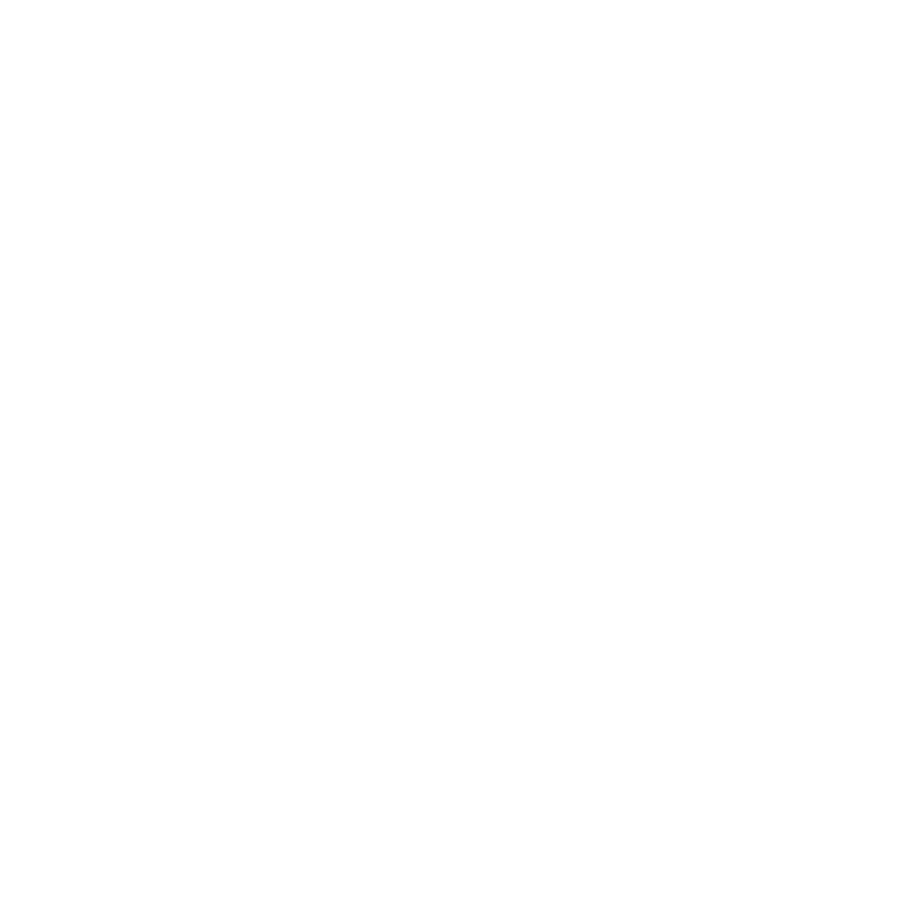

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2003.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2004 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


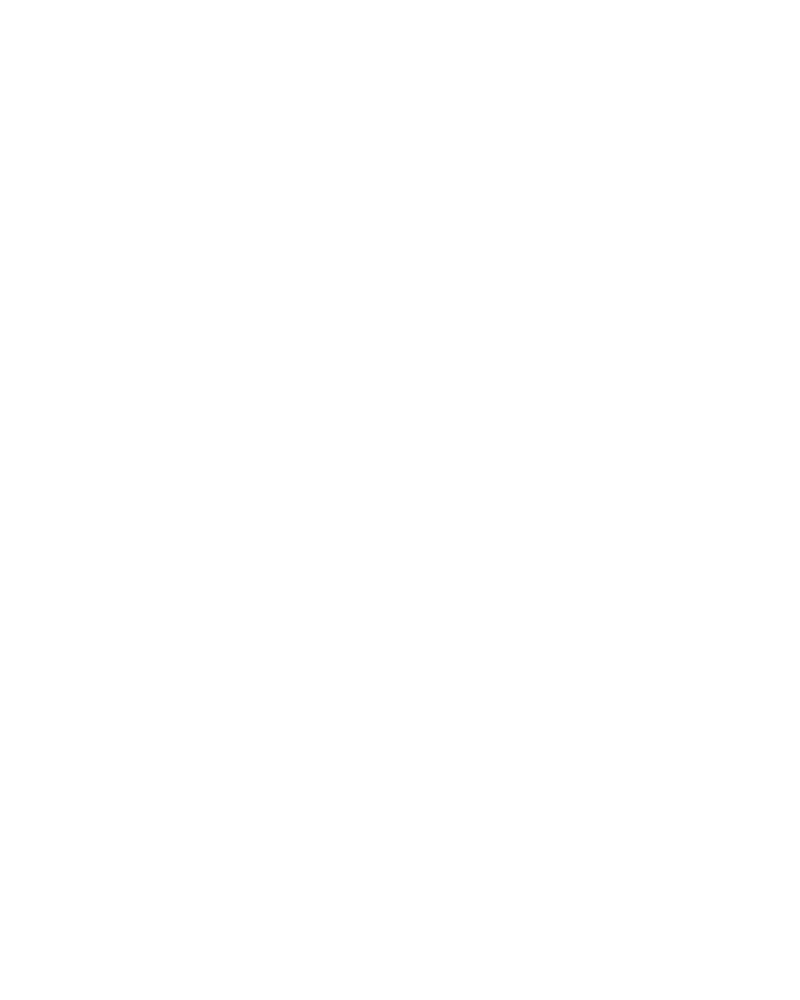

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2004.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 5.43


<IPython.core.display.Javascript object>


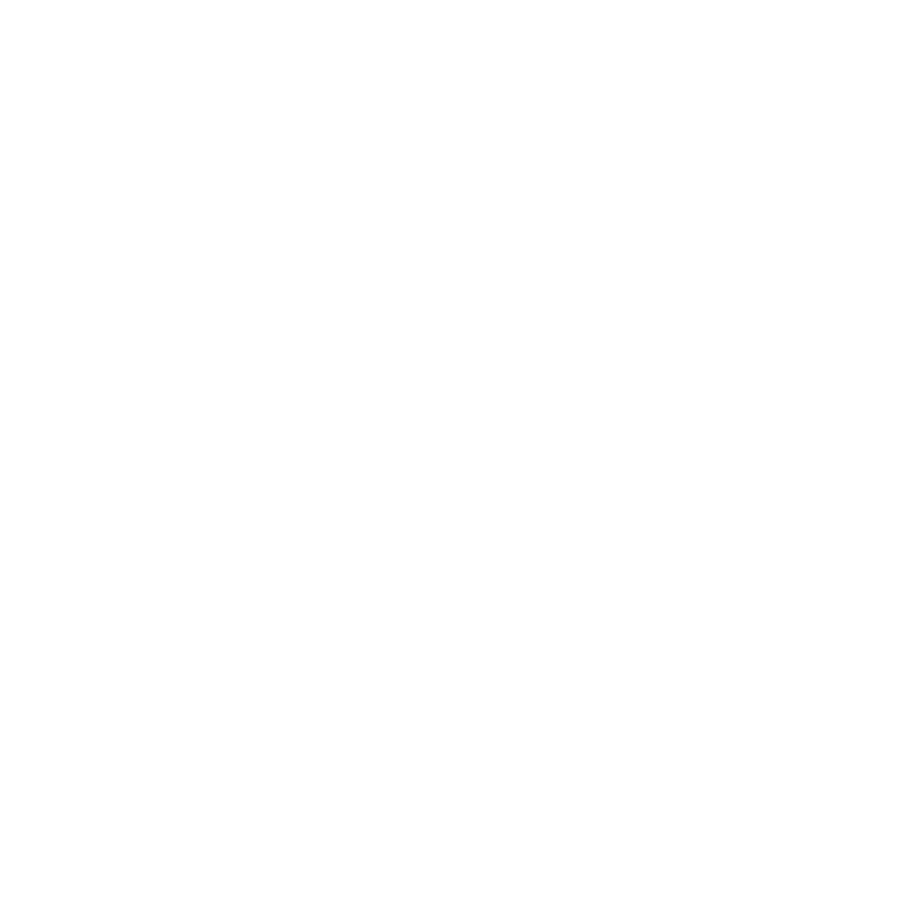

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2004.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2005 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


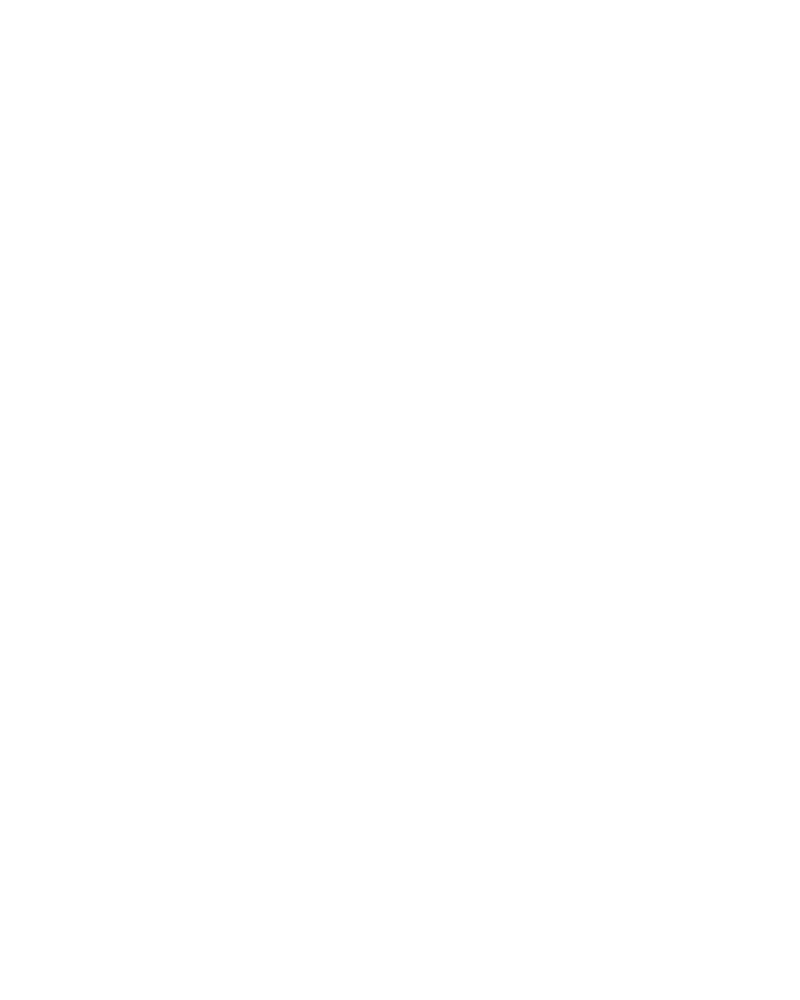

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2005.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 4.58


<IPython.core.display.Javascript object>


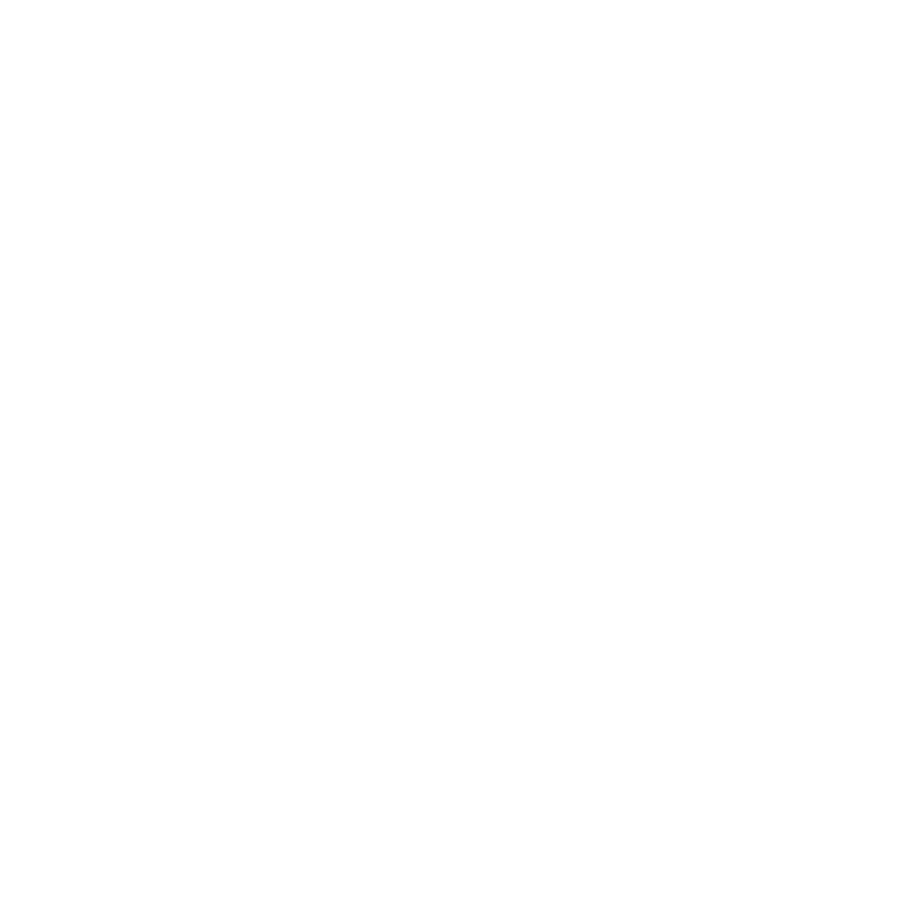

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2005.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2006 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


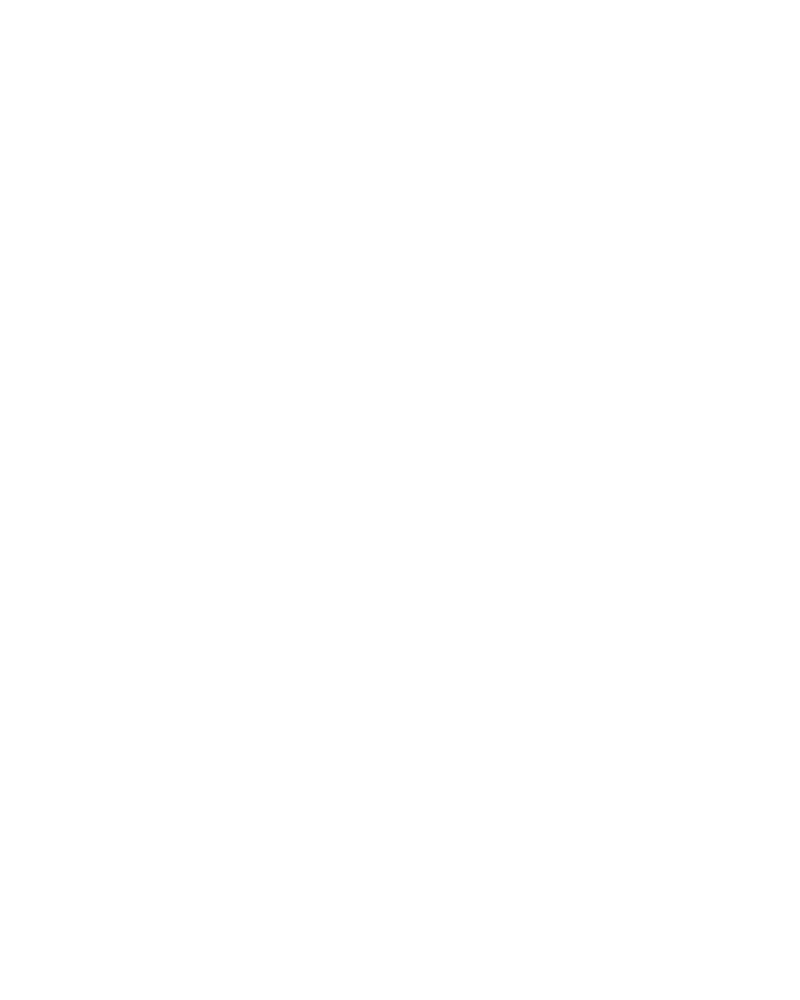

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2006.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 4.63


<IPython.core.display.Javascript object>


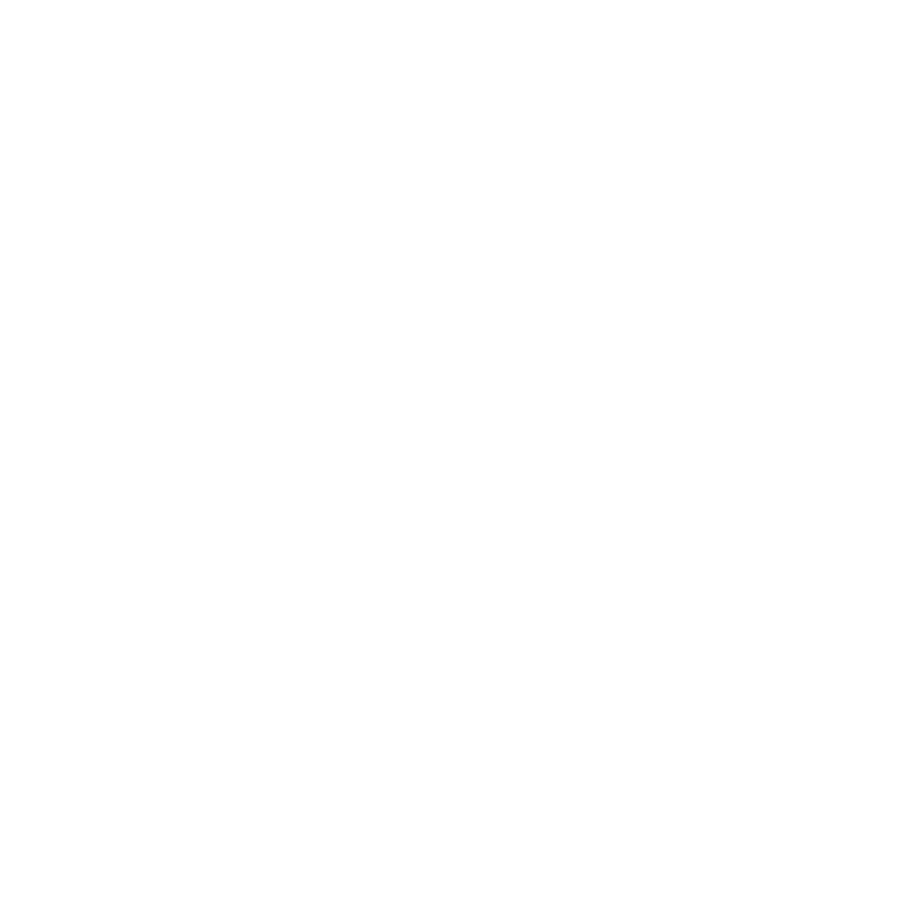

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2006.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2007 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


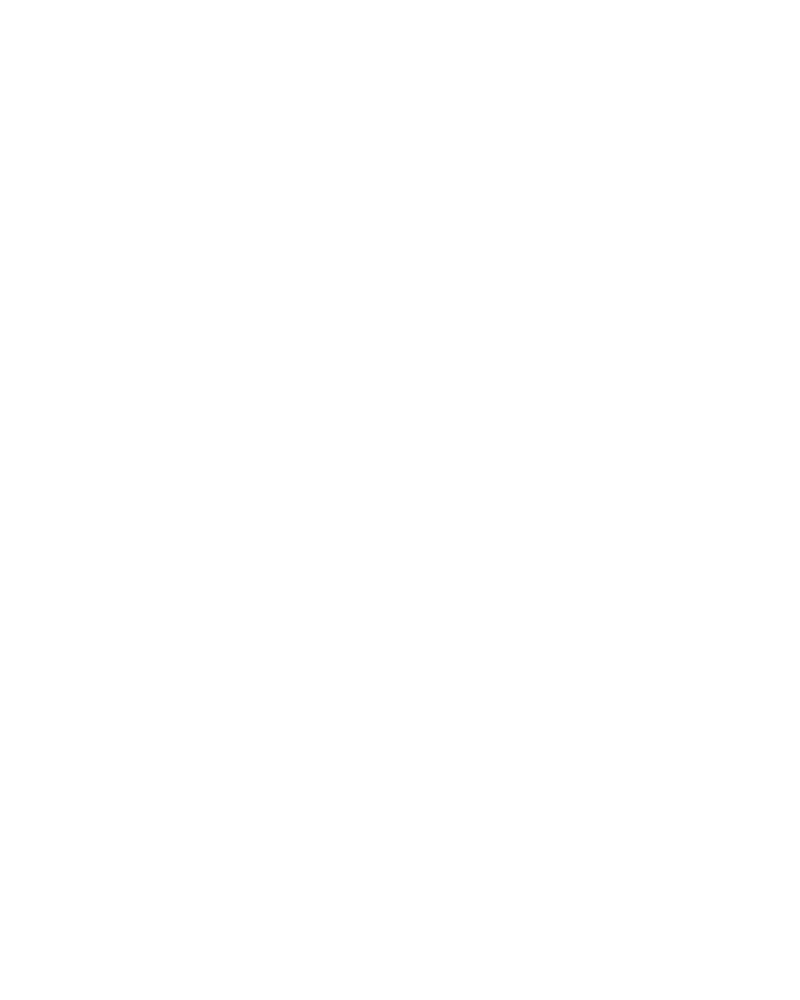

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2007.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 3.29


<IPython.core.display.Javascript object>


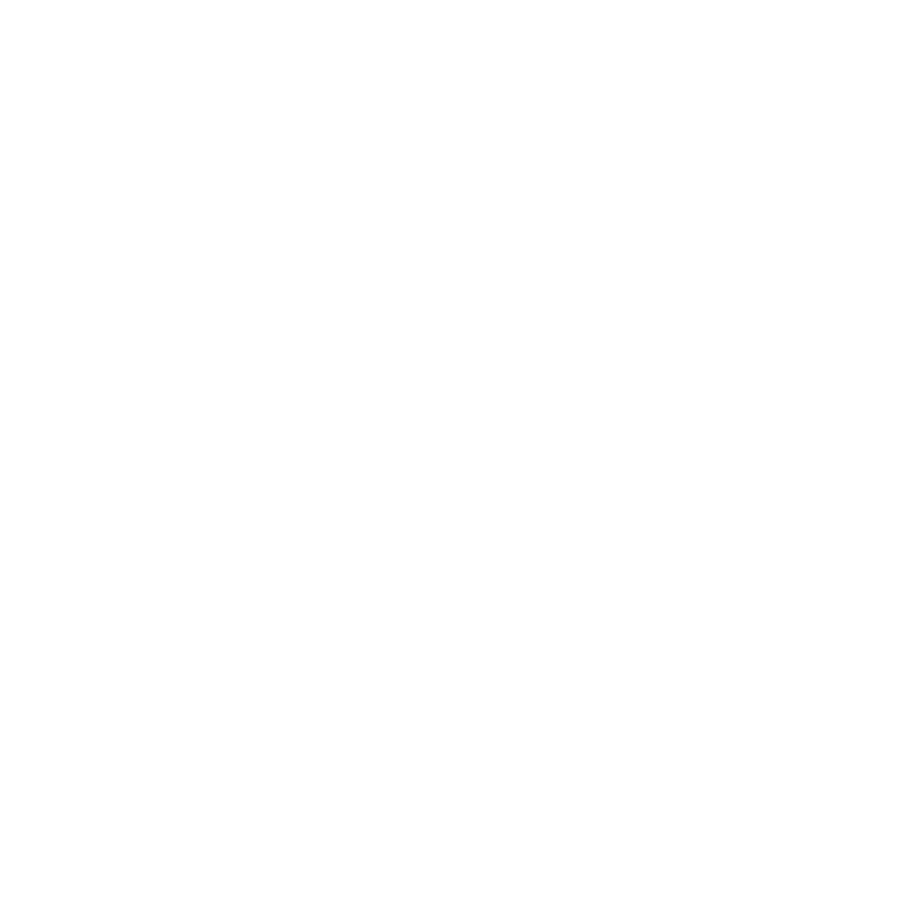

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2007.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2008 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


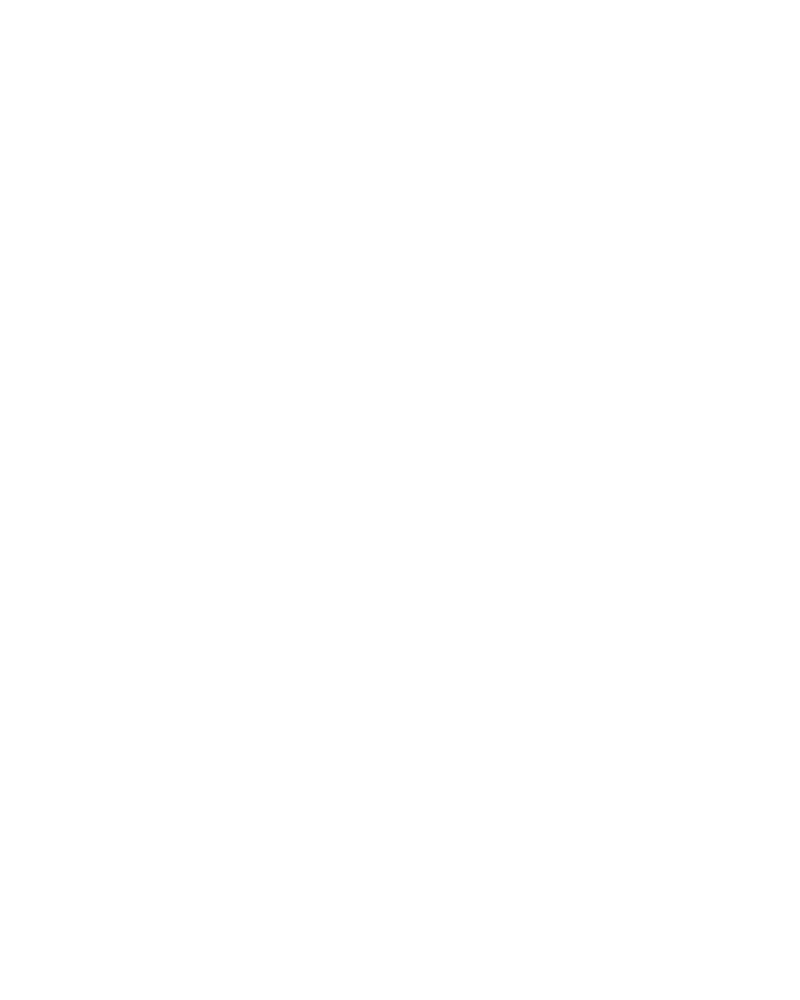

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2008.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 3.56


<IPython.core.display.Javascript object>


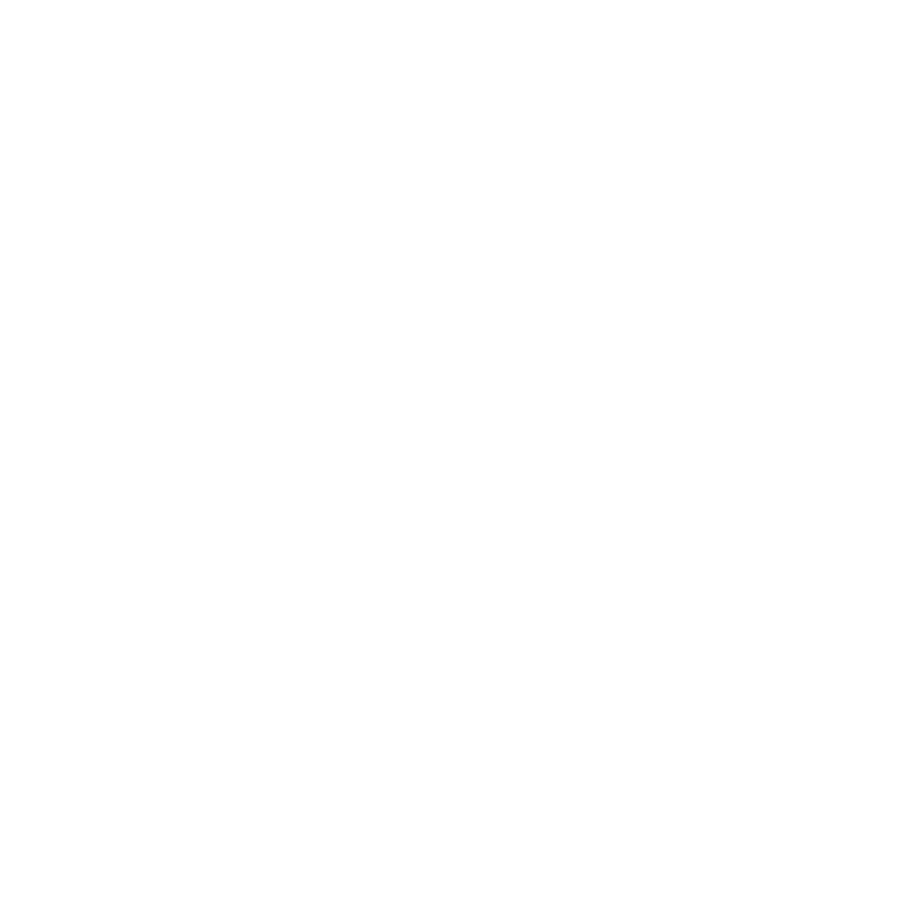

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2008.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2009 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


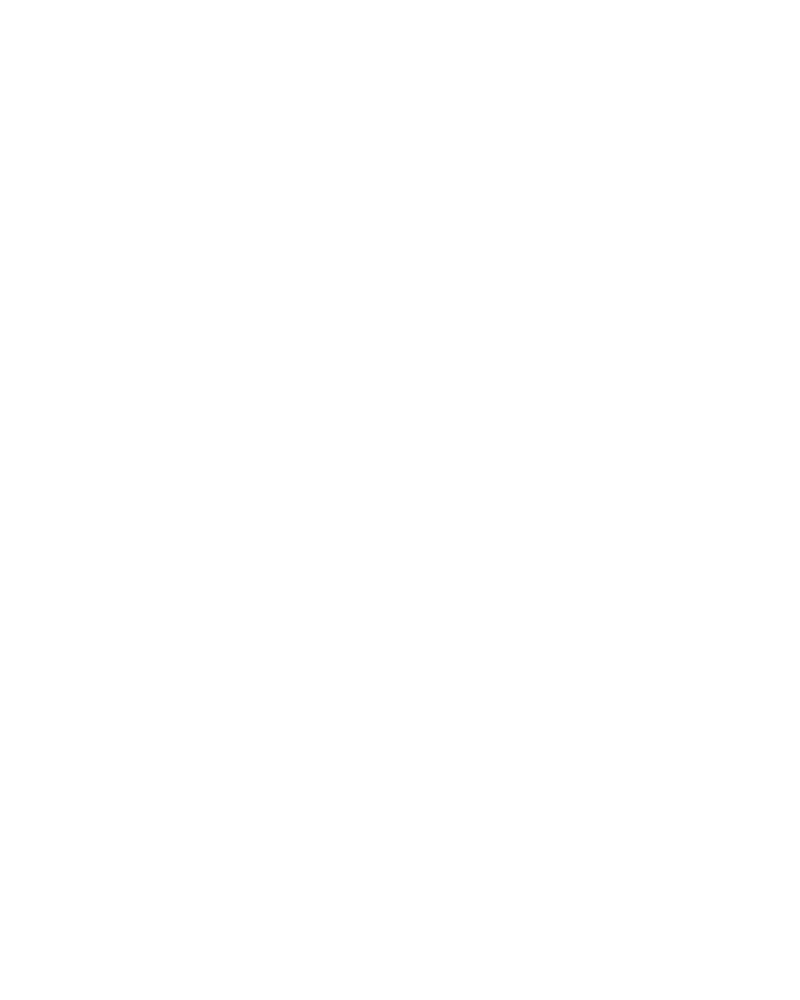

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2009.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 4.76


<IPython.core.display.Javascript object>


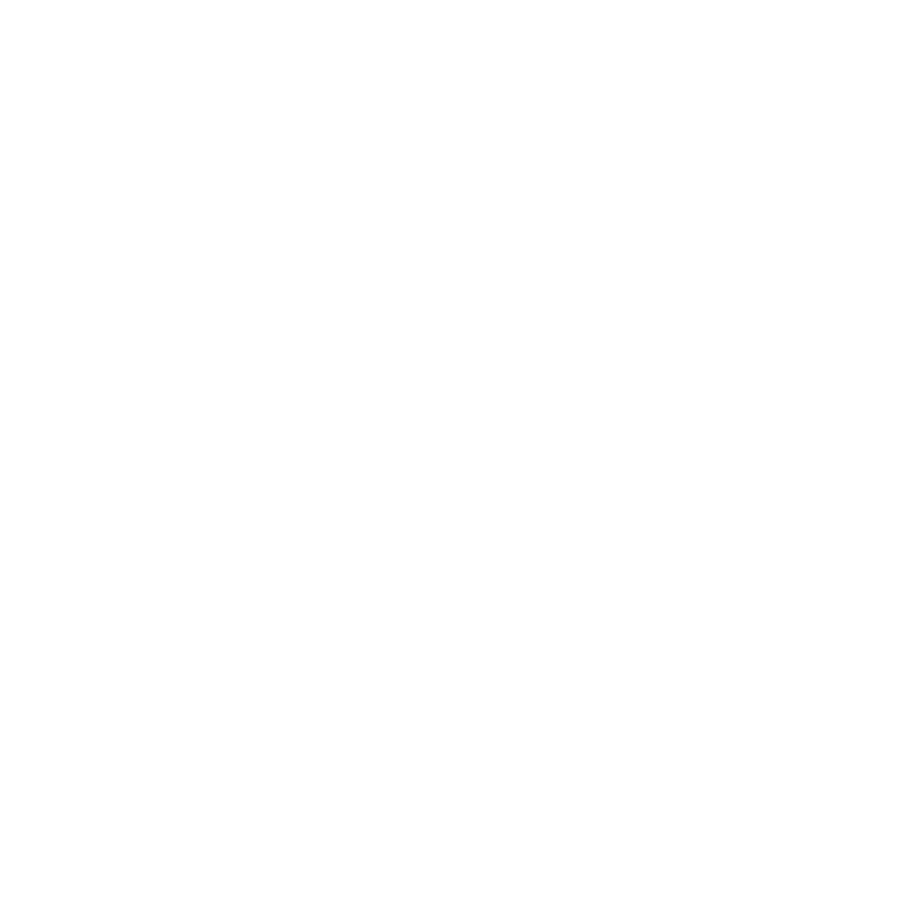

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2009.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2010 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


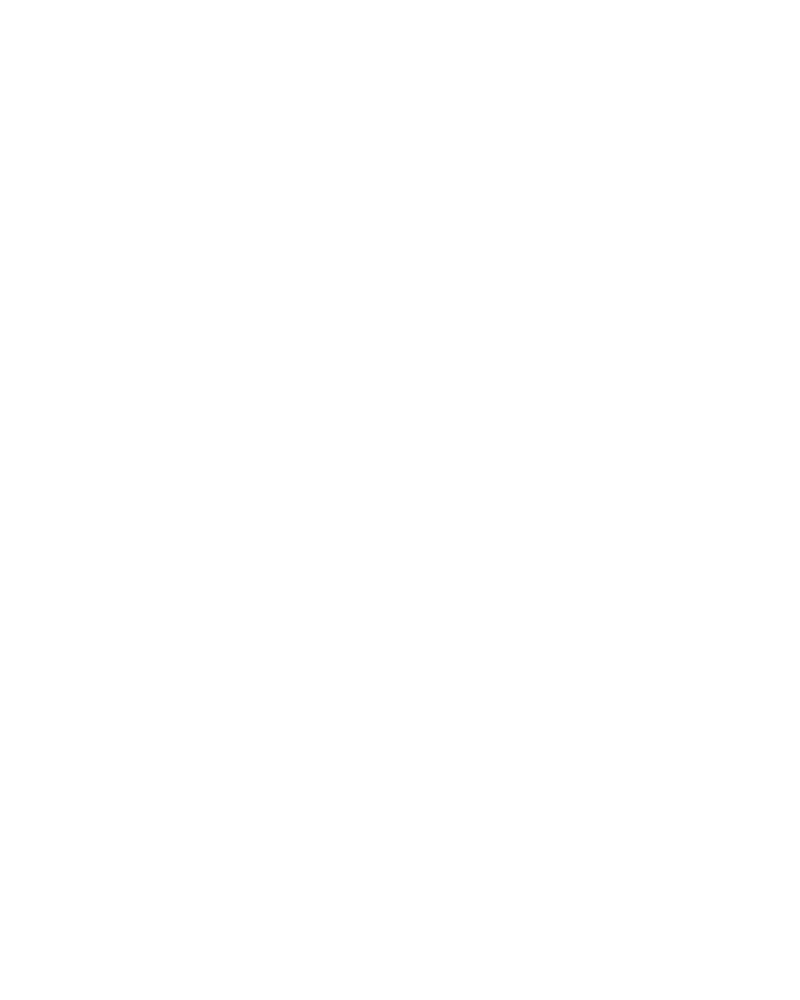

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2010.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 5.25


<IPython.core.display.Javascript object>


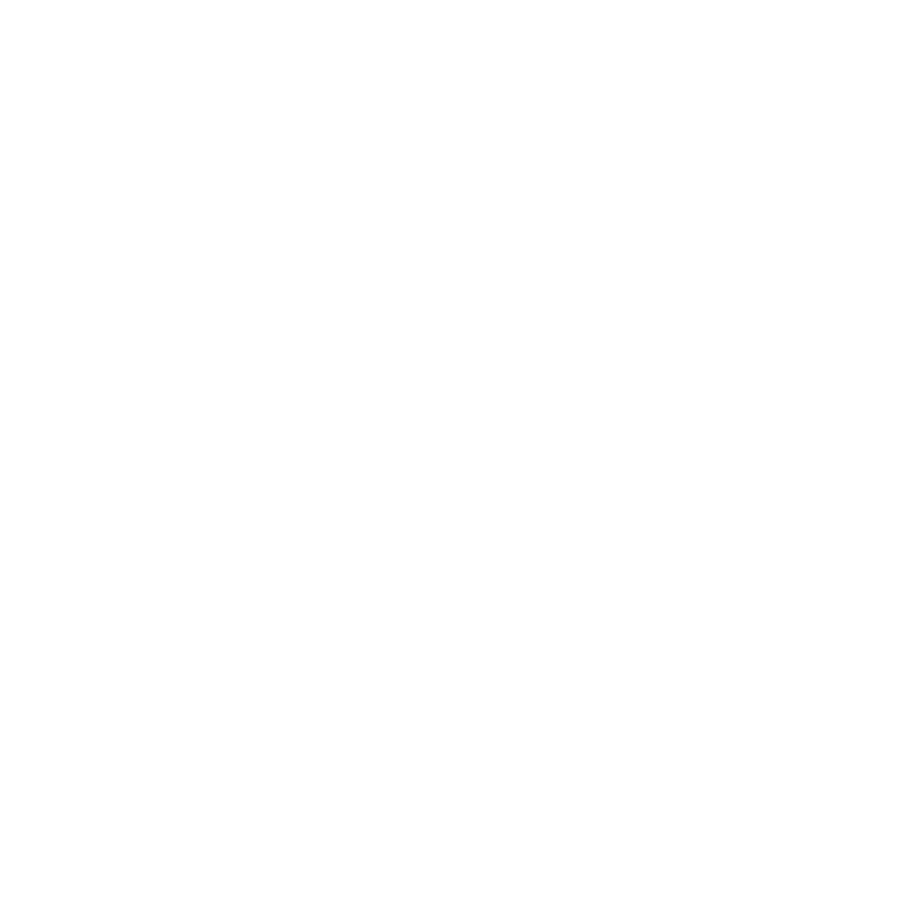

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2010.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2011 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


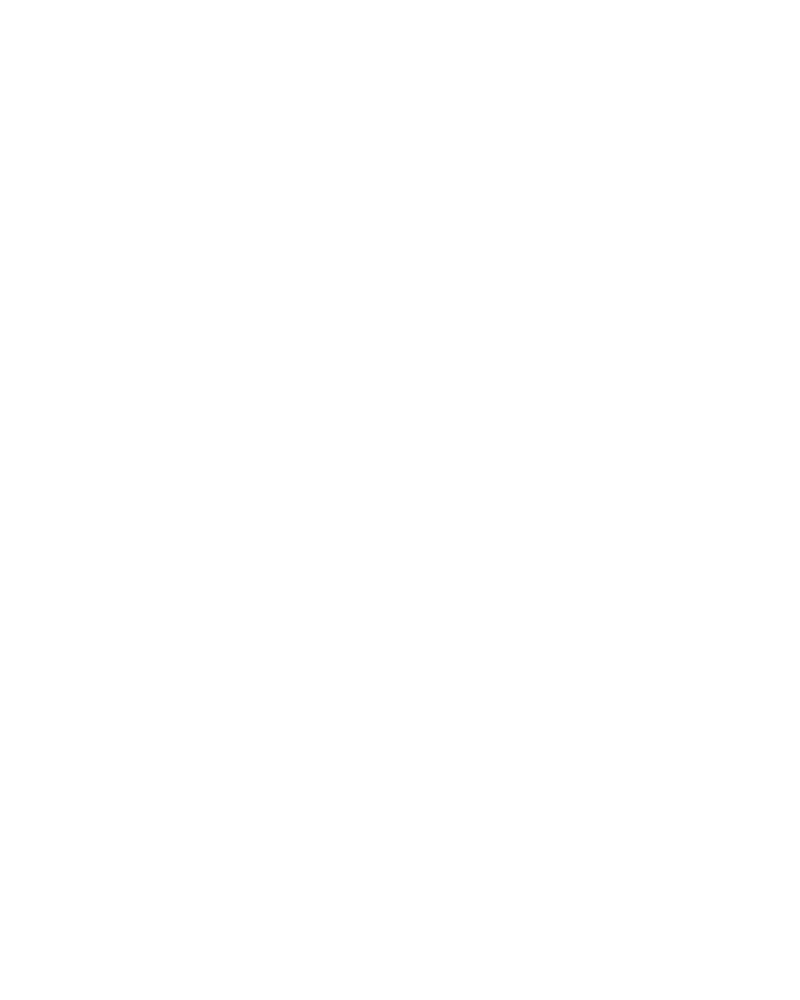

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2011.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 4.39


<IPython.core.display.Javascript object>


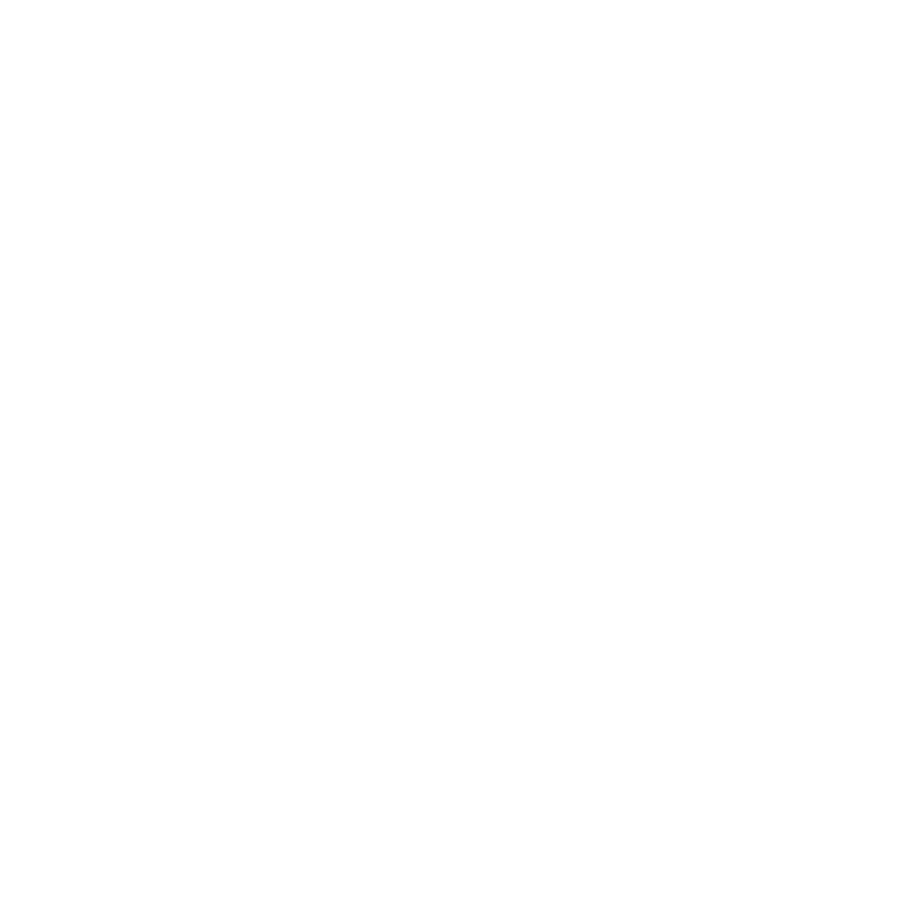

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2011.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2012 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


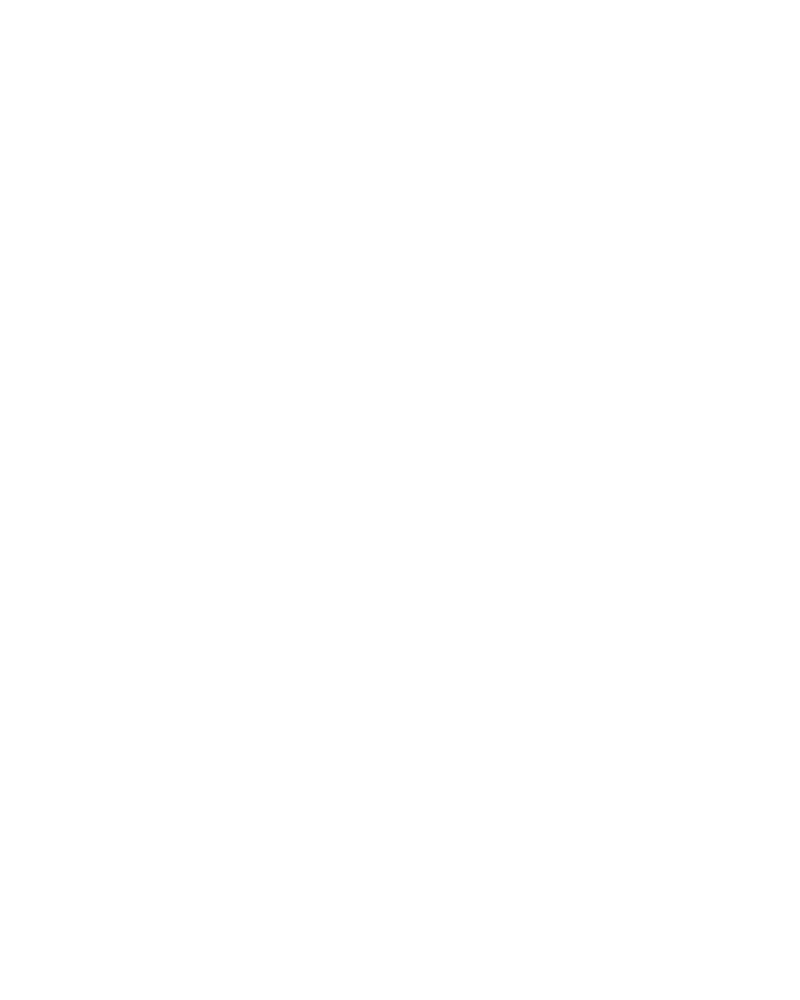

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2012.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 3.11


<IPython.core.display.Javascript object>


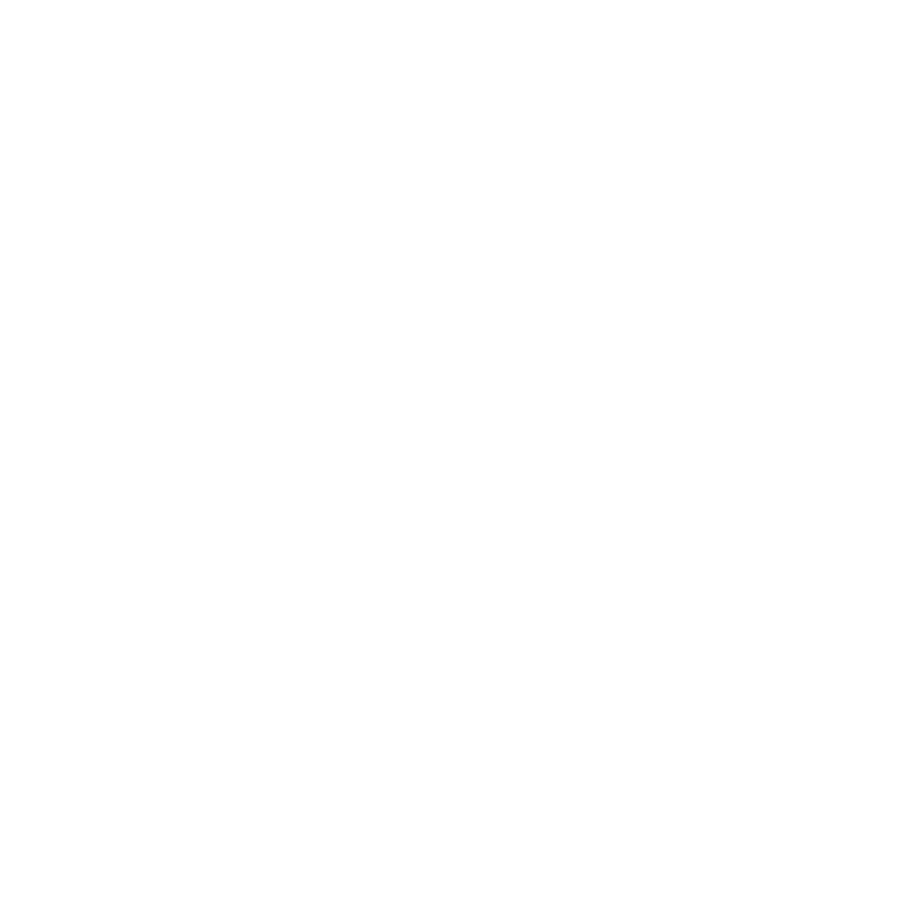

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2012.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2013 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


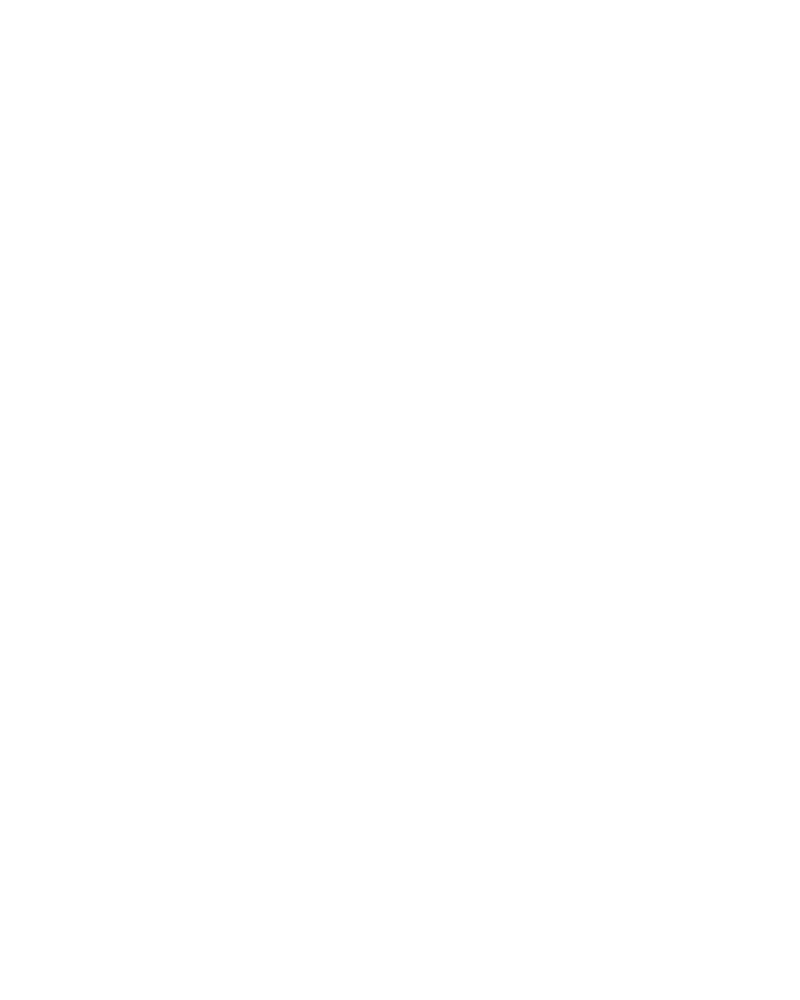

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 3.07


<IPython.core.display.Javascript object>


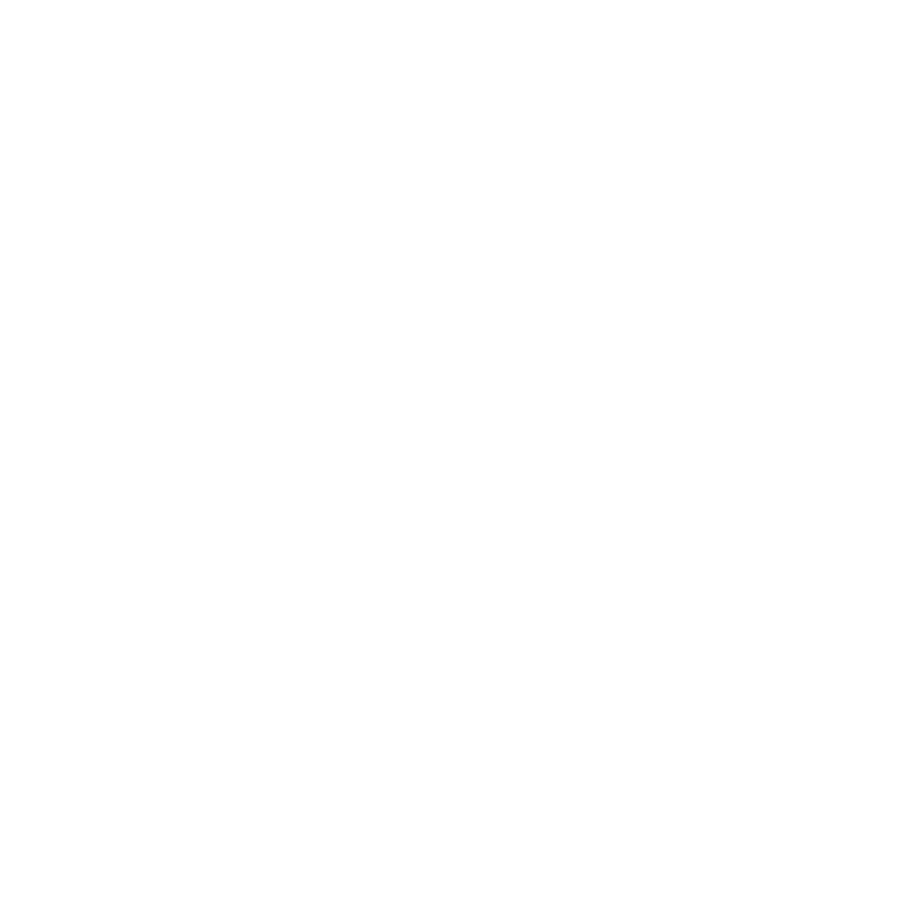

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2013.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png
SY_Naryn_at_NarynTown : 2014 : model=4.95_5.46_36.73_51.79


<IPython.core.display.Javascript object>


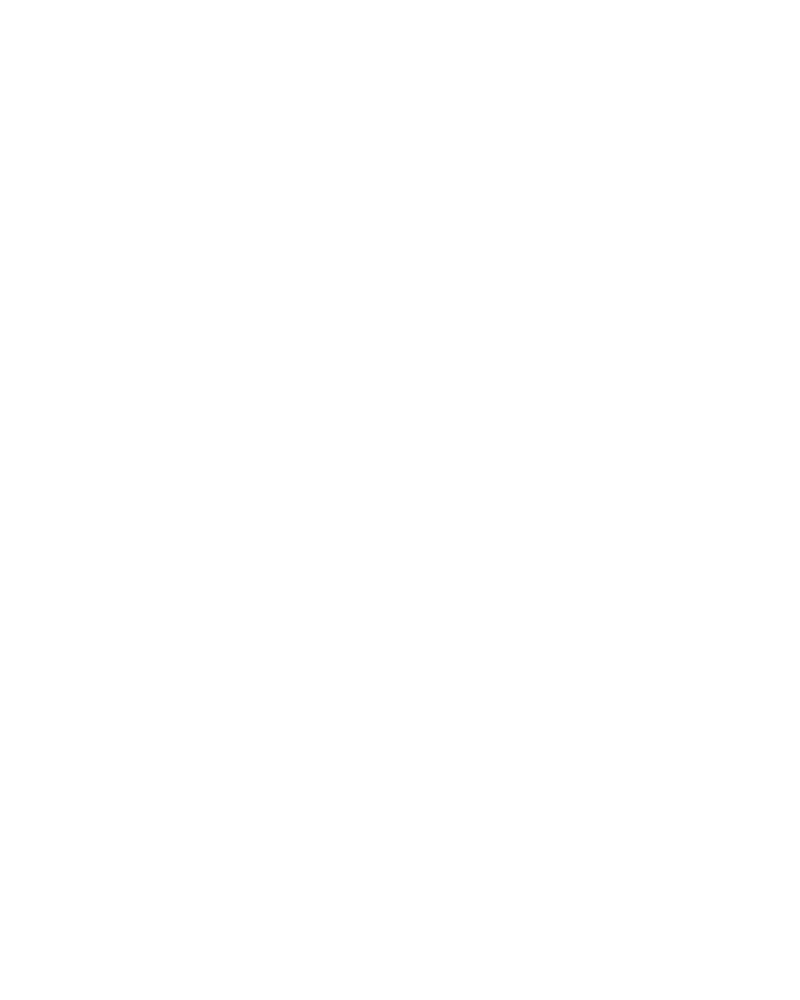

Wrote melt_hyps to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_hyps.png
total melt = 1.87


<IPython.core.display.Javascript object>


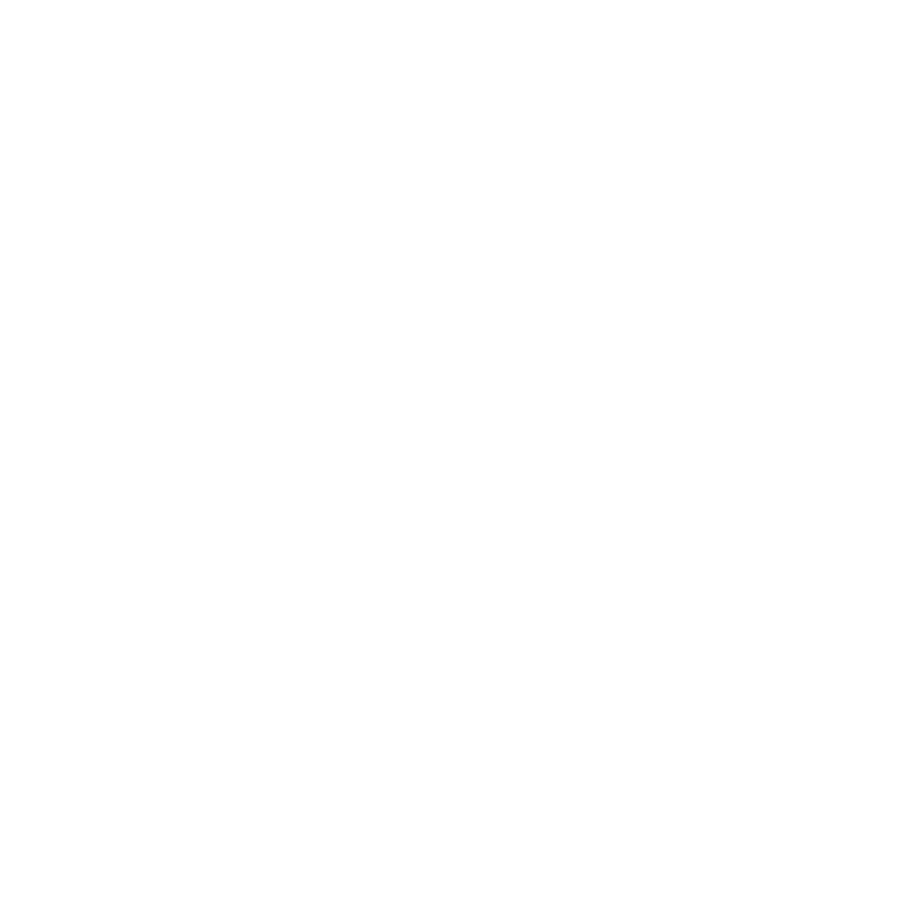

Wrote melt_tseries to /work/charis/ti_model//derived_hypsometries/EGU2018r1/SY_Naryn_at_NarynTown/SY_Naryn_at_NarynTown.2014.0100m.modicev04_3strike.GRSIZE_SCAG.fromFile.best_Naryn_SA_model.melt_tseries.png


In [29]:
for drainageID in drainageIDs:
    majorID = drainageID[:2]
    if majorID == "IN":
        model_str = "9.77_11.21_26.08_32.22"# "10.17_11.15_16.18_36.08" #" 8.67_8.67_28.89_28.89"
        label = "best_Hunza_SA_model"
    elif majorID == "AM":
        model_str = "2.88_4.43_37.07_56.48" # "3.42_4.83_22.53_42.58" # "2.5_4.67_21.78_24.44"
        label = "best_Vakhsh_SA_model"
    elif majorID == "SY":
        model_str = "4.95_5.46_36.73_51.79" #"2.5_4.67_21.78_24.44"
        label = "best_Naryn_SA_model"
    #elif majorID == "GA" or majorID == "BR":
    #    model_str = "2.44_2.44_8.78_8.78"
    #    label = "best_SaptaKosi_model"
    else:
        print("Skipping drainageID=%s, unknown majorID=%s" % (drainageID, majorID))
        #print("Skipping drainageID=%s, unknown" % (drainageID))
        continue
    print("drainageID=%s, majorID=%s, model=%s, label=%s" % (
        drainageID, majorID, model_str, label))
    
    for year in years:      
        (baseFilename, input, model_str, SOLmelt, SOImelt, EGImelt) = run_model(
            drainageID=drainageID, year=year, nstrikes=nstrikes,
            ablation_method=ablation_method, threshold=threshold,
            model_str=model_str, label=label)
        show_melt_hyps(drainageID, year, baseFilename, input['temperature_by_elevation_filename'],
                       SOLmelt, SOImelt, EGImelt, label=label, closePlot=closePlot)
        show_melt_tseries(drainageID, year, baseFilename, input, model_str, 
                          SOLmelt, SOImelt, EGImelt, label=label,
                          DDF_annotation=DDF_annotation, 
                          show_rainfall=show_rainfall,
                          rainfall_col=rainfall_col,
                          show_runoff=show_runoff,
                          closePlot=closePlot)

In [ ]:
hyps = Hypsometry(filename="/Users/brodzik/projects/CHARIS/derived_hypsometries/modscag_gf_grsize_scag/IN_OBJECTID10/IN_OBJECTID10.2001.0100m.ERA_Interim_downscale_uncorrected_tsurf.v0.2_by_elev.txt")